In [2]:
import torch
import numpy as np
import scipy.io as sio

数据集来自BCI competitionIV dataset I

In [84]:
from __future__ import print_function
import time

import numpy as np
np.random.seed(1234)
from functools import reduce
import math as m

import scipy.io
#import theano
#import theano.tensor as T

from scipy.interpolate import griddata
from sklearn.preprocessing import scale
#from utils import augment_EEG, cart2sph, pol2cart

#import lasagne
# from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
#from lasagne.layers import Conv2DLayer, MaxPool2DLayer, InputLayer
#from lasagne.layers import DenseLayer, ElemwiseMergeLayer, FlattenLayer
#from lasagne.layers import ConcatLayer, ReshapeLayer, get_output_shape
#from lasagne.layers import Conv1DLayer, DimshuffleLayer, LSTMLayer, SliceLayer


def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.

    :param pos: position in 3D Cartesian coordinates
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, m.pi / 2 - elev)


def gen_images(locs, features, n_gridpoints, normalize=True,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param std_mult     Multiplier for std of added noise
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = int(features.shape[1] / nElectrodes)
    for c in range(int(n_colors)):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])
    if augment:
        if pca:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=True, n_components=n_components)
        else:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=False, n_components=n_components)
    nSamples = features.shape[0]
    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                    method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}\r'.format(i+1, nSamples), end='\r')
    # Normalizing
    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
        temp_interp[c] = np.nan_to_num(temp_interp[c])
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]


def build_cnn(input_var=None, w_init=None, n_layers=(4, 2, 1), n_filters_first=32, imsize=32, n_colors=3):
    """
    Builds a VGG style CNN network followed by a fully-connected layer and a softmax layer.
    Stacks are separated by a maxpool layer. Number of kernels in each layer is twice
    the number in previous stack.
    input_var: Theano variable for input to the network
    outputs: pointer to the output of the last layer of network (softmax)

    :param input_var: theano variable as input to the network
    :param w_init: Initial weight values
    :param n_layers: number of layers in each stack. An array of integers with each
                    value corresponding to the number of layers in each stack.
                    (e.g. [4, 2, 1] == 3 stacks with 4, 2, and 1 layers in each.
    :param n_filters_first: number of filters in the first layer
    :param imSize: Size of the image
    :param n_colors: Number of color channels (depth)
    :return: a pointer to the output of last layer
    """
    weights = []        # Keeps the weights for all layers
    count = 0
    # If no initial weight is given, initialize with GlorotUniform
    if w_init is None:
        w_init = [lasagne.init.GlorotUniform()] * sum(n_layers)
    # Input layer
    network = InputLayer(shape=(None, n_colors, imsize, imsize),
                                        input_var=input_var)
    for i, s in enumerate(n_layers):
        for l in range(s):
            network = Conv2DLayer(network, num_filters=n_filters_first * (2 ** i), filter_size=(3, 3),
                          W=w_init[count], pad='same')
            count += 1
            weights.append(network.W)
        network = MaxPool2DLayer(network, pool_size=(2, 2))
    return network, weights


def build_convpool_max(input_vars, nb_classes, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with maxpooling layer in time.

    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(convnet)
    # convpooling using Max pooling over frames
    convpool = ElemwiseMergeLayer(convnets, theano.tensor.maximum)
    # A fully-connected layer of 512 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=512, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the output layer with 50% dropout on its inputs:
    convpool = lasagne.layers.DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def build_convpool_conv1d(input_vars, nb_classes, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with 1D-conv layer to integrate time from sequences of EEG images.

    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(FlattenLayer(convnet))
    # at this point convnets shape is [numTimeWin][n_samples, features]
    # we want the shape to be [n_samples, features, numTimeWin]
    convpool = ConcatLayer(convnets)
    convpool = ReshapeLayer(convpool, ([0], n_timewin, get_output_shape(convnets[0])[1]))
    convpool = DimshuffleLayer(convpool, (0, 2, 1))
    # input to 1D convlayer should be in (batch_size, num_input_channels, input_length)
    convpool = Conv1DLayer(convpool, 64, 3)
    # A fully-connected layer of 512 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=512, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the output layer with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def build_convpool_lstm(input_vars, nb_classes, grad_clip=110, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with LSTM layer to integrate time from sequences of EEG images.

    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param grad_clip:  the gradient messages are clipped to the given value during
                        the backward pass.
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(FlattenLayer(convnet))
    # at this point convnets shape is [numTimeWin][n_samples, features]
    # we want the shape to be [n_samples, features, numTimeWin]
    convpool = ConcatLayer(convnets)
    convpool = ReshapeLayer(convpool, ([0], n_timewin, get_output_shape(convnets[0])[1]))
    # Input to LSTM should have the shape as (batch size, SEQ_LENGTH, num_features)
    convpool = LSTMLayer(convpool, num_units=128, grad_clipping=grad_clip,
        nonlinearity=lasagne.nonlinearities.tanh)
    # We only need the final prediction, we isolate that quantity and feed it
    # to the next layer.
    convpool = SliceLayer(convpool, -1, 1)      # Selecting the last prediction
    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=256, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the output layer with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def build_convpool_mix(input_vars, nb_classes, grad_clip=110, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with LSTM and 1D-conv layers combined

    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param grad_clip:  the gradient messages are clipped to the given value during
                        the backward pass.
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(FlattenLayer(convnet))
    # at this point convnets shape is [numTimeWin][n_samples, features]
    # we want the shape to be [n_samples, features, numTimeWin]
    convpool = ConcatLayer(convnets)
    convpool = ReshapeLayer(convpool, ([0], n_timewin, get_output_shape(convnets[0])[1]))
    reformConvpool = DimshuffleLayer(convpool, (0, 2, 1))
    # input to 1D convlayer should be in (batch_size, num_input_channels, input_length)
    conv_out = Conv1DLayer(reformConvpool, 64, 3)
    conv_out = FlattenLayer(conv_out)
    # Input to LSTM should have the shape as (batch size, SEQ_LENGTH, num_features)
    lstm = LSTMLayer(convpool, num_units=128, grad_clipping=grad_clip,
        nonlinearity=lasagne.nonlinearities.tanh)
    lstm_out = SliceLayer(lstm, -1, 1)
    # Merge 1D-Conv and LSTM outputs
    dense_input = ConcatLayer([conv_out, lstm_out])
    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(dense_input, p=.5),
            num_units=512, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    convpool = DenseLayer(convpool,
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    """
    Iterates over the samples returing batches of size batchsize.
    :param inputs: input data array. It should be a 4D numpy array for images [n_samples, n_colors, W, H] and 5D numpy
                    array if working with sequence of images [n_timewindows, n_samples, n_colors, W, H].
    :param targets: vector of target labels.
    :param batchsize: Batch size
    :param shuffle: Flag whether to shuffle the samples before iterating or not.
    :return: images and labels for a batch
    """
    if inputs.ndim == 4:
        input_len = inputs.shape[0]
    elif inputs.ndim == 5:
        input_len = inputs.shape[1]
    assert input_len == len(targets)
    if shuffle:
        indices = np.arange(input_len)
        np.random.shuffle(indices)
    for start_idx in range(0, input_len, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if inputs.ndim == 4:
            yield inputs[excerpt], targets[excerpt]
        elif inputs.ndim == 5:
            yield inputs[:, excerpt], targets[excerpt]


def train(images, labels, fold, model_type, batch_size=32, num_epochs=5):
    """
    A sample training function which loops over the training set and evaluates the network
    on the validation set after each epoch. Evaluates the network on the training set
    whenever the
    :param images: input images
    :param labels: target labels
    :param fold: tuple of (train, test) index numbers
    :param model_type: model type ('cnn', '1dconv', 'maxpool', 'lstm', 'mix')
    :param batch_size: batch size for training
    :param num_epochs: number of epochs of dataset to go over for training
    :return: none
    """
    num_classes = len(np.unique(labels))
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = reformatInput(images, labels, fold)
    X_train = X_train.astype("float32", casting='unsafe')
    X_val = X_val.astype("float32", casting='unsafe')
    X_test = X_test.astype("float32", casting='unsafe')
    # Prepare Theano variables for inputs and targets
    input_var = T.TensorType('floatX', ((False,) * 5))()
    target_var = T.ivector('targets')
    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    # Building the appropriate model
    if model_type == '1dconv':
        network = build_convpool_conv1d(input_var, num_classes)
    elif model_type == 'maxpool':
        network = build_convpool_max(input_var, num_classes)
    elif model_type == 'lstm':
        network = build_convpool_lstm(input_var, num_classes, 100)
    elif model_type == 'mix':
        network = build_convpool_mix(input_var, num_classes, 100)
    elif model_type == 'cnn':
        input_var = T.tensor4('inputs')
        network, _ = build_cnn(input_var)
        network = DenseLayer(lasagne.layers.dropout(network, p=.5),
                             num_units=256,
                             nonlinearity=lasagne.nonlinearities.rectify)
        network = DenseLayer(lasagne.layers.dropout(network, p=.5),
                             num_units=num_classes,
                             nonlinearity=lasagne.nonlinearities.softmax)
    else:
        raise ValueError("Model not supported ['1dconv', 'maxpool', 'lstm', 'mix', 'cnn']")
    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.adam(loss, params, learning_rate=0.001)
    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)
    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])
    # Finally, launch the training loop.
    print("Starting training...")
    best_validation_accu = 0
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=False):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1
        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1
        av_train_err = train_err / train_batches
        av_val_err = val_err / val_batches
        av_val_acc = val_acc / val_batches
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(av_train_err))
        print("  validation loss:\t\t{:.6f}".format(av_val_err))
        print("  validation accuracy:\t\t{:.2f} %".format(av_val_acc * 100))
        if av_val_acc > best_validation_accu:
            best_validation_accu = av_val_acc
            # After training, we compute and print the test error:
            test_err = 0
            test_acc = 0
            test_batches = 0
            for batch in iterate_minibatches(X_test, y_test, batch_size, shuffle=False):
                inputs, targets = batch
                err, acc = val_fn(inputs, targets)
                test_err += err
                test_acc += acc
                test_batches += 1
            av_test_err = test_err / test_batches
            av_test_acc = test_acc / test_batches
            print("Final results:")
            print("  test loss:\t\t\t{:.6f}".format(av_test_err))
            print("  test accuracy:\t\t{:.2f} %".format(av_test_acc * 100))
            # Dump the network weights to a file like this:
            np.savez('weights_lasg_{0}'.format(model_type), *lasagne.layers.get_all_param_values(network))
    print('-'*50)
    print("Best validation accuracy:\t\t{:.2f} %".format(best_validation_accu * 100))
    print("Best test accuracy:\t\t{:.2f} %".format(av_test_acc * 100))

'''
if __name__ == '__main__':
    from utils import reformatInput

    # Load electrode locations
    print('Loading data...')
    locs = scipy.io.loadmat('../Sample data/Neuroscan_locs_orig.mat')
    locs_3d = locs['A']
    locs_2d = []
    # Convert to 2D
    for e in locs_3d:
        locs_2d.append(azim_proj(e))

    feats = scipy.io.loadmat('../Sample data/FeatureMat_timeWin.mat')['features']
    print ('Feats Shape: ',feats.shape)
    subj_nums = np.squeeze(scipy.io.loadmat('../Sample data/trials_subNums.mat')['subjectNum'])
    # Leave-Subject-Out cross validation
    fold_pairs = []
    for i in np.unique(subj_nums):
        ts = subj_nums == i
        tr = np.squeeze(np.nonzero(np.bitwise_not(ts)))
        ts = np.squeeze(np.nonzero(ts))
        np.random.shuffle(tr)  # Shuffle indices
        np.random.shuffle(ts)
        fold_pairs.append((tr, ts))

    # CNN Mode
    print('Generating images...')
    # Find the average response over time windows
    av_feats = reduce(lambda x, y: x+y, [feats[:, i*192:(i+1)*192] for i in range(feats.shape[1] / 192)])
    av_feats = av_feats / (feats.shape[1] / 192)
    images = gen_images(np.array(locs_2d),
                                  av_feats,
                                  32, normalize=False)
    print('\n')

    # Class labels should start from 0
    print('Training the CNN Model...')
    train(images, np.squeeze(feats[:, -1]) - 1, fold_pairs[2], 'cnn')

    # Conv-LSTM Mode
    print('Generating images for all time windows...')
    images_timewin = np.array([gen_images(np.array(locs_2d),
                                                    feats[:, i * 192:(i + 1) * 192], 32, normalize=False) for i in
                                         range(feats.shape[1] / 192)
                                         ])
    print('\n')
    print('Training the LSTM-CONV Model...')
    train(images_timewin, np.squeeze(feats[:, -1]) - 1, fold_pairs[2], 'mix')

    print('Done!')
'''

"\nif __name__ == '__main__':\n    from utils import reformatInput\n\n    # Load electrode locations\n    print('Loading data...')\n    locs = scipy.io.loadmat('../Sample data/Neuroscan_locs_orig.mat')\n    locs_3d = locs['A']\n    locs_2d = []\n    # Convert to 2D\n    for e in locs_3d:\n        locs_2d.append(azim_proj(e))\n\n    feats = scipy.io.loadmat('../Sample data/FeatureMat_timeWin.mat')['features']\n    print ('Feats Shape: ',feats.shape)\n    subj_nums = np.squeeze(scipy.io.loadmat('../Sample data/trials_subNums.mat')['subjectNum'])\n    # Leave-Subject-Out cross validation\n    fold_pairs = []\n    for i in np.unique(subj_nums):\n        ts = subj_nums == i\n        tr = np.squeeze(np.nonzero(np.bitwise_not(ts)))\n        ts = np.squeeze(np.nonzero(ts))\n        np.random.shuffle(tr)  # Shuffle indices\n        np.random.shuffle(ts)\n        fold_pairs.append((tr, ts))\n\n    # CNN Mode\n    print('Generating images...')\n    # Find the average response over time windows\n 

In [4]:
dataset = sio.loadmat("D:/BCI_COM/BCICIV_calib_ds1a.mat")

In [5]:
dataset?

In [8]:
import pandas as pd
import scipy
from scipy import io
features_struct = scipy.io.loadmat('D:/BCI_COM/BCICIV_calib_ds1a.mat')
features = features_struct['cnt']
dfdata = pd.DataFrame(features)
#datapath1 = 'D:/BCI_COM/BCICIV_calib_ds1a.txt'
datapath1 = 'D:/BCI_COM/BCICIV_calib_ds1a.csv'
dfdata.to_csv(datapath1, index=False)

In [9]:
dfdata.shape

(190594, 59)

In [10]:
df = dfdata

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

In [14]:
df.head

<bound method NDFrame.head of            0     1     2     3     4     5     6     7     8     9    10  \
0         -3    -3    -3    -8    -4    -5    -4     1     1    -6   -10   
1        -25   -21   -26   -63   -26   -38   -28    12    10   -43   -79   
2        -34   -15   -52   -97   -22   -44   -22    60    49   -85  -166   
3         24    49   -30     6    59    48    60   129    88   -59  -123   
4         44    37   -15    54    95    80    73   124    47   -48   -67   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
190589  2406  2541  2235  2305  1978  2097  2119  2405  2251  1323  1177   
190590  2511  2665  2349  2439  2143  2263  2278  2533  2441  1438  1321   
190591  2524  2672  2347  2441  2174  2304  2320  2590  2356  1426  1331   
190592  2561  2706  2385  2481  2233  2370  2383  2653  2436  1486  1399   
190593  2606  2759  2457  2560  2321  2465  2488  2737  2522  1587  1494   

          11    12    13    14    15    16    17    18   

In [15]:
df.info

<bound method DataFrame.info of            0     1     2     3     4     5     6     7     8     9    10  \
0         -3    -3    -3    -8    -4    -5    -4     1     1    -6   -10   
1        -25   -21   -26   -63   -26   -38   -28    12    10   -43   -79   
2        -34   -15   -52   -97   -22   -44   -22    60    49   -85  -166   
3         24    49   -30     6    59    48    60   129    88   -59  -123   
4         44    37   -15    54    95    80    73   124    47   -48   -67   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
190589  2406  2541  2235  2305  1978  2097  2119  2405  2251  1323  1177   
190590  2511  2665  2349  2439  2143  2263  2278  2533  2441  1438  1321   
190591  2524  2672  2347  2441  2174  2304  2320  2590  2356  1426  1331   
190592  2561  2706  2385  2481  2233  2370  2383  2653  2436  1486  1399   
190593  2606  2759  2457  2560  2321  2465  2488  2737  2522  1587  1494   

          11    12    13    14    15    16    17    18 

In [16]:
df.describe()

0            1            2            3            4   \
count  190594.0000  190594.0000  190594.0000  190594.0000  190594.0000   
mean      635.4238     239.5573    1012.3683    1067.9322     575.2058   
std      1707.4825    1700.6576    1714.3714    1724.1977    1706.1692   
min    -32768.0000  -32697.0000  -32768.0000  -32768.0000  -32768.0000   
25%       465.0000      80.0000     895.0000     959.0000     439.0000   
50%       688.0000     342.0000    1128.0000    1180.0000     705.0000   
75%       960.0000     589.0000    1351.0000    1434.0000     958.0000   
max      8010.0000    7208.0000    7302.0000    6715.0000    6779.0000   

                5            6            7            8            9   \
count  190594.0000  190594.0000  190594.0000  190594.0000  190594.0000   
mean      957.4314     818.9772     891.0680     485.7480     756.3745   
std      1694.5280    1713.9276    1726.2495    1715.8706    1707.2470   
min    -32697.0000  -32768.0000  -32738.0000  -32768.0000  -32768.0000   
25%       769.0000     672.0000     753.0000     351.0000     611.0000   
50%      1073.0000     941.0000     995.0000     579.0000     874.0000   
75%      1378.0000    1229.0000    1296.0000     857.0000    1151.0000   
max      7258.0000    6165.0000    6402.0000    6621.0000    5826.0000   

                10           11           12           13           14  \
count  190594.0000  190594.0000  190594.0000  190594.0000  190594.0000   
mean      513.0322     879.7267     864.3610     143.4467     369.9865   
std      1702.1094    1709.1973    1697.8383    1711.5205    1676.9181   
min    -32768.0000  -32768.0000  -32768.0000  -32768.0000  -32761.0000   
25%       400.0000     773.0000     718.0000      -4.0000     239.0000   
50%       635.0000    1007.0000     984.0000     283.0000     484.0000   
75%       885.0000    1268.0000    1283.0000     561.0000     741.0000   
max      6094.0000    6049.0000    6383.0000    5296.0000    6301.0000   

                15           16           17           18           19  \
count  190594.0000  190594.0000  190594.0000  190594.0000  190594.0000   
mean      593.0187    1049.2513    1057.3102     411.0157     722.3266   
std      1729.5893    1738.0241    1717.9805    1719.5387    1685.2644   
min    -32734.0000  -32768.0000  -32768.0000  -32723.0000  -32684.0000   
25%       467.0000     962.0000     968.0000     252.0000     563.0000   
50%       713.0000    1211.0000    1193.0000     515.0000     824.0000   
75%       987.0000    1429.0000    1405.0000     808.0000    1122.0000   
max      5849.0000    5545.0000    5884.0000    6053.0000    6511.0000   

                20           21           22           23           24  \
count  190594.0000  190594.0000  190594.0000  190594.0000  190594.0000   
mean      686.1839     540.0670    1193.5012     967.6898     978.3670   
std      1712.8033    1675.5721    1719.3828    1735.9545    1703.2375   
min    -32768.0000  -32768.0000  -32768.0000  -32768.0000  -32768.0000   
25%       528.0000     423.0000    1085.0000     870.0000     897.0000   
50%       825.0000     667.0000    1317.0000    1110.0000    1131.0000   
75%      1106.0000     903.0000    1549.0000    1356.0000    1324.0000   
max      6330.0000    6533.0000    6465.0000    5515.0000    5948.0000   

                25           26           27           28           29  \
count  190594.0000  190594.0000  190594.0000  190594.0000  190594.0000   
mean      395.4413    1040.0031     692.0655     921.4089     680.2872   
std      1703.0473    1714.6716    1701.0794    1715.1391    1712.4002   
min    -32768.0000  -32768.0000  -32768.0000  -32768.0000  -32768.0000   
25%       270.0000     945.0000     573.0000     793.0000     505.0000   
50%       513.0000    1177.0000     831.0000    1055.0000     824.0000   
75%       763.0000    1404.0000    1077.0000    1314.0000    1123.0000   
max      5325.0000    5827.0000    6432.0000    5790.0000    5564.0000   

              

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190594 entries, 0 to 190593
Data columns (total 59 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       190594 non-null  int16
 1   1       190594 non-null  int16
 2   2       190594 non-null  int16
 3   3       190594 non-null  int16
 4   4       190594 non-null  int16
 5   5       190594 non-null  int16
 6   6       190594 non-null  int16
 7   7       190594 non-null  int16
 8   8       190594 non-null  int16
 9   9       190594 non-null  int16
 10  10      190594 non-null  int16
 11  11      190594 non-null  int16
 12  12      190594 non-null  int16
 13  13      190594 non-null  int16
 14  14      190594 non-null  int16
 15  15      190594 non-null  int16
 16  16      190594 non-null  int16
 17  17      190594 non-null  int16
 18  18      190594 non-null  int16
 19  19      190594 non-null  int16
 20  20      190594 non-null  int16
 21  21      190594 non-null  int16
 22  22      190594 non-n

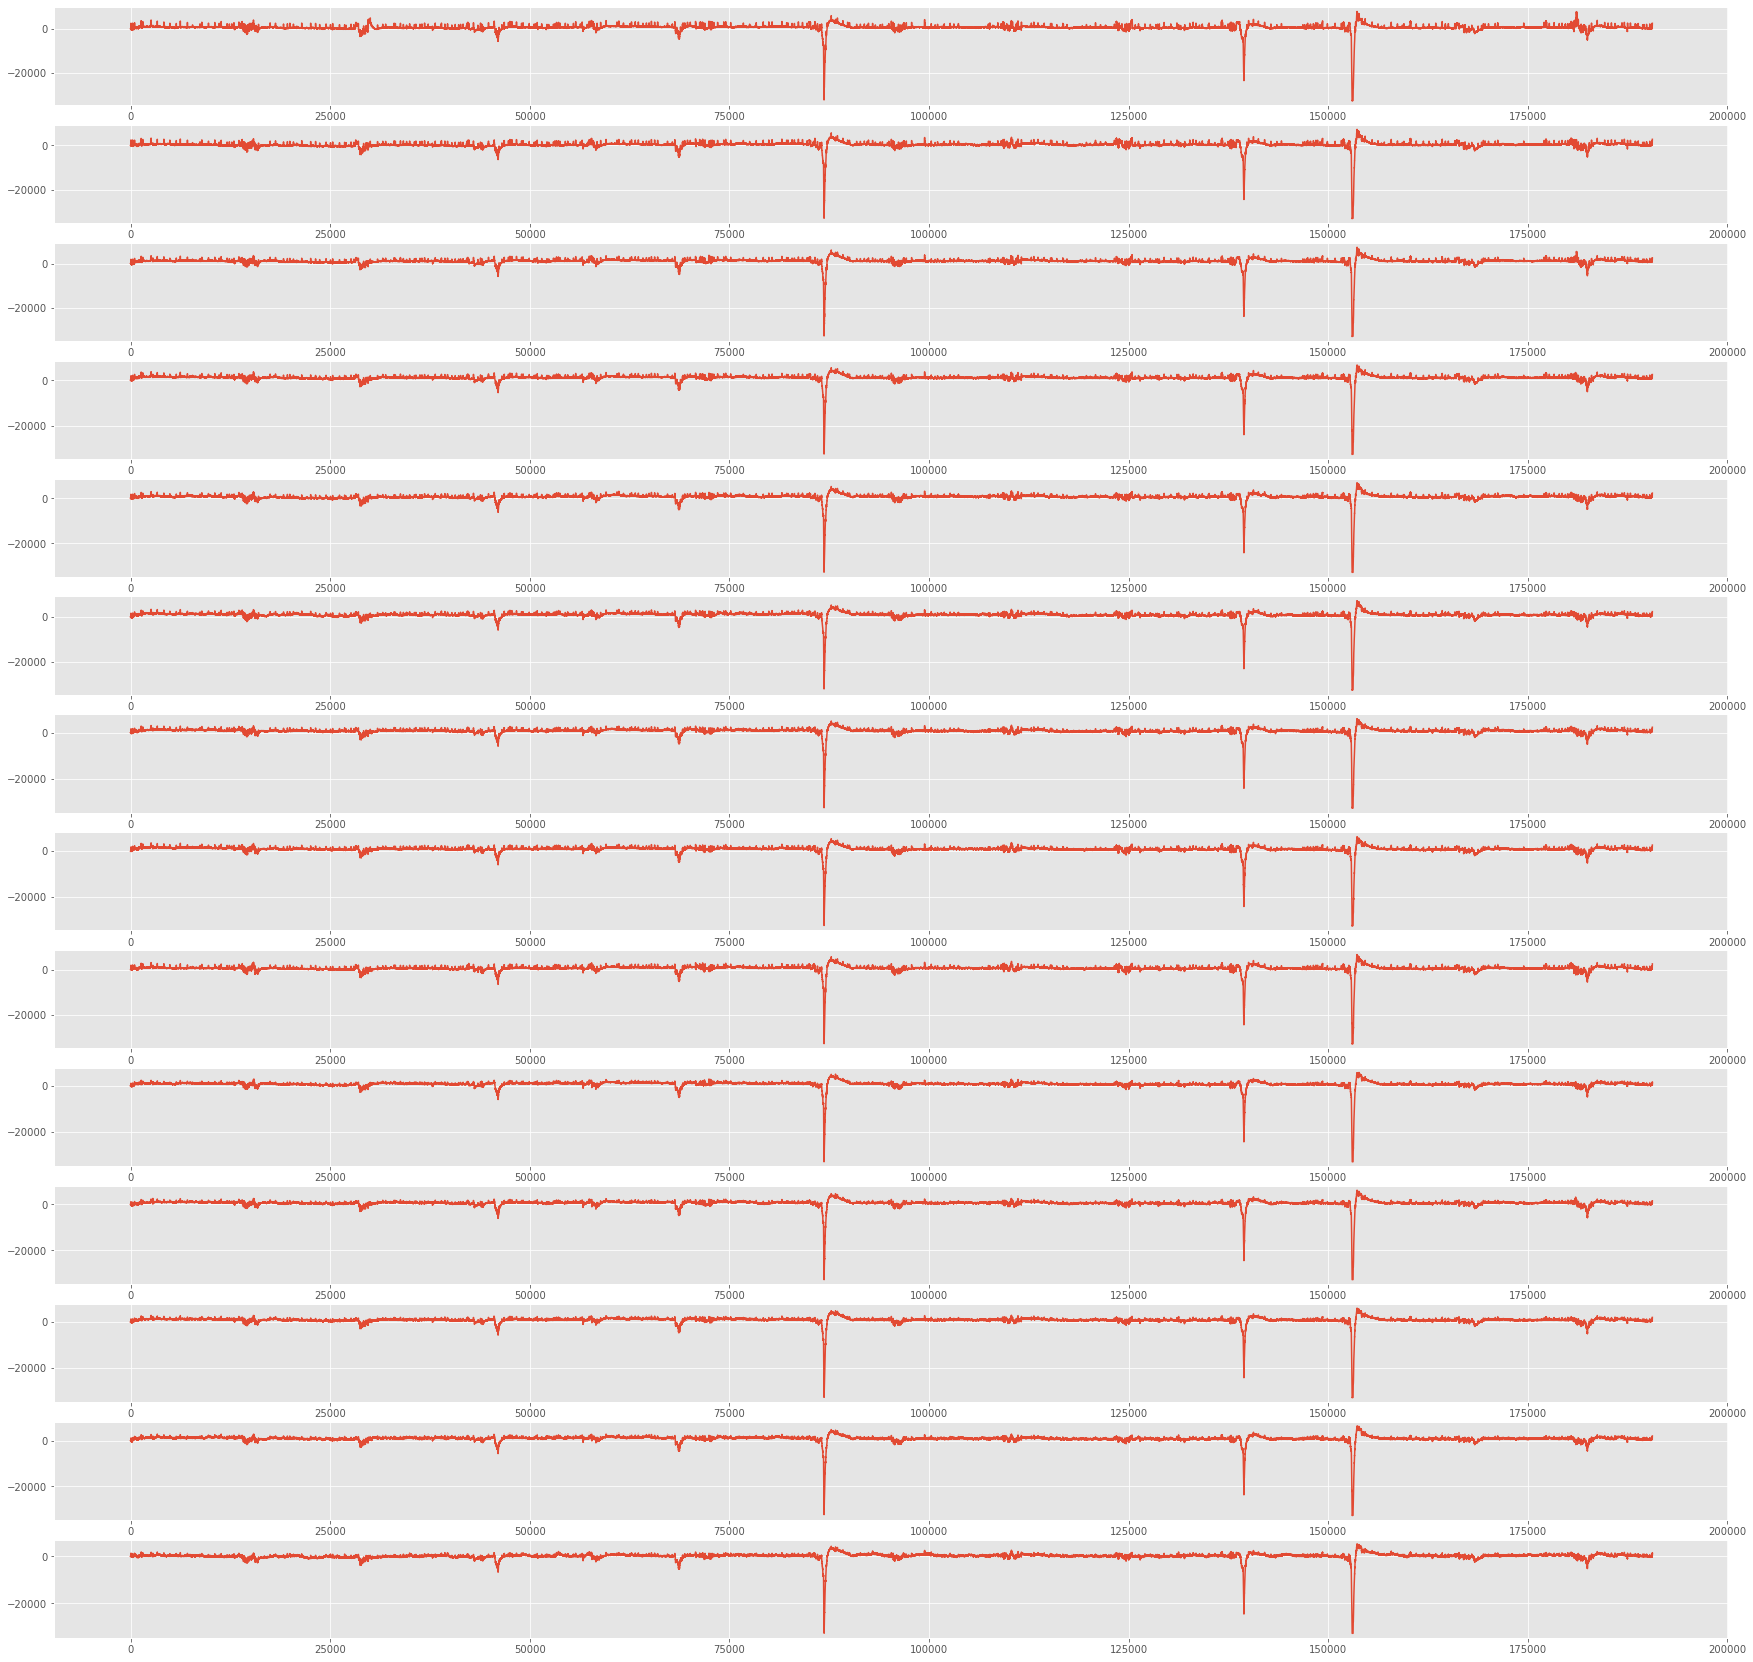

In [18]:
fig, axs = plt.subplots(14, 1, figsize=(30,30))
for i, ax in enumerate(fig.axes):
    ax.plot(df.iloc[:,i])
    #ax.set_xticks([])
    #ax.set_yticks([])
plt.show()

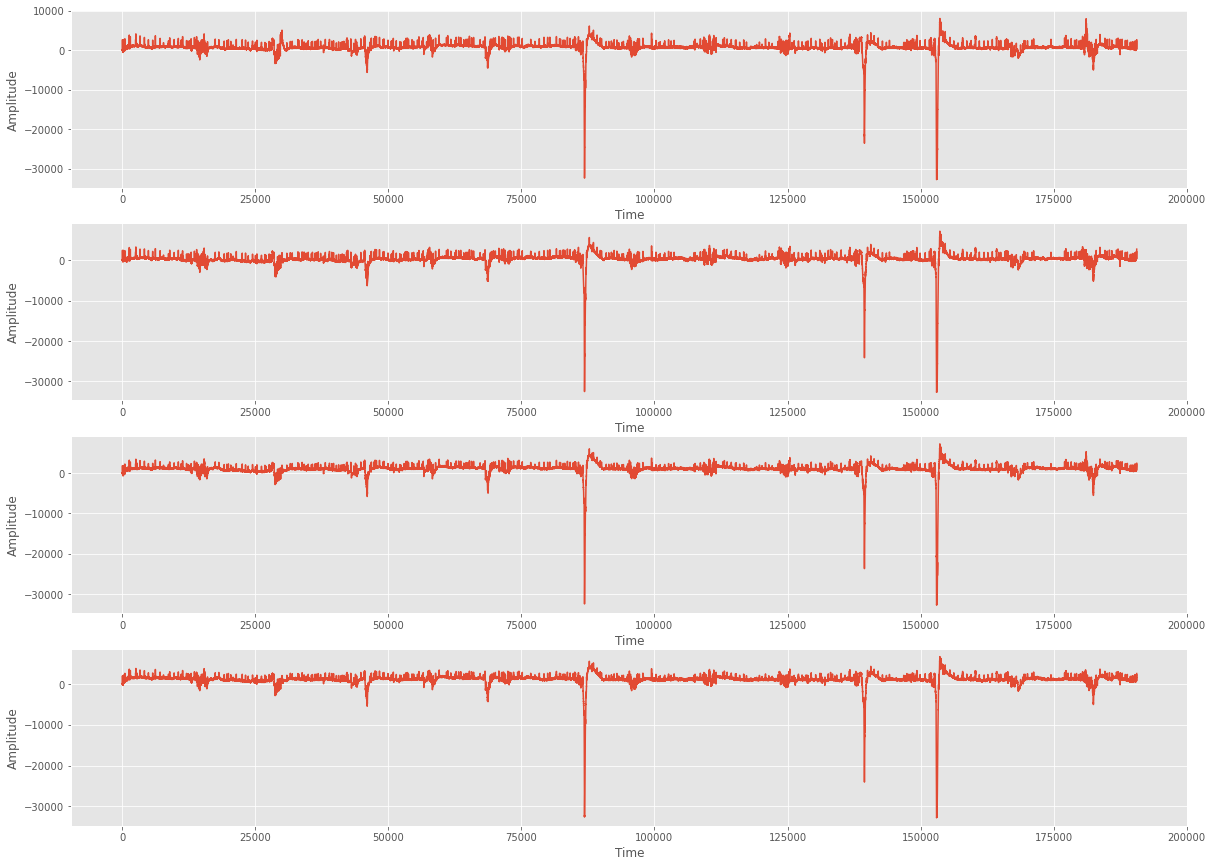

In [19]:
fig, axs = plt.subplots(4, 1, figsize=(20,15))

for i, ax in enumerate(fig.axes):
    ax.plot(df.iloc[:,i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

#ax.set_xticks([])
#ax.set_yticks([])
plt.show()

In [20]:
snippet = df.iloc[:127,i]

(63,)


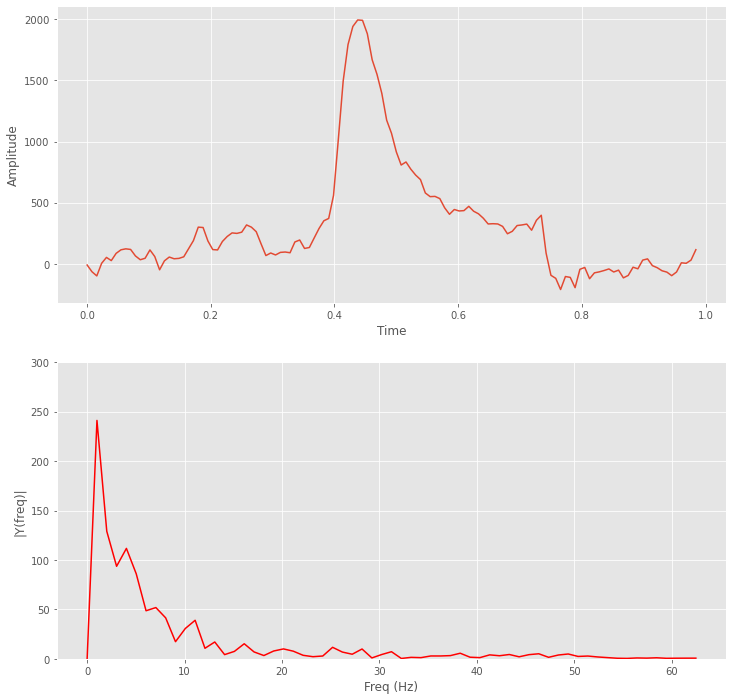

In [24]:
def plot_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    print(Y.shape)
    #Added in: (To remove bias.)
    Y[0] = 0

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(t,y)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')
    ax[1].set_ylim(0, 300)
    ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
    ax[1].set_xlabel('Freq (Hz)')
    ax[1].set_ylabel('|Y(freq)|');

plot_fft(snippet)
#plot_url = plt.plot_mpl(fig, filename='mpl-basic-fft')

(500,)


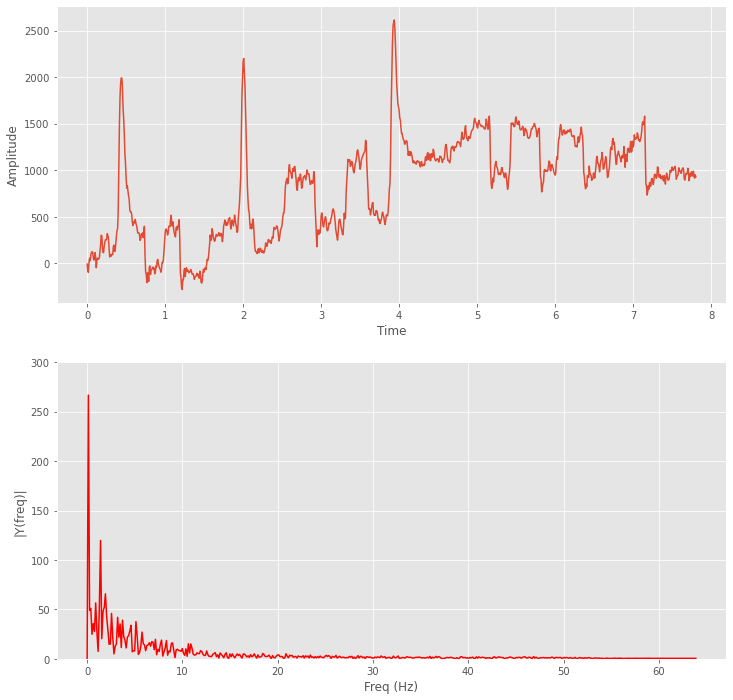

In [25]:
snippet = df.iloc[:1000,i]
plot_fft(snippet)

(500,)


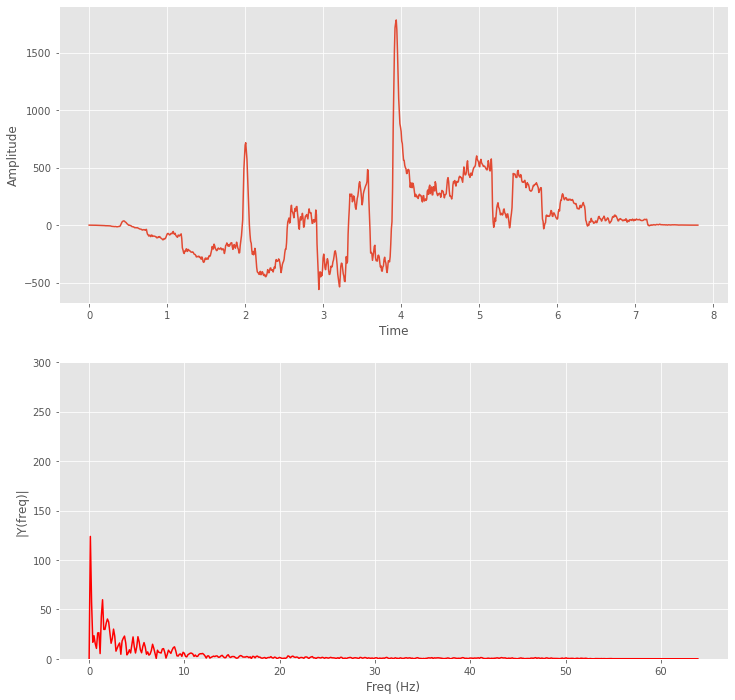

In [26]:

#Subtracting the mean and applying a hanning window.
snippet = df.iloc[:1000,i]
snippet = snippet - np.mean(snippet)
np.hanning(len(snippet))
plot_fft(np.hanning(len(snippet))*snippet)

(63,)


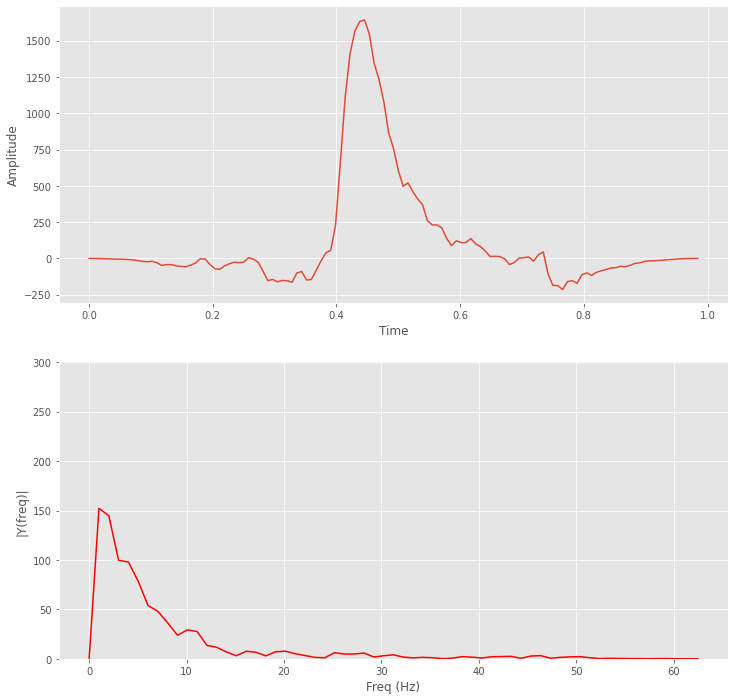

In [27]:
#Subtracting the mean and applying a hanning window.
snippet = df.iloc[:127,i]
snippet = snippet - np.mean(snippet)
np.hanning(len(snippet))
plot_fft(np.hanning(len(snippet))*snippet)

(250,)


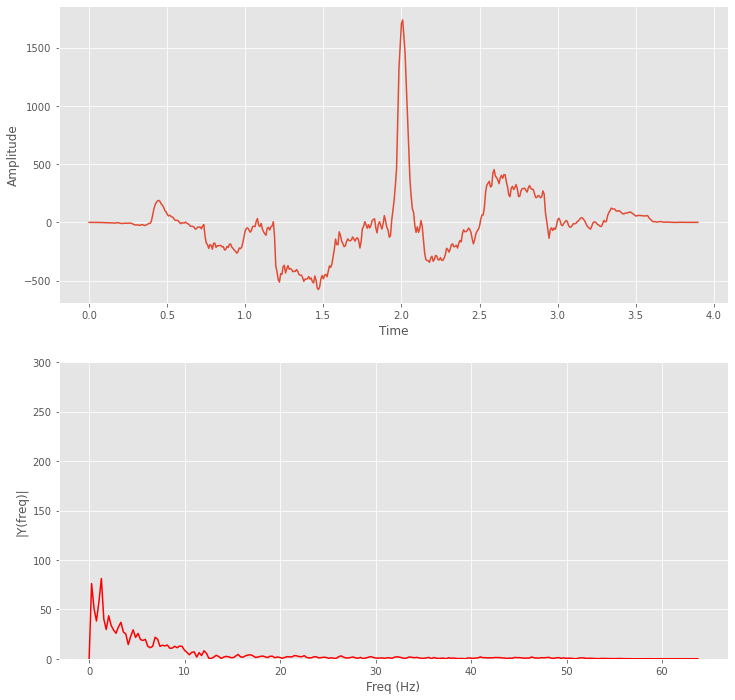

In [28]:
#Subtracting the mean and applying a hanning window.
snippet = df.iloc[0:500,i]
snippet = snippet - np.mean(snippet)
np.hanning(len(snippet))
plot_fft(np.hanning(len(snippet))*snippet)

(250,)


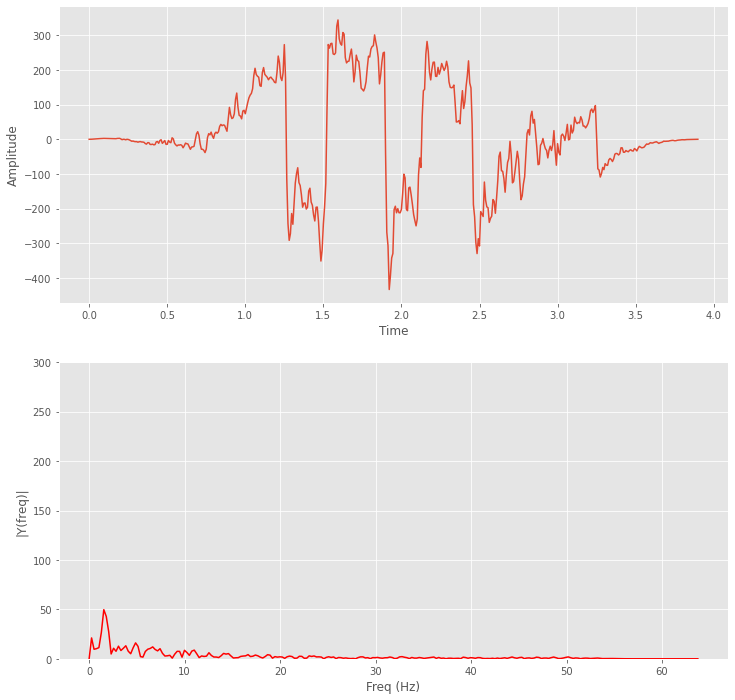

In [30]:
#Subtracting the mean and applying a hanning window.
snippet = df.iloc[500:1000,i]
snippet = snippet - np.mean(snippet)
np.hanning(len(snippet))
plot_fft(np.hanning(len(snippet))*snippet)

In [31]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)

In [32]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [33]:
f.shape

(250,)

In [34]:
Y[(f>theta[0]) & (f<=theta[1])].mean()

8.27069866084274

In [35]:
f[(f>theta[0]) & (f<=theta[1])]

array([4.096, 4.352, 4.608, 4.864, 5.12 , 5.376, 5.632, 5.888, 6.144,
       6.4  , 6.656, 6.912, 7.168, 7.424, 7.68 , 7.936])

In [36]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [37]:
theta, alpha, beta = theta_alpha_beta_averages(f,Y)

In [38]:
theta, alpha, beta

(8.27069866084274, 4.855610957067599, 1.5997779983307583)

In [39]:
snippet = df.iloc[:1000,i]
f,Y = get_fft(np.hanning(len(snippet))*snippet)
theta, alpha, beta = theta_alpha_beta_averages(f,Y)
theta, alpha, beta

(9.589563247260159, 5.084027096581656, 1.1271370657929463)

In [40]:
snippet = df.iloc[500:1000,i]
f,Y = get_fft(np.hanning(len(snippet))*snippet)
theta, alpha, beta = theta_alpha_beta_averages(f,Y)
theta, alpha, beta

(8.270747095931512, 4.8557767142076225, 1.599779840619251)

In [41]:
snippet = df.iloc[750:1000,i]
f,Y = get_fft(np.hanning(len(snippet))*snippet)
theta, alpha, beta = theta_alpha_beta_averages(f,Y)
theta, alpha, beta

(10.194377391433283, 6.71524647593839, 2.673776100754677)

In [42]:
snippet = df.iloc[1750:1900,i]
f,Y = get_fft(np.hanning(len(snippet))*snippet)
theta, alpha, beta = theta_alpha_beta_averages(f,Y)
theta, alpha, beta

(2.479570386190402, 4.863960165827226, 1.8766393724365762)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190594 entries, 0 to 190593
Data columns (total 59 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       190594 non-null  int16
 1   1       190594 non-null  int16
 2   2       190594 non-null  int16
 3   3       190594 non-null  int16
 4   4       190594 non-null  int16
 5   5       190594 non-null  int16
 6   6       190594 non-null  int16
 7   7       190594 non-null  int16
 8   8       190594 non-null  int16
 9   9       190594 non-null  int16
 10  10      190594 non-null  int16
 11  11      190594 non-null  int16
 12  12      190594 non-null  int16
 13  13      190594 non-null  int16
 14  14      190594 non-null  int16
 15  15      190594 non-null  int16
 16  16      190594 non-null  int16
 17  17      190594 non-null  int16
 18  18      190594 non-null  int16
 19  19      190594 non-null  int16
 20  20      190594 non-null  int16
 21  21      190594 non-null  int16
 22  22      190594 non-n

In [53]:

def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = np.arange(0,len(df),frame_length)
    #print(steps)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            #print(1)
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i-1]:steps[i]-1,int(channel)])
                print(i, channel)
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                print (theta, alpha, beta)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

X = make_frames(df,1)

1 0
85.9513615174531 36.207936652762385 6.336563915299577
1 1
76.06180793318157 30.689163557947303 5.960088764845225
1 2
61.494176654722516 26.59416454639182 5.248097291676651
1 3
57.12808260512208 24.538715342468194 5.961038005406391
1 4
53.3438996325951 22.93289349451569 5.425563853602499
1 5
53.030698693242286 22.073165352261338 5.404986443261822
1 6
50.9215522783303 21.131070801811383 5.291336953534447
1 7
52.312558177687116 20.971256581986747 5.490030675114001
1 8
55.202103900877454 21.468621096772047 5.527963176342057
1 9
30.469407673063223 17.340134155873862 7.323409335925846
1 10
37.3917761459993 20.56966456375559 7.474988987956222
1 11
37.54035780970313 18.25293200661215 5.909344831625715
1 12
35.882771850252944 18.22187603125308 6.058826083161463
1 13
36.05332475511689 17.019656400203363 5.5214061549630715
1 14
34.13026492761168 16.528657668150252 5.4462729973625
1 15
32.27875066276549 15.961731420888626 6.441621883285808
1 16
23.630532226459643 15.466722175516608 8.554793899

7 1
22.16815948510574 19.403984582561407 7.072064521608096
7 2
19.07111802745613 14.407395916421763 4.390845324086621
7 3
21.431754265720304 15.667582293586175 5.16663942874401
7 4
21.208347455614177 16.746187369622188 5.487516165278377
7 5
20.09233690984216 16.254540731964948 5.3403345554899575
7 6
22.552498359738884 18.25389344776188 6.468120878865059
7 7
23.096229002032935 20.205558797123395 6.986222921709447
7 8
23.715208855218393 18.89104575231318 7.006072437745755
7 9
15.63640997588132 12.721623585894289 4.970134154038411
7 10
18.07611887686499 14.663419914673723 5.277301576338031
7 11
21.007964351199732 16.660085264455905 5.588342918203369
7 12
20.22713955203308 16.73588997868121 5.814160479334603
7 13
20.052985479325002 17.0438079041971 5.625001567780503
7 14
19.814649801059485 16.385358818524164 5.8148857895996
7 15
19.956801640158076 16.547526316544012 5.896786457324951
7 16
15.618045819574892 13.92369093052996 5.590414802371056
7 17
16.99421100114096 14.054694725850789 5.247

20.582717780899664 30.831567717352588 11.981959669149713
13 0
30.08958592549736 22.638076240516043 10.115061841408155
13 1
32.596299777106616 19.268877453650433 9.91041224382593
13 2
20.260953982514955 16.376019212913132 6.954838492675621
13 3
23.81630288705731 19.082952680181922 8.054707523974475
13 4
20.415132454981148 16.672488261969814 7.243066650509667
13 5
20.377830483071016 15.358851241853094 6.984493272399924
13 6
24.718741160291295 16.15008391582415 7.97864900949708
13 7
25.77422374459974 15.37508631281144 7.947669068134307
13 8
25.984004651143636 14.614471554263721 7.693413830053275
13 9
12.705024530938674 13.302248801183776 5.654999436500148
13 10
17.27216906416776 15.33430895700626 6.582087872258064
13 11
19.86992421127534 16.402387326150677 7.013970310956447
13 12
21.592507381569927 16.613183632846848 7.258786036703424
13 13
23.113574064987326 15.473187547822057 7.396917008579618
13 14
17.230242310103282 11.135069226254046 6.370687233523786
13 15
17.91935989638767 9.964181

18 52
9.76901873729549 11.797343803916984 4.86997791669239
18 53
7.875716548588517 10.545195634509065 5.530483560623435
18 54
6.883920944311626 9.898124702263708 6.411672158286878
18 55
11.546193685760782 15.102072409232036 6.24625986357089
18 56
9.485928038471016 12.645313615170538 5.74619295490561
18 57
13.585861055540141 15.469458201434955 7.210467445311901
18 58
12.222390132955901 12.450865634059808 7.711532958198175
19 0
5.443739565742677 8.328553277041301 3.238428437697251
19 1
6.60256818105484 8.75719691435216 3.009204162208048
19 2
5.6185900606933075 9.136526740761834 4.098824615157777
19 3
7.445564634509658 9.871058780830865 4.280406758195413
19 4
8.986258493796843 10.487021488157668 3.9214211741521514
19 5
10.063845153252462 10.002905786039882 3.733596720419628
19 6
9.848743061484585 10.10094661797719 3.6365370060744886
19 7
9.214208291376785 10.55143956388644 3.4658554884352695
19 8
7.91083374700713 8.826563450132072 3.459492998086503
19 9
6.595894437855643 8.277519648315167

10.816349215391616 15.656607741660686 8.92184936316628
24 45
11.964609220017232 17.968834438070612 8.851651123473221
24 46
13.731274928685453 21.69630829517739 9.45818255883037
24 47
11.440218725161515 18.11733648199871 8.605409554024241
24 48
6.616027766610153 10.785101968014711 7.5575636394850845
24 49
7.165805292733153 14.07473321049341 8.072452489505036
24 50
9.099421136592353 18.202030430690833 8.930448306847333
24 51
11.021579907534674 21.55045959751515 9.705069343190042
24 52
12.359794058891135 22.699093164846524 9.760592460256897
24 53
13.019568314154245 24.728641964262728 9.687595311841221
24 54
12.695455358072778 22.83975917957986 9.027942502713207
24 55
7.878228045361539 18.9861827642054 9.672989889085445
24 56
11.794280565274569 23.497369462471237 9.865193568889499
24 57
7.364145721964381 14.029866718660053 8.640786336808866
24 58
13.63904857807609 22.124655064018718 10.126740949700537
25 0
7.622891924772145 6.657839158935577 4.05760907497891
25 1
6.9541628055474 9.00643433

10.862890249843689 9.728962266392108 4.685450673474177
30 44
12.920935429753943 9.216540071312883 5.04451524473621
30 45
12.06056672400426 7.9440601668238715 4.845680331227185
30 46
10.97237444274966 7.370858857004775 4.906050903250197
30 47
8.469297450389877 6.9731795933382115 5.371350592754715
30 48
9.06037129463811 9.372211626721644 4.554532627199412
30 49
10.382624844627005 9.24449220401074 4.504721678549838
30 50
10.438612091852246 8.909093225426384 4.692873083283397
30 51
11.364985460177476 7.630076131650248 4.943475839221924
30 52
11.923223890162456 6.254776594854455 5.051148199821895
30 53
10.614789615217713 5.5938947227512 5.173900951002756
30 54
10.616308576901549 5.236676614875444 4.96196640784994
30 55
10.938436531740187 7.149270762337052 5.627354283841358
30 56
12.29386040660774 6.267184535848723 5.726639163933567
30 57
13.720221497011762 6.565409324020491 7.3074898286919066
30 58
15.035763250889572 8.823044112058675 7.348608563032731
31 0
3.791144373917241 5.2517715103510

15.07048157818819 18.523504292173953 5.953053051177414
36 38
14.821115006834606 19.9796316756476 6.50606647703105
36 39
15.293931580697386 19.236708409470644 6.276275571501945
36 40
13.888841184191493 15.177512459478702 5.751354703216555
36 41
8.623233251452731 8.305584136957311 4.670816538874431
36 42
10.024669253815572 11.595425916691138 5.281985579869003
36 43
11.109538534895997 15.975349951484864 5.827942256278926
36 44
13.172673980908883 18.520941744293133 6.451652385449623
36 45
15.13445214080532 21.10529156871557 6.808039368930722
36 46
15.588120762480246 24.22345282476732 7.6589061511535546
36 47
15.347155068788446 19.560522029848777 6.236692611557319
36 48
9.825710158546071 11.27150281986248 5.882748936733404
36 49
10.310014969552803 14.207637474208308 6.171010736441757
36 50
11.693606189523514 18.09299070794635 6.9298977520792695
36 51
13.370862131286003 22.128831537193754 7.319842293722178
36 52
13.332419627262855 23.700593810561415 8.013428152817278
36 53
15.021130391549878

12.680852616568236 8.475892920238579 6.488893958056758
42 22
9.977551766476912 6.980374440459686 5.765989623350721
42 23
7.758197861378035 6.411779505658763 5.03954703792882
42 24
6.576552951188299 9.429051257034512 7.178446982972894
42 25
6.332413997902128 10.17367206879035 6.739397359340165
42 26
8.978608904392475 9.478717286260189 7.05122019102813
42 27
13.922381438189497 10.542635898384503 6.994158465987892
42 28
13.464689077391782 10.043880037102598 6.981730108979197
42 29
12.809412838070326 7.900259832480623 6.925503867136195
42 30
11.636855680562089 8.76466251839167 6.445767448295613
42 31
9.95682711286073 7.628814727889804 5.4894142762122575
42 32
9.111158318799701 8.53845768112431 5.448005007754703
42 33
11.65583042792349 9.518226707468507 6.989071756357572
42 34
7.846608015879488 9.124814236153364 7.8922370017688595
42 35
12.512447268900642 10.278140423863645 7.966520565042271
42 36
14.916653433452145 9.756788816291147 7.350437677979445
42 37
15.870273807800839 9.029901990954

47 50
6.384189416206321 8.992253501127966 7.332704048052676
47 51
6.492705012776177 8.87379442928603 7.750163660832785
47 52
7.731357688734399 8.173235304668296 7.917218378466056
47 53
8.176118104263175 9.445028701409454 8.316699030161542
47 54
10.810954597217766 13.227666533180956 8.160970152760546
47 55
6.830507235866356 9.322565751728899 8.858279720514716
47 56
9.771918657025868 12.399533430306828 8.184678164528409
47 57
7.303874803390569 10.524002742543715 10.567733457894816
47 58
13.12018455266636 16.76200821545379 8.632440249326168
48 0
6.177784346887278 9.81287448578583 3.153895357368122
48 1
10.287973753879568 8.429655395346883 3.8641038720577305
48 2
8.58786367665347 12.189784208359564 3.6568066159418358
48 3
8.150168693693056 11.016397531650233 3.4611338353357755
48 4
7.804837879276376 10.352447401311746 3.8277684955558158
48 5
9.970820383255557 10.49979904972949 4.080542303295548
48 6
11.601141675410865 9.740852346444004 4.457398800422507
48 7
10.507435609044148 9.6251567899

12.466246252709425 8.738837186385004 6.1347688690540005
53 37
12.734924998844027 8.87809187838948 6.827886144096634
53 38
12.86178913547355 7.438846584959825 7.419746594062549
53 39
11.584610628685471 6.149729184744516 6.964185761924353
53 40
9.25429223602245 7.028118120853147 5.751531589476327
53 41
11.044906558008496 7.520563915450775 4.7334680876880695
53 42
13.545807636268494 7.852834794815369 5.032816083700664
53 43
12.830464593508637 8.216524312578843 5.710336059518366
53 44
12.956413177222277 7.7892845644388204 6.5040511385931525
53 45
13.19561653191919 7.297460578062331 7.232463013842168
53 46
13.265796730417838 7.271850049491067 7.754844988549253
53 47
11.221364382347728 6.59025541293593 6.589745175805386
53 48
12.650033575166958 9.013347915859335 5.484498715811343
53 49
13.676086730202325 8.825907722659155 6.05047030347823
53 50
13.646659477250031 8.79666153761602 6.489147003730831
53 51
13.220784084698451 8.586960742703454 6.878239876709793
53 52
13.700826407577862 9.3993739

18.33197308730397 16.79221613341479 5.967283859160385
59 15
14.016202866701953 17.08009673575409 5.349424054549575
59 16
7.498258690263265 11.041617695438504 3.9199337889358055
59 17
13.690153965372685 11.304520155314167 4.5079366942272
59 18
17.24503113295273 12.539617933437889 5.666801220770384
59 19
16.678784774238494 12.954037995641823 6.31303577677184
59 20
13.948869431901723 12.709153944676661 6.71171691798983
59 21
18.68836892526001 17.217477275903498 6.640367846952706
59 22
18.176132008984226 20.506457257505634 6.212075315490233
59 23
14.097257857263042 19.006157837870397 5.40833266824085
59 24
7.259576599425259 10.625466189062307 4.340524575863273
59 25
12.848830132633747 11.120923098886891 4.706234134410609
59 26
14.686948044194281 11.977139693483375 5.030991551397565
59 27
16.327901617258007 13.54071265395108 6.352492704169457
59 28
14.2193035879753 13.540720947320832 6.849629990167033
59 29
18.77388903779466 16.36785352665469 7.0601481729012106
59 30
18.3406237923214 22.191

19.045075226598016 26.58314032529039 8.98513563037667
64 50
22.30863459976413 29.69370734803259 9.646466732785246
64 51
23.109348344420205 33.6061794366211 10.007773693911671
64 52
21.522441698527338 36.64271998740046 10.063375094380472
64 53
20.593014658487853 36.73547089364135 10.438198970991133
64 54
18.68888729008225 33.77556215821675 10.303258715379844
64 55
19.296819114565622 29.346783904958457 10.869018802410025
64 56
20.535144337481857 33.172438934643125 11.431406073592525
64 57
14.967750748316154 28.16265345178249 10.449726732008347
64 58
21.329768591997123 29.842821666972586 12.185183124079744
65 0
5.818258449756403 5.584322565766524 3.6787404328580813
65 1
9.477293028304189 6.655508177765752 3.6543439338127177
65 2
4.85421765269358 5.3904328648777025 3.3171466083243493
65 3
7.940429663600177 6.518697166040491 4.560132623140072
65 4
8.164754806602184 7.486099644660753 4.522772676489014
65 5
10.252141383605476 8.126231709255316 4.688289581373176
65 6
9.835711358853752 8.232459

21.47229165851228 20.076997930928428 5.336124890010116
70 24
13.896527448424138 12.496456849690567 4.222048419246168
70 25
13.625463917301602 14.752219828266968 3.8706145766987654
70 26
16.10083961090747 15.58288560928473 4.216969487410985
70 27
18.207187562535033 19.111624544157785 4.617744281737033
70 28
19.346554435878765 20.781858660625048 5.028294429959402
70 29
19.709341306272695 21.285390937865856 5.523037118336097
70 30
20.661718003835325 24.696328736527416 6.165410146621233
70 31
20.823641144850335 25.70649254868721 6.108481050772113
70 32
18.86253545993416 22.758833722707706 5.752822586800524
70 33
12.147273859916757 14.919012408664502 3.893174003567014
70 34
13.795550251253616 15.847468108303392 4.229099390328723
70 35
17.34502466596992 19.4126261503647 4.945722002935207
70 36
18.559799154300656 22.123575601855595 5.394822674453062
70 37
19.612787671219852 23.603629551939687 5.713691482872272
70 38
20.293928667315928 25.708108253065824 6.6656598074689315
70 39
19.97928149148

76 29
19.71786378003752 12.342106933431527 7.16994262848564
76 30
15.639301399988378 10.450352276394398 6.8337905663624365
76 31
12.008646315962723 8.184725171197975 5.9042264728015335
76 32
10.852737674241636 5.28039829492751 4.982865415072662
76 33
9.749461293718891 9.545954013806742 5.039090247237341
76 34
12.660565947156456 10.40927105753012 5.025609078836854
76 35
17.423609198693164 11.481342229623536 5.9958780899766335
76 36
19.052413955055616 13.090976530152352 7.019241389943671
76 37
20.585298078400527 14.245634353691203 7.6748908053259575
76 38
18.287718443196187 13.513048160392602 7.669754570082473
76 39
14.934629697896915 11.471546202113856 7.043248347412849
76 40
11.868595742747244 7.961861927419632 6.058318790785157
76 41
12.64722284789251 10.183138417410527 5.134053851643642
76 42
17.762093947987523 11.503518117276894 6.006889837232876
76 43
19.417329471200716 13.979988261566845 7.23218578803018
76 44
21.82488646237093 16.663129858005483 8.479300191386871
76 45
19.8545324

12.03342853192957 14.096631407845175 6.644381593110063
81 52
9.802096679237753 13.342234991015568 6.664268538316483
81 53
9.354532269991312 13.773397762388356 6.663202873024198
81 54
8.585312857542801 15.374256559953384 6.926912688160458
81 55
10.85340289475556 14.842224813118797 7.683646008450276
81 56
9.186884642703447 17.919296505781148 7.26447814076068
81 57
7.8867134032707735 17.916027815140914 8.297241536167075
81 58
8.365389771246008 23.53568141189252 9.144622433278299
82 0
8.432569664496862 9.800186789181822 3.179546617768703
82 1
7.1243046846518805 10.38321980841812 3.9431761312852065
82 2
7.457082791889789 7.5687735086285475 2.775903058187944
82 3
9.475872525471033 11.816549270632963 3.51276363442292
82 4
9.047251024252008 13.544561697895364 3.9286319247331956
82 5
10.557041638720547 14.523608033590003 3.8645711293596405
82 6
9.18516840404413 14.844585698545705 3.9939455365584324
82 7
8.27616824408952 13.957368104619146 4.1167670340257
82 8
8.795320254171727 11.36116476959558

17.45108554123571 11.439661801299367 4.396453860869215
87 35
19.331503516789887 13.089053590304317 5.471904345923738
87 36
18.195208151408618 14.761219197603129 6.423679940371806
87 37
18.216936207484682 14.99065968551676 6.618997780920244
87 38
17.548357463087708 16.973763302442965 6.590433833276305
87 39
15.803868363759422 18.203565084474473 6.529631867967787
87 40
13.285738677979445 13.82362332126933 6.4085718252510375
87 41
16.734600283538377 11.726038820721254 4.677261814175551
87 42
19.012694983660474 14.457040348735775 5.131614529648384
87 43
17.908907429785604 16.71121967094764 6.39045721593864
87 44
17.905714957994494 16.715202314028254 6.8207715554759725
87 45
17.915119913883117 17.775615373868213 6.801886271164008
87 46
18.99923730149737 21.151624062798618 7.2556354190158485
87 47
15.471721039767443 18.063125005083645 6.794679162065968
87 48
16.368531745292593 13.579746282209651 5.821505011320824
87 49
18.175888977448082 16.34986865152698 6.172018298777835
87 50
17.523731298

10.743274085598616 13.773879932339437 5.729898630910404
93 15
10.90704203522943 8.995767547404192 4.924315433758257
93 16
9.152588373418737 8.182619716088034 4.933691116052681
93 17
10.723658130491264 6.375796846546469 4.925501339093921
93 18
12.37640840387406 8.803277786218569 5.884637426048369
93 19
12.96887160633129 11.83543117654982 6.402884331218779
93 20
12.097964872898803 14.324257544007278 6.9324718993011185
93 21
12.172472668607647 14.100235093746313 6.157559716891166
93 22
12.417503905959201 9.610768932377091 5.613006026224442
93 23
12.069160931087351 8.048532849448806 4.300734035568426
93 24
10.940798044022877 11.380134137816114 5.063895444402371
93 25
11.922145867367647 8.091585275551576 5.051404012168385
93 26
11.757648855353843 7.5922455985133475 5.34385145702943
93 27
13.60468018138437 11.2314908507996 6.307165309932095
93 28
12.578391922121455 12.142854028055396 6.690595133051045
93 29
13.969043300959736 14.091718637881847 6.254626226398675
93 30
14.004732998124808 11.3

15.656028199821984 27.589829420164783 9.118374614868255
98 55
13.000782589308344 13.412884997798667 8.961852305760257
98 56
13.594462433401713 20.83614456883516 9.589655882249662
98 57
16.521376517764505 10.210340997581998 9.129167751619045
98 58
17.852320347500076 18.144556826335876 9.80882949242732
99 0
6.616634435199009 11.978040735734398 3.838255931400279
99 1
12.540082115486767 11.167042484852338 4.0945064260598745
99 2
10.072860408286964 10.174318180012811 4.0164252217117555
99 3
10.842772330452405 13.46552025245585 4.427465529759092
99 4
11.931620139707293 14.502016839488835 4.677057208869086
99 5
14.379795762195535 14.478890517914014 4.850935138725172
99 6
16.69668474992454 13.768786890425464 4.915004169647712
99 7
18.24776577908012 12.446662948060487 4.747925822226712
99 8
15.537069536745557 10.764090974841139 4.3956604501147485
99 9
12.121944016480981 9.452628708986696 4.356930117610192
99 10
11.090259807488906 13.536112238786911 5.086139269676548
99 11
12.763366819357525 16.

13.452880674057177 13.222095324707329 7.10184698929246
104 50
14.452096106910377 11.191098579799146 7.028812493349707
104 51
15.080032989364602 8.579044736791793 6.716258536978009
104 52
12.941172448545625 8.318946654022009 6.382545346324102
104 53
10.55159079823599 8.525183897909653 6.3199294053512505
104 54
9.57456041230268 8.356716752599793 6.279054574032714
104 55
15.792882586746527 11.846739439225372 8.148370259223357
104 56
14.461770730310851 8.944857563038337 7.228348204646068
104 57
13.07433125998754 16.844539010038027 9.713940681818793
104 58
13.013747903277764 13.785553010904637 9.485643582384508
105 0
9.497549106763515 15.314289249273317 4.580556685570701
105 1
9.864685840303288 14.67025061618904 4.869136814791323
105 2
9.126650190594034 13.912849729300127 4.789797283449856
105 3
10.76470109744871 17.21897055879717 5.566608300000314
105 4
14.201478319641144 19.918926508338064 6.199766767451768
105 5
13.153189844478963 19.269097373198896 6.111899000398446
105 6
12.22338995017

28.854519427715324 10.048504874454744 6.792664171618768
110 23
26.181994233554434 6.276794338358956 6.230982850222931
110 24
21.45302879116221 11.068626209219289 7.646898254518139
110 25
25.85994828494438 13.100535917271571 7.80857437148434
110 26
27.64680738731374 11.160171728342752 7.6327660022742645
110 27
28.349564535231075 12.80133907910501 8.53272632660652
110 28
26.637701741919443 10.958583371419078 7.945465939064168
110 29
26.360538091664424 10.076300010650433 7.440323863196606
110 30
27.263174196555553 8.615469710956779 7.304629893924198
110 31
24.63275382199889 7.46870488457045 6.967367672303152
110 32
20.960626178800187 5.716187117358747 6.109752002243252
110 33
23.562165133514508 12.882418511218207 7.929833893101042
110 34
24.595465768333035 12.283146773222699 7.978583103428389
110 35
25.537258384406982 12.28478113552105 8.023376261240081
110 36
24.140829606133494 10.853423171975333 7.550040365161425
110 37
24.47808846731152 10.6230765732826 7.803834852718482
110 38
25.7731

46.82011921144618 19.290811791822957 8.894609666908599
116 6
46.51172652101992 19.173462410990012 8.831704881721631
116 7
45.143691617897545 20.568569939301145 7.385493779477522
116 8
45.764697388554524 22.800725045293095 6.254376555992956
116 9
33.635271200814316 22.622733290507828 8.61012480151486
116 10
36.42897457724016 20.08230323053064 9.090433159271225
116 11
35.44796550842167 17.56412700263393 9.547378876936781
116 12
36.36665359760606 15.409434985451709 9.814747172212071
116 13
37.48839179280218 15.90370399551599 9.439575659948764
116 14
33.51448445398992 14.972289195730632 8.143724826373106
116 15
27.054684063705068 15.30660450124842 6.41245111407478
116 16
29.82540681582872 22.076653895957566 8.898468692763997
116 17
29.843786489629608 21.12230485042817 8.778947051386009
116 18
31.443650374373256 18.896967468195356 9.352487460673705
116 19
27.806817330871006 17.09807349260797 9.075457172719243
116 20
29.54818163996513 16.355422400869216 9.01759231463437
116 21
30.75272928028

45.822549030773295 19.89056495453075 9.987373687569127
121 29
43.41670801401757 18.93174784399461 10.05662841911261
121 30
37.06944383260853 18.271576783231172 11.655319527636014
121 31
29.836509129492903 19.625370957186682 14.098406888029938
121 32
27.09865962555301 16.958597298893245 12.53092949625191
121 33
45.64104019311412 19.48677367571277 13.303343418369275
121 34
46.22554074832963 21.494534077292816 12.798657658393273
121 35
44.56774476257253 20.208150733483215 11.209487652187866
121 36
44.56350917294833 19.89309470370412 10.599173807833312
121 37
43.647654651440675 19.728459052528194 10.324007154731845
121 38
39.981326210711714 18.937390975751768 10.953269360074014
121 39
34.63213266629596 19.374559982583587 12.6626269766615
121 40
28.39188240167225 19.213146390203818 12.927411833584841
121 41
42.655214485086496 19.725881042100365 13.417845521631516
121 42
44.14072471572507 21.53354034716909 11.894664903404413
121 43
44.45426993850674 22.04609831982568 11.401301220973611
121 4

16.09014232650157 11.078380857124744 5.78155922921227
127 15
15.869579895339088 11.822888471008705 5.3306601148561565
127 16
24.72501340015432 14.529183560292461 7.987510581121774
127 17
20.967399094655548 14.523934285068664 7.882022459071124
127 18
19.311241984772142 14.571448742435843 7.527791486063391
127 19
12.566744036735525 10.84374615977684 6.107910149032201
127 20
14.085753475711051 11.533954575747513 6.226242789477912
127 21
15.43459075119824 10.976522488176908 6.112782410002099
127 22
15.499041687248592 10.732285353655408 6.124078357061123
127 23
16.78540443549866 12.277902481251857 6.423308579266795
127 24
26.71253145033687 14.311354193481414 8.31072207512494
127 25
21.715600149563837 12.74514723135838 7.921044514041098
127 26
20.508144435754424 14.4829610875353 8.043257028012345
127 27
17.20396847597012 13.599448204057403 7.393971258802949
127 28
14.582889998352808 13.701903133322556 7.117338585010002
127 29
12.012261902814021 11.637104744367676 5.931820243788796
127 30
15.

9.917063908877578 13.95409991709126 8.504915861115505
132 51
11.074422803294226 19.61829093103293 8.951401314744732
132 52
11.642908102626915 23.83051572927859 9.049737215848834
132 53
11.11745369994381 26.982465945441536 9.341895199323172
132 54
12.232239199484681 28.27942603624853 9.738206200330026
132 55
12.685647811018294 12.956328787821743 9.960023856855818
132 56
12.727047910794415 19.365797495231845 9.735120863690943
132 57
12.923162973145658 13.964830438635278 10.655212326603166
132 58
13.905531858589338 17.532296778512084 11.177202913783145
133 0
6.313004657738428 10.024382884891688 3.70851854218783
133 1
8.281165407802156 11.229766914585618 3.287036263660385
133 2
5.775557240050327 8.488007703388856 3.6796562570076543
133 3
7.788919543358227 10.744777513491027 3.9735521595149703
133 4
8.405757136228042 11.946752766726885 4.260042118424367
133 5
8.508187832934114 12.369074436231344 4.142589556734679
133 6
8.944816344730437 12.745525951649677 3.982505054823509
133 7
8.464031554

16.7319571227033 16.68800003672009 7.480177834854539
138 39
15.843342635496116 15.103774848198121 7.331516912248257
138 40
12.250519217494777 10.00141769282888 6.9444452693744045
138 41
8.407506028443118 9.071056306220367 5.488978069242251
138 42
11.420506318446744 12.43749709339449 6.984662368048288
138 43
15.237210767821308 16.51228258995613 7.4840262228781365
138 44
18.05297217680127 18.44040364935633 8.32074948500546
138 45
19.940978283302066 18.294532808824748 8.35097299809077
138 46
18.278709072990466 18.99033258747037 10.22748017038769
138 47
15.713864947318159 14.084165903930101 8.176959857222803
138 48
12.201022141516427 11.29197787437859 6.622596196292655
138 49
16.22131326637599 12.411425648628109 7.627146880678455
138 50
17.926261425819455 15.525122768084266 8.811263877514211
138 51
19.864493108228793 19.791689326628124 9.772156566379698
138 52
19.381065655645966 18.51648550778 10.202578922843674
138 53
17.86097351289465 18.874857947315764 10.595089538377831
138 54
15.91607

7.79827085291354 14.513152898360403 5.467443644558712
144 16
6.160167019886947 10.314912184763683 3.85797159137968
144 17
5.4434644218806225 10.963463114245167 4.788766223456009
144 18
5.617548139163377 12.251926232840805 5.42288446709441
144 19
9.042629615170737 15.391250548532017 6.071240234457968
144 20
8.41809590029565 16.56702045117584 6.42337907503768
144 21
10.1452064083991 19.517619590831146 6.637969631763158
144 22
8.672633943823095 19.59252694304585 6.4375151838338365
144 23
7.831366307756857 14.368936945064673 6.050436807985591
144 24
7.389778254449545 8.700815787862098 3.804568303659217
144 25
5.431848086475284 12.038780278222575 4.6038079420333125
144 26
5.399033385195073 11.03164536566321 5.428238486319694
144 27
7.257330303097672 14.916939284044062 6.168988689800568
144 28
10.521706211589704 17.437948316182784 6.479668360921141
144 29
8.200659342706842 20.407316632555517 7.164788454047773
144 30
9.912021443586887 24.04402799239937 7.6580381839428915
144 31
9.875635291285

10.521850071514903 22.89993354967863 9.089034618646354
149 56
11.142493278409207 24.133818359296644 9.106452306250238
149 57
12.99033172087114 14.856028353563087 10.030688926475703
149 58
15.587928325675918 18.693113627831778 11.5558195459289
150 0
51.769598453880796 15.607807478740506 3.3572814188013242
150 1
47.69334346003799 13.896705736019387 3.8709512539020094
150 2
36.63560764036501 11.843625831918361 2.899077433122607
150 3
34.235875187945325 10.688387148209362 3.7945864616529112
150 4
32.365989594165235 12.086317757467594 3.8107486535555877
150 5
31.724237190600604 12.417946371383726 4.097652017703177
150 6
31.281340859744418 12.35524995339915 4.259476383669229
150 7
32.988248554281874 12.541498694745787 3.9899693993454446
150 8
34.50142139219097 10.354283109402227 4.035721498411583
150 9
19.661098891702622 9.277859808627397 3.0795089760380328
150 10
21.865021833847475 9.780495054175809 3.9872962303673702
150 11
21.735156506811492 12.2599796468104 4.7555164979082845
150 12
21.5

6.851865171022139 6.333929698664171 5.267343569445311
155 25
7.972475908116007 6.938566830719292 4.966351766222507
155 26
8.94075544513785 7.64648396376053 5.060063564746595
155 27
10.977746282536677 8.968638788247134 5.6303684140289585
155 28
12.887917023708074 10.818960903090733 6.008085022977101
155 29
10.223704160214599 10.823589022655938 6.221091303927645
155 30
8.646653259933075 10.766215772546957 6.403910107913716
155 31
7.367273943129883 9.296405496122977 6.146370198215953
155 32
6.9962605628884695 7.6127840160736895 6.084233388476308
155 33
7.231162020234462 6.994063124617817 5.352523198047456
155 34
7.433842519396157 8.139701418891622 5.181955413154079
155 35
10.211624571986757 9.634596932584827 5.863209955875954
155 36
10.06508798811437 10.439588274358515 5.75467331568285
155 37
9.89359845248898 11.135463109840492 6.094435487653984
155 38
8.31831242217201 11.585672127764466 6.398111071602233
155 39
7.101920557183796 10.943373716088374 6.498102300562174
155 40
6.4533870641097

5.728157905444305 8.773479586040285 5.913430176628451
161 25
5.933390485865486 6.684579180601321 5.5608365482945326
161 26
6.736569632159726 8.975893423324171 5.659439261193164
161 27
10.691535957980918 16.592921992607856 5.8214047149238946
161 28
10.500407759121575 19.313030984364534 6.039313289147456
161 29
9.098604166046602 17.72179613780747 5.367756465046127
161 30
10.077549536261277 12.351661823491101 5.1108597485706975
161 31
10.113416698025798 7.351832000809463 4.743355242971
161 32
10.496767329794368 4.75705578905544 4.4043993062439615
161 33
5.953187357769573 7.892563839791434 6.0275159886457805
161 34
5.804401292051255 9.797430234318146 6.241947103344481
161 35
8.666740675346906 14.89624699573152 6.773216994611486
161 36
9.266942754136217 19.881134165625497 6.685388333706646
161 37
9.780375525325221 20.47531948300039 6.2124425587662655
161 38
10.904228449312235 16.545828473731362 5.6165958098583575
161 39
11.435386927787748 10.352182472274272 5.332361588465647
161 40
10.24753

8.777875888115815 5.97227408237251 4.150719239025189
167 4
7.980140157843365 7.706878100587233 4.217245819684071
167 5
7.326236659659454 6.641521445778759 4.378205409704353
167 6
6.801237273954447 5.77129747047052 4.488014447799466
167 7
6.140726973678077 4.423031211548034 3.9792318521146766
167 8
5.101955630500024 4.782586916545009 3.7909390482467678
167 9
9.837032763914365 10.505562077335224 4.8077296785588945
167 10
9.896212471928202 8.839568795311513 4.326297586382417
167 11
8.072389330806041 8.063830670083211 4.630628760648212
167 12
7.615515255908133 8.59702600969452 4.710055888057114
167 13
6.7355665564028815 6.352101921099891 5.58361391603426
167 14
5.860960883433427 6.132966055771562 4.487889241800657
167 15
4.439696323334842 6.968242823313652 3.5590657093118
167 16
8.479908297653006 14.266200904195493 5.680177120621453
167 17
9.091701046451407 12.788710763073805 5.030634552049043
167 18
7.841579796838342 9.871430000004239 5.238746046463119
167 19
6.45024385492936 7.9579888336

15.440589957945996 15.717171599670056 6.4204865955742605
172 37
16.906126208621686 15.628983130150043 6.461191649331539
172 38
17.024871542943504 13.827028733762639 6.2067152887043635
172 39
15.858084333122079 12.754712603293495 5.789186707431186
172 40
14.504213246490648 12.13362165714072 4.796247745989501
172 41
13.198932528032687 9.23694353465985 4.742494943223058
172 42
15.26429798475914 13.315314108672103 5.736475490789639
172 43
15.649725290141783 16.340306536723766 6.618060392582012
172 44
17.89622210544392 20.00555134987608 6.8873158921279565
172 45
17.810789615229716 17.758294202709862 6.82666920706115
172 46
17.618272141127147 19.36574956026187 7.370531241710763
172 47
16.194398270075204 15.841697418710723 5.809030567955031
172 48
14.478942601296442 15.011194633335247 6.216866182815371
172 49
15.701830541711047 18.577758519108514 6.8788016663118565
172 50
16.144601840256993 23.928709853293547 7.517361396063348
172 51
17.253945429357135 26.42082557539642 7.997886950411968
172 

9.344526248778784 15.625524068515935 4.384204132430955
178 11
9.495471033774574 15.669730591228442 4.54480295532371
178 12
14.228399039233725 14.601860647175485 5.093666987261047
178 13
10.62097998095583 13.549748323494448 4.518775703503601
178 14
8.814607567076274 10.474649520475797 4.676819657439642
178 15
5.87680782787997 8.334978218152225 4.1762549663691555
178 16
4.560543868633204 10.242365232867742 4.111015781629075
178 17
6.25997400047799 13.395706883484667 4.372828322263538
178 18
6.809040438589494 15.52293092683253 4.719505338504214
178 19
7.705807033022614 14.56827688999092 4.243780550854598
178 20
10.100712929524263 12.007560857762769 4.758293885593304
178 21
9.174015651892041 11.408356833776633 4.491706951181031
178 22
6.105172555082669 8.798056837121244 4.713989229071609
178 23
5.051935121870456 10.213781586438596 4.581775276074149
178 24
4.681377180385187 8.883389631015564 4.837480261941722
178 25
4.6520625070350645 11.660624957675571 4.790890913932267
178 26
5.8920255893

7.006139414030044 5.808222409762679 4.5230087501435445
184 11
7.092700857959654 5.565921389690012 4.842975351240763
184 12
7.6693185774484744 6.1032332201056025 5.277495758894161
184 13
8.748849258581387 7.406814988250354 4.888741877616667
184 14
8.363048300577308 9.496036136985591 5.015548396691073
184 15
7.076838702851045 11.728259012424553 4.697395298220139
184 16
6.084863568487587 6.434445161393523 4.205085485307323
184 17
6.995137345457366 5.37790201328276 4.78479130310536
184 18
6.890766660820577 5.253404276355109 4.786120546759315
184 19
9.548656408754656 5.748565813650371 5.122010210927336
184 20
8.880995719696678 6.595440285188425 5.466504069834186
184 21
9.995266308068501 10.116079824290168 5.61138222770463
184 22
8.458297579521124 15.985877207255095 5.61653250783435
184 23
7.452814469610644 16.841369264404527 5.381902857040921
184 24
6.371420922744509 7.0096357499554 4.9600490307183405
184 25
7.033959767224589 6.060854040894733 5.37305275327764
184 26
7.688782372486573 5.300

12.164013555751106 12.439111175485998 6.724305257000755
189 55
11.407545407975931 12.09284846653176 9.938493611273898
189 56
11.265497937648302 12.369154620915817 9.778032025131868
189 57
15.332064043949249 13.155653491152401 11.01494886081643
189 58
14.264876993388263 13.711373327393574 11.4270770112269
190 0
5.647504288818779 10.639925164712864 3.3670127781213344
190 1
5.34475181004465 10.42800194341607 3.3975654834967957
190 2
8.519557272943459 9.401491716244623 2.8971356475312047
190 3
8.509768994488798 11.83300004448557 3.4155761831143185
190 4
6.579690661642058 13.437425770083209 3.5021820385023106
190 5
5.320402195055542 13.74218806804342 3.8156638451763265
190 6
6.683286244585921 13.793536422723173 3.500748259706518
190 7
5.609568492538099 12.1193647775447 3.3414171030679287
190 8
5.629112327004447 9.625477735593545 3.1379241389067487
190 9
9.962461741965015 9.241853497815153 2.952650903700994
190 10
9.888162425257198 11.020780141377214 3.6449177775706216
190 11
6.1235319873425

195 16
10.62718915377359 18.562150404051106 5.800986454486115
195 17
12.509116602382505 15.989181701945974 5.1828247001099035
195 18
13.959495660061794 15.080517070392526 5.2790744747291525
195 19
14.107457551699898 18.357584483009084 6.328806003000861
195 20
15.341952276105225 19.68293325816578 7.8020322148278725
195 21
17.72878354902163 17.50344741996008 7.78415805972548
195 22
15.658575133155503 22.925982981116935 7.137125741654912
195 23
12.947778695838387 25.77629207436918 5.809660706263348
195 24
10.846309830244548 22.458925419202416 6.34062807871946
195 25
12.99830194271724 22.370016817236234 6.102146969471867
195 26
13.160998929185675 17.40048502185437 5.367399912518324
195 27
15.297272296110911 18.43484329201474 6.093361283736619
195 28
15.922249021681578 21.33656680153632 7.11004976593361
195 29
20.46220779999384 20.929018711857914 7.7715677270038
195 30
17.948292454763056 29.44366487526999 8.470267236823497
195 31
14.63894122665948 35.09071443263935 6.898732015392191
195 32


10.007109359952112 13.441634306950917 4.2828566093394596
201 4
10.163050468597977 15.297827628673847 4.936755308190371
201 5
12.920961277672177 15.451062079879259 5.296420242426536
201 6
10.987393698446512 13.389900178509752 5.516398914858174
201 7
8.85365575270368 9.141788780629229 5.241688928966923
201 8
6.4737846904201675 6.854472791064926 4.998753433167053
201 9
10.917184945908463 10.469054043847704 4.090075784612405
201 10
11.570544575202284 14.190104347274637 4.73765219751506
201 11
13.35863977522014 17.69939694814608 5.385352528326585
201 12
13.742713682964974 17.967407872947966 5.801290953635721
201 13
14.123199507989323 14.413525529797884 6.157683376350671
201 14
10.86248325760715 10.47835306260305 6.06404353659079
201 15
9.114107804650786 11.55988078295736 4.9255835926916465
201 16
10.816961522635733 15.229076983991128 4.2887079143054985
201 17
14.000582022038776 16.38939117169847 4.706082447898604
201 18
12.338394663224145 17.441340310895786 5.264903645527181
201 19
14.40050

206 48
29.49570988826827 33.099943191045504 7.073030929620766
206 49
34.953372724429485 32.57099847907811 7.4678806579284425
206 50
38.383962205819735 39.29375695367332 7.871445450440583
206 51
40.32988214285228 45.68961629457529 8.261945014784173
206 52
36.24606318216008 44.10088440974447 8.423641639442602
206 53
34.40784754981959 43.00276479510072 8.553736182658268
206 54
31.71534288429567 39.12929190655445 7.701162107840723
206 55
36.198580143266646 39.28892699102933 8.073772716437862
206 56
35.063743493295625 42.17290253966816 7.922640722115368
206 57
28.974618839651065 37.06667149211275 8.058326145480711
206 58
29.283196767192884 38.40188662245393 8.057154506555602
207 0
6.396341072205843 17.848399440656667 3.3438565064893346
207 1
7.504536445031386 20.77708544869248 4.144176193936047
207 2
8.32133105252027 10.61763401807669 3.3425210680705284
207 3
8.144618702076158 16.38030124302024 4.12346080409014
207 4
9.087234657128786 20.224116621090626 4.366970099063271
207 5
8.64619127257

13.137856411853772 17.678453775204687 5.056647384416218
212 16
9.72987509939787 10.374397201864015 4.980438698786263
212 17
10.850481996013585 13.425441177133049 5.584117106332276
212 18
15.158425775401131 17.012011278485346 6.1683404354498705
212 19
14.368992191664509 17.636683577789928 6.578413205359499
212 20
14.988443612769522 21.39977466376085 7.260020053497752
212 21
14.204443826957823 22.98505576624779 7.14347927128737
212 22
13.793810824835294 22.32177459418634 6.320222396339583
212 23
11.38584005434307 19.130884007355757 4.830588172895472
212 24
13.649702255150787 11.125594027365636 5.404640619638185
212 25
10.61301625321195 13.995031545994108 5.73742872842878
212 26
12.26284735956496 15.62373204285365 5.769786968181201
212 27
14.792469480883677 19.56090682922889 6.977294810760394
212 28
14.884840889512125 22.213233908076127 7.40349460198909
212 29
14.554293025085421 25.517224547598126 7.809378452736459
212 30
11.672583919959585 26.998316417028228 7.163801606245797
212 31
11.6

9.760752980108713 12.731845695982418 4.196532625304072
218 23
9.340432950354504 11.344157438179788 4.085484415217634
218 24
4.385771672874873 6.971586809431054 4.829602948556319
218 25
6.691905315926821 8.796788329794815 5.491303122240882
218 26
9.318725060971174 9.451906395734488 5.555408494456105
218 27
12.8725238952099 12.85522057075891 5.334707956289746
218 28
14.576965544801322 14.714946154990784 5.62383527940991
218 29
13.145189078459657 16.327527797920826 4.498750351820165
218 30
10.718212848160745 15.718073438829933 4.423648889792594
218 31
9.198143912285005 14.757584751547041 4.304238322397318
218 32
8.554856636337046 14.023908958230798 4.393883602877661
218 33
7.578406755179969 8.364848618412864 6.010213447185377
218 34
9.619381128938242 11.677146246803371 6.59791188487481
218 35
12.490205130514756 14.826640909037376 6.481225892373956
218 36
13.966373585084014 18.45603834000648 5.993367019341199
218 37
13.967751552331253 19.63810610118235 5.239208994642553
218 38
12.278586227

25.17044673885904 11.161773771274023 10.683595877529546
223 54
24.614810046518393 12.78072020785093 11.876965375665538
223 55
19.819182258280225 14.638189785808473 11.172737749579413
223 56
23.864335493941677 12.247234184156522 12.016064397366025
223 57
24.143110807081317 20.14011461566204 12.507807521258302
223 58
29.880311813280223 19.89627067163611 16.79992828583811
224 0
60.72215662438205 44.60372637539755 16.04710193460295
224 1
58.628067863775314 44.47559105089063 15.291880694108915
224 2
57.30636591028275 42.89491513784248 15.435029566354828
224 3
54.90614359100168 40.105536122517094 14.520207424577256
224 4
51.65057179102314 37.756168224398046 13.538233411916284
224 5
44.4990248594977 33.687238281739134 11.780691452244156
224 6
48.808495623579745 37.20700991491111 12.584987904622423
224 7
49.29819688787768 38.248867725540066 12.751243002860223
224 8
51.03937843341945 40.75657862737131 14.079730410414681
224 9
48.415363558733176 37.44126179836067 13.511941594320346
224 10
48.905

58.05291203525394 16.95900780293809 6.879248051060041
229 22
55.92007040071686 12.946252624873395 6.701658793863692
229 23
49.266731584143855 10.40782794694455 7.33900373892956
229 24
43.717012186175936 12.366999091040956 12.12948924454021
229 25
48.148216263397266 14.98814182894107 8.588209598894455
229 26
56.6424830599208 16.300854399000926 7.778272874233555
229 27
60.56264888941788 18.145362306770362 7.559392166850272
229 28
62.314088675116054 19.148792660449903 7.486140431610302
229 29
58.63705884179331 18.642533701617218 6.848650148695849
229 30
55.1309000601483 16.413317415315277 6.657210504097997
229 31
50.50884626253644 11.43083007867345 7.160676386043249
229 32
42.74117695602877 9.054422981303869 6.692776748020277
229 33
43.76803361416505 14.752456716211299 10.292898743944326
229 34
49.880982483792174 17.31610964439123 8.250942037201586
229 35
55.52423896596399 19.027859431564075 7.72622561947378
229 36
59.24145139678261 20.47703050868729 7.485801865910427
229 37
58.7513544344

14.393528582884889 22.157753572303662 12.489805388669202
234 56
14.053144868510502 29.256575584042558 12.29737124871139
234 57
17.343888941306307 17.379808869515426 12.269797955146304
234 58
17.322950037377552 26.055966889944116 12.836615682962032
235 0
64.56207792888283 41.50249872756874 10.405538893245447
235 1
60.4311652910002 31.561745314150826 7.329964746703117
235 2
46.0044348053472 27.264462993056625 6.232518454411194
235 3
42.11583352693716 27.751972957248004 6.8521764235020015
235 4
38.24506605603089 28.113087594877243 7.766140978631955
235 5
38.456173750050816 29.390099315121212 7.9862611217249455
235 6
37.94495832073478 29.33170646589685 7.942187399611165
235 7
40.81796814975222 28.002892526128758 7.645874682971369
235 8
45.72801490461631 23.735215570009093 7.22870702030218
235 9
23.597235811627257 17.455228713755584 8.586093651012723
235 10
25.45577919113843 22.308383458249608 7.504431536322483
235 11
25.80659965415728 23.198459053325962 8.276031656112872
235 12
23.48604600

8.818349525317814 9.783266131181483 4.82183670718171
240 23
8.161819278460992 10.320695808794701 5.625475876960622
240 24
8.24945355384439 6.371969650766383 5.50119811438528
240 25
6.218675876947138 5.937680745189375 3.388527209361295
240 26
6.774353710032683 6.01032887213757 3.8583444856106905
240 27
9.817739637576087 8.031960651559444 4.597551152670163
240 28
10.076402115458583 8.745171771317432 4.690672004546507
240 29
9.31158334166361 9.004273827957228 4.744501774976195
240 30
9.559337051199833 10.46918248716346 5.0629235503574135
240 31
8.190715993006396 10.464771162073788 5.524371603392192
240 32
9.589158259406753 10.923231149530293 7.076309490014943
240 33
7.306973572119008 8.241042998976463 3.5192709147225565
240 34
6.356718001034779 7.363479699897054 3.606828463949354
240 35
10.168705683864944 7.870819260427758 4.2437796092855535
240 36
8.928946694109364 8.94216961419473 4.377047628258617
240 37
10.174957334983834 9.423074990324434 4.5109312731405184
240 38
9.93590036122642 10

9.533465026316081 9.162377639478539 5.456001567088825
246 24
8.642097824820425 8.28812779858177 5.2725136267315476
246 25
10.66405572067734 10.025008103395447 4.682133470812295
246 26
12.437466871878618 15.224902501506122 5.213713122515463
246 27
14.882722232361516 22.468426198250782 5.564022187732452
246 28
17.219090128958754 23.857651355041085 6.344611157692317
246 29
17.672771598905022 21.437212753704618 6.477848359953425
246 30
14.790273691842145 17.224222369430812 6.147456191102868
246 31
10.541126302491392 11.579754333738778 5.5531303993044
246 32
8.044313281171718 8.364133497817743 5.57392899541506
246 33
11.972209923994267 9.255858599642606 5.230497613591656
246 34
13.38041033136623 12.90190609048537 5.404839560791771
246 35
15.446358761049055 18.620363967659237 5.782986911887256
246 36
16.826248535849082 22.579967577690596 6.2350534273881495
246 37
18.784340811623043 23.431497082763016 6.478366338231695
246 38
17.311360386157183 20.06624155477113 6.571996824449188
246 39
13.53

10.785252307171069 8.827608894630362 7.164443563696332
251 54
12.298957203724514 8.899722143683999 7.225769076697682
251 55
12.257633892177102 9.63974315681705 7.499942418635834
251 56
12.965711998164712 9.355744984275379 8.059392845050649
251 57
14.431700129207284 11.81398749577021 7.759631266535026
251 58
18.057455089467098 11.623196852518308 8.937666324961272
252 0
8.761090091404656 4.7486743381867065 4.253889476130023
252 1
8.041247020538359 6.434756146562852 4.223694891919932
252 2
8.087488589628098 6.546537840192673 3.9885166137081796
252 3
8.824888678602992 6.684141997611196 4.496754313179216
252 4
9.52092278877165 6.581091258199237 4.912480006731115
252 5
9.928550134120337 8.325590569734251 5.572813810621016
252 6
10.39762030764269 9.439710740882461 5.491847627685197
252 7
9.967906626031183 8.812574559817525 4.841784911130875
252 8
8.079348729390677 6.566583028215714 4.333586924193932
252 9
8.345103042023805 8.044970671986132 4.079645570957232
252 10
10.11691972935005 7.4035635

10.94269202123162 24.01928692953549 6.100976447311114
257 29
12.485742275044188 24.161432049813435 8.384612238121132
257 30
14.007856201928968 27.86345906142942 8.137022110302919
257 31
11.105151013884424 24.617283456034897 7.021792541437101
257 32
10.152709404246844 17.021458200524933 6.410058066768677
257 33
8.293964246089212 21.086666985554583 5.486605003583631
257 34
9.792580647139575 22.799336804906908 5.557543068693021
257 35
12.379951276042716 19.385602953915836 5.677062760583058
257 36
12.388920033703293 23.226131718197465 6.5016646571218475
257 37
12.865926149918824 27.47259365115383 7.4194382157318115
257 38
14.97223625616515 31.227865484275085 8.975686219941059
257 39
14.281648836791353 30.854339371928106 9.050171570984864
257 40
10.143954696044936 23.289831720125253 7.151606603507792
257 41
10.518324410953987 24.297172154339115 6.1380704548751055
257 42
13.29137188681899 23.55763712109893 6.769064846206261
257 43
13.363117810280809 21.584199956651908 6.8604927600439
257 44


5.665138601536233 9.418843000782473 3.2941264431520993
263 3
8.369427013414786 9.579012337256902 3.6962005950941337
263 4
8.895543943954053 9.232653115750416 3.9700627249684253
263 5
8.593637350239186 9.58906621663968 4.123345586210817
263 6
9.853393949045891 9.357710584636632 4.183569155442302
263 7
9.497876706539909 8.21951676562854 3.965287603267719
263 8
7.551081607267007 6.587461142011298 3.509510330551207
263 9
6.815451782694374 10.654088877093743 4.059674730578899
263 10
7.432904546897422 9.173924285660876 4.23081127434672
263 11
9.803402596646986 11.143137924340422 4.16746182467912
263 12
10.914157006164597 12.04474923688704 4.430619213676979
263 13
11.892979537151511 10.723654165868329 4.728829249140896
263 14
11.370632465636673 8.257326661163225 4.558456809591406
263 15
8.64780749843573 6.247489882298375 4.459050392362743
263 16
6.695913452838247 12.320826175574709 4.372568056189012
263 17
8.039130415440056 10.545337125530137 4.575710140071109
263 18
9.584927802017749 11.0169

15.851938423913403 18.005199528198844 6.316374039851103
268 29
14.33177611057722 19.152301209235 6.167725849541789
268 30
15.08783756198252 26.538750577174493 6.471254640964243
268 31
13.801549372009408 28.988278055248493 6.702679458443988
268 32
13.917457755446671 23.716422477549578 7.786779407320373
268 33
17.41525825988051 14.384292250110303 6.573582412924472
268 34
14.812706539434252 15.51552476324676 6.077804780370735
268 35
18.030252826979968 15.639309483681924 6.697754420272886
268 36
12.42942522557972 19.22871736484903 6.44511318735391
268 37
15.424073790957248 21.503156345959905 6.81730922595124
268 38
15.664789447791371 27.56986436133797 6.863180880449067
268 39
15.59838190392657 33.94837090347089 7.094840030964305
268 40
14.719176841381085 30.149061861994355 7.230909156628478
268 41
15.44535183189597 17.297822682336147 6.57535778622765
268 42
15.134577501329623 18.424142431173006 6.8335001617366
268 43
14.298149908984838 20.872262997158963 6.8811184002072014
268 44
12.910684

19.84292771113654 9.63077630748252 5.161212832985342
274 31
18.76212792702055 9.516795091750025 4.574601617348387
274 32
17.361759753133665 8.464762212235991 5.704778425696861
274 33
16.71755687188964 8.293902562496543 4.571273605995043
274 34
16.789891685998814 7.078178669651378 5.0699732255331655
274 35
17.824823801954942 6.784748547089132 6.145177158055878
274 36
17.67752093507477 6.214942019669484 6.648288662154117
274 37
18.589764144914252 4.776213137194919 6.5541229223468935
274 38
19.15173230876482 6.581915960060645 6.028329549144041
274 39
16.77385848325873 7.546918199586628 5.258681395510632
274 40
17.43043876395026 8.22408433187347 5.073288467582148
274 41
15.517502055803025 8.273409708350147 5.164488759951905
274 42
17.083521351922375 7.074698542920906 6.468214582145463
274 43
18.282158166101436 6.461922264222994 7.25494927306515
274 44
16.66005411154747 5.61272586369884 7.291373156502597
274 45
18.12203138189508 4.584754738192462 6.774507005553579
274 46
18.018998745163216 

15.448478477199934 7.053702529532151 3.7770940095323193
280 17
18.11590924462969 11.252979722322406 4.0156459131719675
280 18
19.47554429034189 13.61861008979146 4.790993038381316
280 19
19.37136444048733 16.842605225625864 5.106574174853358
280 20
18.713128517084215 15.640416182673276 5.121879824259301
280 21
18.460656460282102 14.895936109051952 5.031348645374315
280 22
18.339843763133338 12.811941799397312 5.014383323929407
280 23
17.523674887110303 9.441152724955733 5.465590543808814
280 24
12.436853464246736 6.140355688053422 5.206195382097259
280 25
14.525742543261693 9.293298174202473 3.7384839529695846
280 26
18.095264328765243 12.32001750711047 4.358239550506188
280 27
18.870497265875244 16.077838117598557 5.06005754680264
280 28
17.769832931069462 15.782040701486535 5.290954870623836
280 29
17.252564370938956 15.14995119013764 5.433443740568117
280 30
16.422007419203293 13.58198059511602 5.515313449602806
280 31
15.879866532761152 10.443150474705838 5.837566878918428
280 32
1

55.02118418165665 17.107338754521244 3.485593044645899
286 1
50.90531875259661 17.08415736690303 4.830611003092398
286 2
38.28001392777985 14.600033813200525 3.0675952932646844
286 3
36.874768439278775 13.956230110523675 3.601569582745111
286 4
39.85433760235898 15.466174574590909 4.629339988829097
286 5
39.74734357357503 15.294462872613327 5.0062174110851885
286 6
36.77247694699101 14.512722776399809 5.277133738592837
286 7
37.56401803304572 14.768941826894924 5.520897515643734
286 8
38.74401800184262 14.122807495577977 5.4212867720754785
286 9
21.95325716968 12.210066594486609 3.6801836976296376
286 10
27.045449710035353 12.367376640957243 3.7304225512780462
286 11
29.566271310126428 13.51840716596645 4.905007787088487
286 12
31.13786640108993 15.206926429792837 5.619480705798722
286 13
30.80709561956421 14.429067348075748 5.792459217275953
286 14
26.702878914691407 13.566637389919247 6.273607125427339
286 15
23.788546504956315 12.143928439896007 5.636240408054944
286 16
17.368111398

291 40
11.221066642146306 22.394351764625835 8.589477738823984
291 41
15.66912339693168 22.965671070085946 6.954205930545814
291 42
14.453230246458363 21.3357266395386 7.575794309936824
291 43
15.133076737163154 22.10291403653753 7.793019610684332
291 44
15.19470402547877 24.14606599948389 7.765184172488424
291 45
14.170983264456147 20.958899846084428 8.267356997208232
291 46
16.199486914846027 18.90698417532515 9.968140208881067
291 47
12.96930247113869 23.35971449752418 9.818179338314794
291 48
18.89726275257175 24.89885718170963 8.997255210714005
291 49
16.998404978196668 23.266985441723 9.469848342971506
291 50
16.710796997015823 23.013364553514087 9.405817108864687
291 51
17.0192291652235 24.322274041806182 9.485782488848116
291 52
17.624085721054467 21.768921441895777 10.050824219070611
291 53
16.73976306359335 19.66505941544439 11.044004394427015
291 54
15.419979329090598 19.74105192652673 11.049154730328125
291 55
18.33048908952569 24.444365833515853 10.609068663805632
291 56
1

15.6287568134535 10.472759781433412 5.341599117665778
297 8
15.431134595217113 9.156370562924842 5.4349005285984
297 9
8.348632928141887 8.146671150305481 4.370950914301677
297 10
10.160999378815621 8.461887286137213 4.879587400005852
297 11
12.41899507655562 9.969587225707498 5.564906062607164
297 12
13.748537655649539 10.766180787745391 6.018268624235711
297 13
14.42691499607824 10.876860607723083 6.228534457521735
297 14
14.864493219607212 11.79062314445353 6.184957347854355
297 15
14.434826116031815 10.189583317415607 5.61011454272097
297 16
9.351016615054796 8.08231864617688 4.643517108834041
297 17
9.907075740135644 8.8560517275172 4.883795687335602
297 18
11.941835581813084 9.88750825776753 5.343233923142407
297 19
12.911829217127451 10.199167474591388 5.708145662176859
297 20
14.67961910362441 10.731090968338641 6.030386964731346
297 21
13.789087344287408 10.59469599646622 6.313207924204148
297 22
13.956406971777053 11.333869792459025 5.9336608512593765
297 23
13.27013105781402

15.849841351453847 11.876572555296484 8.358505530569596
302 55
13.487233151284968 13.014924891058438 9.539486433802608
302 56
15.165264148053964 11.439740098949647 9.771322158445372
302 57
15.045691912829302 9.780421825703929 9.048846964058612
302 58
19.070619811718938 7.842536129311949 9.60712513752947
303 0
5.997629239562601 8.095952535956021 3.326984816204122
303 1
6.697977874247623 6.19796480672768 3.2210528049590694
303 2
6.699763506880117 8.835726190300779 3.3628144061157657
303 3
6.053376099052564 7.793664730656434 3.8372483700530284
303 4
7.107852994781359 7.855925967829679 3.701488822292562
303 5
6.968799998602297 8.632651354976206 3.6044617453833543
303 6
7.5496331568722095 8.595521334721262 3.610541005454596
303 7
7.849718887723746 8.21076602391762 3.2642105865899396
303 8
6.748179723892569 6.2702505256331955 3.295697627812415
303 9
6.415821035231504 10.085806376626234 3.5050787799417336
303 10
5.307550783563963 8.262066634246585 3.9381688723476294
303 11
6.524117844802347 7

8.314291156436587 21.53747880218587 7.535455804431106
308 42
12.268850628703657 25.484797300397943 7.01307580069715
308 43
15.187301284929067 26.14229094722794 7.348387507863413
308 44
17.15952662855134 26.53006004697593 7.593138382195086
308 45
16.272017951773993 23.549400484674468 7.266164147137323
308 46
16.6006225264702 20.765182373805025 7.518381865822028
308 47
17.430599144420192 14.946480809354608 7.643278137387028
308 48
9.173835286901545 20.993453992610686 7.999688716966245
308 49
9.361258158282734 23.58784670447173 8.01993956863449
308 50
11.837650285283454 25.264269377901126 7.729508005952331
308 51
14.079338427523176 24.206667436995076 7.579464425718652
308 52
14.162618405930017 22.09714899671554 7.353666586722246
308 53
14.552253713469776 18.964136820020187 7.713716104560564
308 54
13.712442924860236 17.32758718582943 7.445929223766123
308 55
9.310068762570111 21.475836566543858 8.605894832534348
308 56
10.36230625419341 18.866861481124943 8.448434350804073
308 57
9.454637

12.762851356215428 21.73926864898445 7.546038864896934
314 32
12.158387704274356 19.60005924078201 7.138606928437481
314 33
13.484696317510306 17.380740661450943 6.096866675438343
314 34
11.263487880302971 20.75185822370415 7.350401246310092
314 35
10.831044782364657 18.60823401990827 8.016853904293367
314 36
12.258487223825634 18.384563974037146 8.362396828975582
314 37
14.09610241954872 17.66311640331996 9.254659726291093
314 38
13.937112950495141 22.14200715240558 9.455190046941832
314 39
14.687770159871597 26.23528346643631 8.889691826843393
314 40
13.879053894771522 23.83722284190172 8.046693391751544
314 41
12.317062900234268 23.201680461342 7.2835224848413
314 42
12.205277815196048 24.1103146407486 8.817602798573542
314 43
13.099837167808255 22.59876546694039 8.948830675800444
314 44
14.159539852666272 23.089389140526585 10.043473833596313
314 45
14.234558576338607 26.23472970544882 10.382359388217607
314 46
15.580495218816974 32.56375740058725 11.31801509410222
314 47
15.451842

13.300687401182167 24.484697637749782 7.770724738433514
320 21
11.911272135615432 26.058359408092652 7.661537938343545
320 22
14.017237045866992 24.95337184707099 6.952812632397799
320 23
11.468806868664903 21.92744968077062 5.504250260402599
320 24
8.12768425866182 13.009338051343144 5.679306657632198
320 25
8.566071632898216 13.708532903852824 5.7040832614503785
320 26
8.712778360762883 17.47861403225491 6.2297835675060735
320 27
10.069365654620004 23.708577880093415 7.0808647782446075
320 28
10.934503466303386 27.464480105848672 7.439030042114616
320 29
13.580379765194628 29.958980765824208 7.740800835188229
320 30
17.06369134379917 31.375008414176936 7.906421986847418
320 31
15.026265545416651 27.63593109025831 6.954284908787476
320 32
12.079982971881435 22.081431134533133 5.827409545348986
320 33
10.104384780880022 15.072554305183965 5.604609609248904
320 34
7.873597915619664 17.992189566515158 6.404452943893075
320 35
9.319263657959945 24.311987007035874 6.9186860705762925
320 36

12.128739134542958 33.55342395241707 8.89708426093277
325 48
13.667942315090766 23.455276256587812 7.929754932337216
325 49
15.087062545713296 24.64260033027376 8.437240106847886
325 50
12.73671192876137 25.308269356845628 8.75141635305342
325 51
12.95205506314088 32.192348661343175 9.149424787167243
325 52
13.949646676775167 36.054728393186664 8.987300002697845
325 53
14.662474268845218 38.45915740238201 9.764184001167228
325 54
15.52870850399683 36.52234095802217 9.992408203088619
325 55
14.750594265409791 22.4884612756774 8.98363175213387
325 56
15.93068609622257 31.264157236398013 9.400130778731661
325 57
14.764647355333341 17.72053092049213 8.134845894979572
325 58
17.45996846187447 27.498407580209413 10.042811981574243
326 0
48.86438561825488 14.44184532834295 4.003079800448453
326 1
43.22206469708123 17.556590483794615 3.8977420526376387
326 2
31.784813789300003 12.602213316163027 3.82977158107209
326 3
30.711054270124723 10.500651971536474 4.267885860334285
326 4
29.15001548783

20.202819458664138 15.585542582818395 7.046815130660392
331 38
20.386485750409662 14.126674454300396 6.431022188267943
331 39
21.62559885718308 15.651776501136261 6.240499254687229
331 40
21.184054031004674 14.07055771786772 6.187562407755266
331 41
15.549330054492554 9.500023156969252 7.374416796468447
331 42
19.747698036887883 12.458999534638187 8.097638074169723
331 43
20.629551073092877 15.872884146595876 8.113796577127463
331 44
21.216171162224335 17.59733729611415 7.351530497255652
331 45
20.32259384154215 15.586982667415928 6.654364298902244
331 46
22.146470792293094 16.210608442952825 6.711916070559606
331 47
21.6331300365769 14.501035698387597 6.18452637559095
331 48
13.866427408105647 8.863024711373058 7.281436232704719
331 49
17.359292471917115 12.842839124104653 7.681611551628608
331 50
19.502349260381536 15.688086477124404 7.55383760030471
331 51
22.8499675707018 19.032955303798463 7.428804859900152
331 52
23.63644585410069 17.130613948313076 6.9033817225371985
331 53
23.1

22.80728031237608 14.721846094203071 6.883093079995654
337 26
22.387988592257848 13.267594239515345 6.923737422439876
337 27
24.861320676783304 13.431456908956434 7.151345016338382
337 28
24.551903399960946 11.678211685555002 7.082713545664517
337 29
23.895661264460152 10.307750497046289 7.021869290672492
337 30
22.097192745603074 11.118915970421728 7.246269375897278
337 31
21.336815754858936 11.139890106935946 7.097307478107278
337 32
20.681070809429016 10.200403713114948 7.495487236690441
337 33
22.825385195077047 15.318944643845091 7.183364074142241
337 34
22.70732234526929 14.992177212183122 7.078053622497618
337 35
24.668530575550935 13.594376446772213 7.482551677286879
337 36
26.23086753700567 12.561701961182091 7.4393748883132975
337 37
23.58597655667852 10.097928644199818 6.877060478967697
337 38
23.071894342528903 11.308704338871948 7.358577984974301
337 39
21.771318971183696 12.303455630474165 7.525084206178354
337 40
20.10598331943813 11.025900594766835 7.280558977949729
337

11.477847081884423 8.424539955503324 6.928914540752015
342 58
14.15568358829157 9.771801983547109 7.540055925410031
343 0
98.25496047154219 28.068467183824044 8.14787332731751
343 1
83.75381727973873 31.610995075999266 7.699127535162782
343 2
72.33878019331196 20.366005510377434 6.967870253386755
343 3
67.24169586454465 22.6658113540629 6.735630902869035
343 4
60.945899867025325 22.875654449281758 6.394084278513836
343 5
58.56833513032525 24.015200068318457 6.823543215405044
343 6
55.52622261136556 25.382137327363164 7.150240779669317
343 7
56.11959489362229 25.729937390380535 7.174570112790122
343 8
61.1302186886092 29.741407139973646 8.907549209614535
343 9
38.6967973928501 14.846421893767099 5.371967562936329
343 10
44.20910626902414 20.590526995469165 6.036939491650924
343 11
42.123901722061504 21.41633494812872 6.634985187015076
343 12
40.031287555591156 22.435724902672817 7.317793178613869
343 13
36.45885473616616 20.60636320771583 7.0171243266876955
343 14
37.98806357306262 22.8

11.58924155656728 7.1711340035245765 6.649635645119877
348 42
9.787301777551969 8.244523365971933 6.249448016469058
348 43
8.11742664270648 10.540989586033884 6.267117555740183
348 44
8.91413023826535 13.59317651640545 7.175435378790141
348 45
6.319461883302968 13.72799558201282 6.831047591768348
348 46
6.09788929345199 14.773622673864647 7.064383697394626
348 47
6.959428694465216 16.742002659120516 5.913513555236206
348 48
11.435401784657262 9.258915276068514 7.56816446405366
348 49
10.668103406626933 10.197782457474373 7.293516216034092
348 50
8.016867570432764 11.855805907050646 7.459897600378375
348 51
7.490624351206115 12.362382585944994 7.758809074118136
348 52
6.978285177234167 13.709590263039674 7.488600249490713
348 53
4.770856448832575 14.229737516827571 7.059551079795872
348 54
7.6691603926521905 16.177426039015252 6.305670455905714
348 55
7.89513150938459 10.778297223840656 8.419771352963558
348 56
6.483949004533342 13.116918496852199 7.286882179400104
348 57
10.06663002596

6.325801937941877 16.181985226139723 4.217877685396371
354 16
8.901058290729699 19.215334119988654 3.8334709408851957
354 17
11.1871555665149 16.656270340323346 4.139145667054111
354 18
11.228041189096631 12.714230519777518 4.3034077211450334
354 19
9.67720096924033 16.987985296635546 4.838992707383875
354 20
7.248334286704937 17.65126582147166 5.071417309982951
354 21
7.57859146476023 15.164747613690224 5.30860845500296
354 22
7.402762159022075 19.498117429142887 5.360352589668872
354 23
6.5078945504046155 21.424830286863447 4.835297366633716
354 24
8.215053441814666 19.346138164116148 4.0357812608636054
354 25
10.07443057076112 23.13414920356513 4.657751862404331
354 26
11.39030058517361 15.218734276039955 4.261756404822853
354 27
9.329300531456253 15.29789858497525 4.701023222755209
354 28
8.968602674237307 18.062755014285496 5.500215823040655
354 29
8.697842943460081 17.0957853546375 6.073785489866432
354 30
8.810544723703304 20.639483021604004 6.622380849803343
354 31
7.0937920737

32.586058983720214 21.649651883433023 8.204716448147524
359 30
29.59953984327949 16.851851341600252 8.034327448494276
359 31
28.06071502336639 12.277863406041785 8.070579153288767
359 32
25.90638295430664 11.095462315381212 9.569981668841184
359 33
21.853763903591602 15.013000537385075 7.65307631207912
359 34
28.570033679645835 18.20164602797399 7.959105743078423
359 35
29.26798737191904 22.46799583948473 8.347321721851074
359 36
30.38602777292513 25.477767437194803 8.849467282911407
359 37
28.268615737109474 23.1047106859878 8.630860207059076
359 38
28.154124667603224 19.318743041885586 8.65933153510258
359 39
28.51486067559976 15.964854952145467 8.939442865824523
359 40
22.43495573268015 12.777828295997207 8.77638448577019
359 41
25.973300839412435 18.05378331261074 8.098152564564419
359 42
30.47502151846123 22.676666240429682 8.813566409472232
359 43
29.274706185857458 25.859543995076315 9.125739005662728
359 44
28.801696965120374 26.428012843808247 9.431673555260833
359 45
27.60758

57.003222153012004 19.305304726628968 4.923154798067378
366 6
54.94030332343371 18.958334283325275 4.381336985374097
366 7
54.96608207690828 20.26098820521799 3.973315156884986
366 8
55.48672587638188 20.96122045970344 3.850713587417764
366 9
39.39885723662432 11.882193246148946 5.439671503176394
366 10
44.30632234823497 14.56989124038086 5.3493005432077885
366 11
44.24241754956982 14.73168032307013 5.343903759662974
366 12
42.62754526815518 15.033418922154011 5.23361173407072
366 13
43.498989539366626 16.018133826770935 4.388201156260149
366 14
40.90632961640274 15.856271462536924 3.924582062376802
366 15
36.40811687946385 15.792324563159305 3.4816173367366154
366 16
30.801649410924483 9.178544575792017 5.861768006583225
366 17
35.53148185142532 10.755619080424323 5.736007235394438
366 18
38.981626580182024 13.088412711310964 5.563887705322718
366 19
37.12882359996965 14.695487989988813 5.682198312203676
366 20
37.39584919022421 14.79925639062567 4.956283511544127
366 21
38.2222151861

13.030966257369437 15.174360082274529 5.8371219447704075
371 28
15.404174146669774 16.028928496285097 6.20453431483848
371 29
14.837317618201432 17.089024364702638 6.582536189274316
371 30
13.722214817287757 16.063492635670453 6.2606362867665775
371 31
11.187511402736074 13.083691143521383 5.982675988082415
371 32
10.268694864497743 11.105909790514037 5.8336010227312665
371 33
7.825184601154584 18.171525790755684 6.381874968824344
371 34
10.513949902104848 18.77363599186247 6.254419746204511
371 35
13.02699940926643 17.542723119527565 5.958615769768374
371 36
13.39147123330923 17.3856291713326 6.029092617120576
371 37
14.407360122335184 18.183831152617348 6.176153966473763
371 38
13.51881258325211 17.549613737235205 6.2335064760825345
371 39
12.532918437049682 15.773877308850318 6.798423562997573
371 40
11.136608536579406 12.080685358001618 6.581045676899596
371 41
10.983428446442574 20.20552877167063 6.885018855273654
371 42
12.289659200440385 20.310000898490852 6.663509950091682
371 

8.698415377980833 12.162625674192263 4.270808191788115
377 13
9.803899237606553 13.790028977594995 4.607922549635148
377 14
7.670138476403951 16.10807907261573 5.1889530473588295
377 15
5.764167863851318 13.34108673980406 4.678658716124448
377 16
4.774734203501791 11.061924464024838 4.138176137176409
377 17
4.527409284193981 10.844876368033917 4.5090655487573725
377 18
8.689752145916824 11.117645426776445 4.561332853799622
377 19
7.392779147834451 12.161415939496303 4.855784848062788
377 20
7.452615134471741 14.935330156856317 5.122059444628917
377 21
8.790845576924802 18.448053506931817 5.826255857064114
377 22
6.979624647827587 19.085256696258995 6.332332757949081
377 23
5.585877974966867 13.174505978093183 5.649523054200465
377 24
5.587061295987718 10.425044368703904 4.695483560031536
377 25
5.0696855977204045 10.971427408479721 4.722639404677222
377 26
5.0143611579239575 10.784240178899678 4.871438218821287
377 27
7.549906471163627 12.267013339332438 5.105056742013184
377 28
8.7553

11.834647723753683 12.384148564374726 7.442192332584436
382 51
13.031680804861864 13.510793528156931 8.012156863446105
382 52
14.41440782267732 14.898659697285247 8.358162601724795
382 53
15.105784844759487 18.0301262980913 8.53101828373649
382 54
13.724072676762674 19.698517604458353 7.974015616115515
382 55
10.74944555114697 14.334841135546693 7.898180916273974
382 56
11.91443906046731 17.377638985081262 8.487087163323233
382 57
9.043588006332548 15.326302991729506 8.299686149360694
382 58
10.485899504455457 20.202230976139624 8.788578594597686
383 0
57.570280823987574 22.98369096779208 3.8403119182333953
383 1
53.462166478372346 20.00475083312052 3.713057231293321
383 2
40.241565489932675 16.542601280707665 3.8783659062209366
383 3
39.59064389199967 16.709280260968217 4.517786865786442
383 4
38.436861082308766 15.347363579890825 4.2033789602127545
383 5
37.78109803890664 14.649712646819708 4.121689259456589
383 6
37.51573189225175 13.430892491009985 4.34589849509504
383 7
39.5481743

11.052842044824661 9.38646181591305 5.790158907573567
388 15
9.96745674374055 6.285523622378825 5.013507482625114
388 16
8.736743786468917 4.051481434548268 5.081163926994333
388 17
7.946795034941248 5.673619497412813 5.110569669209588
388 18
9.865506773454893 7.125491792932961 5.561865418202222
388 19
10.666070484521434 8.195055334114198 5.548591799973272
388 20
11.358439539340747 9.366612671124875 5.931319959207329
388 21
13.090980118011826 9.895784013923935 5.969827552985111
388 22
11.13171149870033 7.4887512930288995 5.464454712300792
388 23
10.061232728453257 5.74108286927626 4.696323655207363
388 24
8.783855533961479 3.2871712002036775 5.815553461286219
388 25
8.863500876285748 3.6956352620557142 5.357291384875337
388 26
8.93242876611483 5.770782709025348 5.28809338759954
388 27
11.006168010408366 6.822359555226296 5.547891132803271
388 28
13.217882349159712 9.105561640270963 5.878117604330926
388 29
14.004523261979486 9.579961573121835 6.072479988515161
388 30
12.645824361389858

394 33
19.420292910974172 10.909550851905916 6.0266035162632585
394 34
17.073546136560104 11.688647614572949 5.265627069896453
394 35
18.22977908371715 10.91870521122796 5.369215316268421
394 36
16.77391379875972 10.663735834760951 5.5741373808692165
394 37
16.089284393102865 9.566755408009152 5.756728945562033
394 38
14.182966637801295 8.29506732785585 5.880853171684523
394 39
12.540303045620085 8.073288139316348 5.827308568563821
394 40
11.813727454968724 9.090727401745866 5.977259283751193
394 41
18.92228435807851 12.049330854285692 5.633831602966814
394 42
19.503216405353534 11.47993913601152 5.410329145485763
394 43
18.77706822866632 11.40781818168879 5.3344394161338755
394 44
17.022886871427126 11.135374185076687 5.655407507183264
394 45
15.244716757288655 9.735487833338933 5.874447332344046
394 46
15.76227998811706 8.629511706782603 6.289092005602784
394 47
12.605713152399893 8.465889973891118 6.459809475040947
394 48
20.611652953882356 11.976091518929076 6.2696776517593635
394 

10.923942140385684 8.357507396440077 4.425285466659274
400 4
9.649821631586276 10.844979998247513 4.20901884707237
400 5
9.2648358451 11.824975096812155 3.830461774126124
400 6
8.192595864484625 12.313682009393217 3.7943513177370973
400 7
5.963367536188719 11.656303253776345 3.8331636245842557
400 8
6.166195099109967 11.069560253956903 4.131569363218987
400 9
10.739599926936636 7.442180775619322 5.284190132105125
400 10
10.625750466820039 6.691066207253391 4.98734124806576
400 11
10.851367794530214 10.222418220769985 4.447003485189947
400 12
12.888387392221448 12.373172766353877 4.204768892281153
400 13
10.526402004570997 13.467312406251766 4.116550916759117
400 14
7.4148104212978785 12.122070756401145 4.41274388257217
400 15
6.903423563165577 11.021484942579116 4.308038379048284
400 16
11.176870934998336 6.577117225112184 5.694956086177132
400 17
11.477972988413951 4.945650887666656 5.180996326763663
400 18
10.908889157422912 8.432016067265852 4.739419396541166
400 19
13.3054817264864

9.932810935427518 16.15100898236392 4.91277693252827
405 28
8.576547790702062 13.34513497507102 4.878120368073044
405 29
7.407489331874172 15.51767503746452 4.5292777274269085
405 30
6.27720932094849 18.813639947135695 4.9333011043167
405 31
6.638552292845343 19.017348217281157 4.622683603995819
405 32
6.165312092388467 15.392302955201558 4.4163289592627315
405 33
5.896022904000725 8.999726216502259 6.051466177477546
405 34
6.974970083515576 10.799412074975208 5.079605938650116
405 35
11.320712158979612 14.713143063342738 4.94169218632158
405 36
9.33870795173937 15.605097857869012 4.685929508681874
405 37
8.301438337578185 15.93086335514578 4.565828160918656
405 38
7.653623666818543 19.060774925204168 5.102820024905357
405 39
9.97217453256556 23.041921987349046 5.716144619782272
405 40
8.860168476719195 20.07580569835842 5.23654522414794
405 41
6.22778090703536 8.597187923866853 5.587926205110044
405 42
9.514382344692983 13.993524994856553 5.314448752663786
405 43
8.533502082751834 13.

16.364101326274454 7.76415670270206 4.381237476845718
411 8
13.349876138015206 5.394901946588233 4.140988716854664
411 9
13.484595644484555 11.07831620060979 4.657808652415517
411 10
14.94027394375936 8.232867791854186 4.852444534672188
411 11
15.236491935810395 9.540497931446627 5.461356157745482
411 12
18.309593193420827 14.622751462157474 5.484019231638088
411 13
20.412883678818783 13.760787031851802 4.977721645297402
411 14
16.300054165493147 12.254080387443203 4.796805139040737
411 15
14.241437993756303 14.362057025583987 4.501702121679347
411 16
10.901508480845107 15.263396228965687 5.65028378960615
411 17
12.689836835915937 13.011266135527238 5.350857605935703
411 18
14.196881937551813 8.092846918206167 5.365959109818119
411 19
16.341060020271716 11.172056575094311 5.697932438582543
411 20
15.002330327176205 15.239601175735814 6.100227189986967
411 21
21.386400682587354 16.83703248052608 5.039047805255161
411 22
19.235043500807063 21.46508203486318 5.164855231578593
411 23
14.61

20.67052678177137 23.629148029997282 6.5926463709739505
416 46
19.210626605760005 25.414736688844574 7.263337261544285
416 47
19.23878619327257 22.28991037598096 6.588670865047533
416 48
14.01975953362644 21.320887398764658 5.779558975611569
416 49
16.583285737558775 23.620156961041697 5.785580370835563
416 50
18.14249278012693 25.677219962546076 6.047228667235281
416 51
19.334257027797666 26.132432545825196 6.645092309784404
416 52
18.31094114770699 25.6299250706065 7.230207000037042
416 53
19.222645130164604 26.430331031757348 7.230569825648426
416 54
17.07896807616769 23.49898224131924 7.127873335693617
416 55
15.613303095487796 25.3154892319886 6.603640897854965
416 56
14.724424368959466 25.281695761012557 7.200477051814034
416 57
15.157376569915769 22.618934616365394 7.567459695308415
416 58
15.415119056885416 22.24432774754181 8.803927624545297
417 0
65.25042628759364 16.93411293525736 4.539800210556626
417 1
59.221643963268896 17.12580799409332 4.766680886340256
417 2
45.4167159

7.961329640934226 10.328400078128112 3.2670050690617685
422 3
8.18506519333339 11.68159467130378 3.908726998314465
422 4
9.43443500714186 11.9609393829033 4.018001748960992
422 5
9.426226007171925 11.642972684893325 4.171954409164114
422 6
8.792735349508565 9.123384423071476 4.277698822587661
422 7
9.388982392732059 6.427158628064262 3.995770822464229
422 8
9.086295446590162 4.841067143897146 4.148852261449131
422 9
7.408429944934614 10.871490807858883 3.8319786931615956
422 10
9.08457133115976 12.99810032613211 4.0294635270636645
422 11
9.18669693635416 12.81557980345519 4.723690029597832
422 12
9.40248254784003 12.447351583735713 4.8732676291774135
422 13
10.575920137772862 9.668734837991938 4.666656532802599
422 14
10.94111187484044 7.313707222073448 4.322880922160004
422 15
9.885536689937421 5.140416898299802 3.9890457108456787
422 16
6.1104282121386 10.385197269655006 4.212701924239133
422 17
6.5524886187721485 11.964997568379493 4.293900430204955
422 18
7.727992388400676 13.05246

17.153019080536023 23.09563779343125 4.949588531596623
428 29
17.55323328320927 24.418307590145567 4.913668431424212
428 30
17.138366188848156 21.918205014295864 4.798503558326658
428 31
16.991985385863273 17.355822399897896 4.663439393827434
428 32
15.087916430127928 14.122881952733952 4.5890670277528045
428 33
13.36630251123268 17.56188462149288 4.649581817043308
428 34
16.385594090845856 21.121235287963977 4.959615277045855
428 35
17.04094479130735 23.69302560074549 5.325726947333157
428 36
17.953869169173103 25.95095903784194 5.945697839066016
428 37
18.776382091053527 24.830084299283698 5.820200026071826
428 38
17.639768892711743 24.87374748919025 5.517761211904754
428 39
16.561893095480794 20.930215516820116 5.541238078202041
428 40
15.165324234819101 14.79645841995757 5.4437389744022955
428 41
13.581975956858537 20.217768721985816 4.815639572000369
428 42
16.921315145356257 24.290234495888942 5.816287021625348
428 43
18.62564746370973 25.711557488042757 6.265118638608723
428 44


47.31745153297448 14.53267959722566 4.115161090113223
434 1
42.38336000561447 18.85951550850976 3.6380654671990555
434 2
36.36252479731252 7.815100905230864 4.478261037183358
434 3
33.358146868469156 8.126900500438163 4.863769836801308
434 4
30.992900553167626 10.571603903635305 5.193246996846848
434 5
29.742331893898225 14.404426086789254 5.26218984069778
434 6
27.941746506180372 17.17608799425179 5.182693812945213
434 7
30.28748892273848 16.596592877486785 4.363871082174238
434 8
32.439359045456996 14.041207233619112 4.018246588676463
434 9
20.889198668165374 6.53740436075441 4.567308667505487
434 10
23.386549184343018 5.9034266174952785 5.3744734592248244
434 11
22.430279628791293 10.782350046041596 5.922651184488522
434 12
22.531349216167637 15.507688680120626 6.446286934325554
434 13
22.269256907984044 17.775053350112515 6.366999592715386
434 14
20.612402219486334 16.857914330709228 5.101984753549741
434 15
20.030022099073218 11.424252957087848 4.134405749764339
434 16
17.30671520

13.031643766747406 10.82398309802604 5.269286917758928
439 42
11.273747876817247 10.476458675499684 4.88740817294502
439 43
11.303779649215326 10.75738681317082 4.821080432389278
439 44
13.133778552362662 10.718643877797218 4.902981377871763
439 45
12.580108488420858 10.48605909650751 5.119306949604005
439 46
12.301776965317757 11.36723214542232 5.2456404222191235
439 47
10.74797533613651 9.874196331077504 5.161381412568448
439 48
14.333632099654334 13.22846101732631 6.081107667598168
439 49
12.799972651873015 12.465089678915914 5.874065954133462
439 50
13.698252113038315 11.78670164163 5.722662062988933
439 51
14.920037649015526 11.78096649173482 5.518911529144719
439 52
13.424303280553657 10.605831666009163 5.1194751701238985
439 53
12.231504063954272 10.983822792300666 5.335090988606379
439 54
12.636413166141113 11.19715300818278 5.220969835078326
439 55
14.172635217132864 14.123243034722712 6.8030764882358445
439 56
13.925591955122613 12.11956424098381 6.081116290252894
439 57
15.6

7.830218220117112 8.87972687341014 3.9186353382868333
445 5
9.531526656082217 9.846170928781138 4.354075246248518
445 6
8.315693940294807 9.097467474836998 4.156766347510763
445 7
6.489416477831614 8.53213109047178 4.2046907396647315
445 8
5.821493537235719 8.874853591577292 4.073260626995933
445 9
6.597507048707074 5.718870849057378 5.285085494219338
445 10
7.55798904688324 8.776389028041713 4.634562464238992
445 11
8.998371023590828 10.920397286808614 4.515301184806733
445 12
10.37563811877546 12.094419869604149 4.513199022528825
445 13
10.245025255498689 12.17795788965729 5.489447696750619
445 14
8.060843834584594 10.873828285002793 4.662931009113099
445 15
6.850526515621844 8.340185634880225 4.687726565128032
445 16
6.167805070181906 5.215158845580243 5.523627507555089
445 17
6.219144446455506 9.052237686536408 4.937085501184613
445 18
9.246805601067429 10.455403804026009 5.154584263995171
445 19
10.897972473053667 11.40494470416924 4.862774097082899
445 20
10.859151992014038 11.83

27.36131595857306 17.05645439675951 8.546053332043009
450 44
26.63461730064339 16.65228180330385 8.213772757253325
450 45
28.154497742518476 17.175730312813215 8.691040458701384
450 46
27.569659190135695 17.64162838045055 8.764453361998628
450 47
27.12371323771831 17.028697243803983 9.670753598229524
450 48
29.61959064709345 17.788187402402833 8.490326903034129
450 49
27.877929208587336 18.238477324822075 8.540931600737258
450 50
28.90977035077459 19.285743807502833 8.877328175554377
450 51
26.57120551003541 17.826052308512995 8.262547635007445
450 52
27.53636529460835 18.265267102735162 8.357123799716156
450 53
28.433252984880635 18.76901652206666 9.060681194010899
450 54
27.66992318994715 19.160293454977886 9.244636464030275
450 55
30.00830963891617 20.662378755354784 9.703925448478637
450 56
29.148553522668877 20.617072744108416 9.335254572721139
450 57
31.8985130892277 21.235118192216095 10.27920089417978
450 58
32.18598713713895 23.30753326663796 10.28095082074215
451 0
63.6617066

25.44881225416912 11.188179557238858 7.946558226337624
456 48
30.64320893483551 14.063124699685826 8.072542855922867
456 49
30.102760119021028 13.93131049939905 8.227664324110183
456 50
30.087865790864605 13.851626033058075 8.303008339144483
456 51
28.417516284739698 12.50766389612604 8.187008961005272
456 52
27.970770695226868 12.457303165964504 8.214295419749453
456 53
26.96268463799106 13.478354222276735 8.443914757430692
456 54
24.458693195182693 12.371559251947932 8.184597330763614
456 55
29.95387782060859 14.044902984685201 9.647378342951738
456 56
27.25928224663048 13.418314797509371 9.177987987182092
456 57
31.183308112410252 15.243283477519373 10.877320619556844
456 58
26.2090592836864 14.822843461651727 10.708278929765585
457 0
80.3331465700461 27.035569092586936 6.965671003852796
457 1
69.41668967372713 23.837921166128403 5.748815699034862
457 2
57.95383121684093 18.257962686922575 5.74651239369345
457 3
53.92371228855939 17.916080687024547 5.906100817394348
457 4
50.1148453

9.363642267524508 12.904454447093874 5.724344857424392
462 23
8.257935342948445 11.957493733749487 5.656761399794021
462 24
16.515037312528523 9.82934351984688 6.615031206823984
462 25
14.684077388076714 8.20648755549983 5.124265407794972
462 26
11.07227804146116 10.63897297204904 5.144078635227677
462 27
11.369685164732543 14.890460401041766 5.860973043183428
462 28
7.84041719433397 15.293397349517472 5.934743823088474
462 29
10.39592014200642 16.894347270973675 6.4487016550455545
462 30
10.595907168880018 14.690143761460499 6.563478775493563
462 31
9.417301912224978 13.348933417042911 6.118370312253582
462 32
8.440520830038372 14.782657753433305 6.350551756006356
462 33
20.455346838617114 10.468362826963855 6.262094790108511
462 34
14.532582662836276 9.56789120681348 5.5391844575734
462 35
10.551153098570191 12.853449395097234 5.93557366164766
462 36
8.4900947159422 14.621554290988726 6.257961399900462
462 37
9.27417923131124 15.8116152246712 6.643200501826265
462 38
9.87384893565321

467 53
13.40236602972079 12.940261276956576 6.504606773133301
467 54
12.537659483528751 11.55587048471147 6.769485249113929
467 55
11.262498767987847 10.77073198219504 7.229622129435723
467 56
13.65329769780038 12.524702276491901 7.215784116058453
467 57
8.369132384427283 9.563035945604875 7.853093573736745
467 58
14.291200353744458 13.401979879269986 8.630319721337926
468 0
7.077602236239313 6.380861321197298 3.472605044108363
468 1
6.696000077468526 8.301803832023005 3.2046075496009
468 2
5.951560461589031 6.905570820802131 3.492870018368151
468 3
6.68752134978056 7.107532546903537 3.7661548972794696
468 4
7.370184097096079 7.145524895313152 3.7408733122804643
468 5
7.861747506717618 8.342340844144205 3.6941454890570355
468 6
6.977399338490563 8.602500115871168 3.830233270912364
468 7
6.720453799772287 7.979865577540061 3.5591532265874544
468 8
6.100353685137489 7.397594277760381 3.3826047518866744
468 9
4.83329984663554 7.07793590020369 3.970460094893963
468 10
5.663766406283201 6.7

7.874539911299196 5.715076317873592 3.8409551469761736
473 34
7.28462445942383 9.72177394191721 4.065581041327659
473 35
9.868359503560768 10.4988495967251 4.48682769060483
473 36
12.36692638683514 9.650328250632047 4.852996228134812
473 37
12.61509247522795 10.306529423559637 5.1274650119348335
473 38
11.60898228883745 12.919169493627724 5.572307390998666
473 39
10.084624843323429 15.81731291800116 6.252257161821618
473 40
5.860515308651369 11.442606562508946 5.70145489849301
473 41
6.7551773310380705 8.337801710972638 4.234666520824154
473 42
9.72811572346656 9.76824432523964 4.75347732070044
473 43
11.385138013269913 8.587387120643005 4.594174316009908
473 44
12.877829205110189 9.858398327669242 5.084120609863369
473 45
12.272282125619459 12.03734175666734 5.565611594004267
473 46
11.944497684414936 14.465420278985262 6.251013438720674
473 47
8.14668810323592 14.577851557271217 6.059895716338383
473 48
8.706235899266128 7.948941376295316 5.344468343735917
473 49
10.944577159196765 8

16.360785329059027 11.631462198886501 7.875403110736257
479 0
8.797945222579742 11.104582055713786 4.928134275141218
479 1
7.342168737067319 14.100557207348103 6.129338660419315
479 2
12.683403015148746 9.789425086822785 4.012730777173727
479 3
11.627464154249232 12.242211363096548 5.161599799122023
479 4
10.839841543268083 13.443064692959734 6.3319272314218376
479 5
8.264952538920582 13.411415910849433 6.633709328203962
479 6
7.8501432389500145 16.234321377500528 7.358061388862886
479 7
8.41770552779621 17.010555595525716 7.50244299434739
479 8
6.907771235133978 14.150899741605766 6.648756175818492
479 9
12.150664862064035 13.15722319949389 4.110300768129933
479 10
13.216903229153527 12.486640043175937 4.672368801900442
479 11
11.339949175431032 13.929264018431665 5.869584943881044
479 12
10.283546712724444 14.55284605461435 6.927094157753863
479 13
12.275819867854755 16.120770310484023 7.280590632936319
479 14
9.545224241490693 17.665837223209564 8.273479735605086
479 15
8.3944587252

7.941022122133411 9.455186322832253 8.280432970403192
484 50
10.354706571074797 8.05832547334143 8.5666326234138
484 51
10.860401228496537 8.23188776183083 8.738103901200438
484 52
11.70193867838405 10.316956492983568 8.483903012511034
484 53
10.747342736730264 11.682650048543568 8.777229379295443
484 54
8.68254804258721 12.846387704491365 8.8061890862011
484 55
10.204078504463078 10.26312149868016 8.761826402420027
484 56
10.389219703282553 9.239780591702793 8.989737768453974
484 57
6.552355582566327 11.806531881154662 8.690646039246056
484 58
7.477756712967659 8.680336806750542 9.75973494758856
485 0
6.79890959948489 8.733054456394205 4.113928267257771
485 1
12.695383086496964 12.674676960302058 3.9099669497235707
485 2
5.315759195325263 5.2724193536816015 4.403083401264718
485 3
7.662235152224494 8.66395010348188 4.783223974015228
485 4
8.922000748676954 11.285319377442473 4.9640559721555215
485 5
12.453035859943785 13.53786239747283 4.979263285676558
485 6
14.738116350549234 14.568

490 35
8.705787026330738 14.423141631944558 7.447705723813169
490 36
9.733271845876692 15.367151984487926 6.976982453617461
490 37
8.921513802319005 16.726912035478065 7.155650782344258
490 38
8.91969960095181 18.131038564225534 8.506039631976183
490 39
11.504164161074941 20.118972892863468 10.001355253140208
490 40
12.848245560595924 17.405609162779896 8.485461375403942
490 41
9.180216826221255 11.388619688258167 7.394426346814247
490 42
9.818395065008616 12.778500403966635 8.545728704982594
490 43
9.107344795142287 14.61467573862795 7.858078559540904
490 44
10.12373625720409 15.760345765689346 7.428302845405495
490 45
9.77246077119416 17.14760026418753 8.349629521723168
490 46
11.550311363888202 19.084546243186168 9.943801780321083
490 47
12.701084976695844 19.848085226411285 10.171153388014188
490 48
9.988406760246018 11.129575093635417 7.9617550560663926
490 49
9.859110271815862 11.773897103177537 8.62686435101743
490 50
10.20818450619623 12.642006564740408 8.67131801837447
490 51


9.264103467093967 8.854499054287409 6.27179270727873
496 22
8.840317595081704 9.813758418019164 6.426522263629001
496 23
8.002960937952167 9.237275355743737 6.537637793572797
496 24
10.030039313623172 17.345952519199557 5.174649132506557
496 25
8.229752820174129 19.632572835718193 5.505440530454755
496 26
8.91653465841434 13.502177576905655 5.637675299792976
496 27
11.076428663943576 7.284199198034255 5.9090032878456835
496 28
11.83719735259383 7.9003759776907 6.395030062686553
496 29
11.700471279286647 10.2535332514171 6.265565895488491
496 30
10.441845921972666 12.071829601217127 6.9896913932613165
496 31
8.97842015758718 12.513427568232022 6.966693407328085
496 32
7.843912958556889 9.003890281855885 6.8279069035520505
496 33
9.018440631718503 19.874848436116487 5.81437267395218
496 34
10.462824825079974 17.219950231959473 6.515638112476734
496 35
10.064553050731607 10.58859473697077 6.687304981043914
496 36
11.321526275918222 9.444655666595061 6.669696101058468
496 37
11.68186263197

13.023497804114164 10.99709834532952 10.556698076657721
501 57
10.482708627834189 14.155650602819515 8.244986842104193
501 58
10.28664319618073 10.632127346944285 10.072267475668326
502 0
48.79977883922473 18.349776121217502 3.841137605419338
502 1
44.048077438531735 15.805001180908667 3.685305207227853
502 2
34.64702529643232 12.64242592970993 3.9173375340653047
502 3
33.85941894738362 11.154643870553548 4.067756603023141
502 4
32.75043006026474 9.95519173386417 4.041740986477292
502 5
31.40670291298665 8.987702418203655 4.091422510483099
502 6
30.044580027119405 7.894468256252787 4.277063018406649
502 7
30.494748490132274 9.21858500218708 4.402277025913135
502 8
33.05008856694212 11.603143078606099 4.2367752592598915
502 9
18.789465767755072 8.560660247790237 4.822069231062555
502 10
23.459054715306184 8.421292760917755 4.8036248407392135
502 11
25.468258179814597 9.32243950037772 4.769815443914454
502 12
25.608065737541864 9.930096426550907 4.7930484843757535
502 13
23.1957756222532

12.711471089579609 11.83968067640359 4.640108561930485
507 34
11.289503023478016 11.754954341672892 4.9014063243828545
507 35
11.003870919995377 12.148670748450204 5.726610690729464
507 36
11.904133045839554 14.140881275505528 5.9866682646264895
507 37
10.916329630674161 13.697366355928413 5.88505601525892
507 38
9.471618813798274 13.199549262420897 5.705671036963088
507 39
9.371424283258568 13.10773954830824 5.380181866010154
507 40
9.765729531167299 10.802952077526577 5.082525254911964
507 41
11.34855867131434 11.357019739584203 4.826017917334417
507 42
12.78250472268464 13.127814825237671 5.639060102964385
507 43
12.224821543238004 14.00175428400955 6.171696904980266
507 44
11.306994082801692 15.001967626138008 6.42701138130227
507 45
10.504810247195936 15.426839525151632 6.353546394671233
507 46
10.390145442931754 16.87464515923285 6.73961702873187
507 47
10.346169727688965 13.350764082067734 5.509523279814535
507 48
12.77211353740162 15.921258458705717 6.719711947530868
507 49
13.

512 53
10.855559439920512 11.136636216146327 7.53914231586015
512 54
8.818339630928447 10.404531909446327 6.5543252588601115
512 55
7.6355661105054695 8.407202162549705 7.4066624065232896
512 56
7.339915443305711 9.166701542069298 7.42025732063802
512 57
6.256575289116124 8.951839568366424 7.050111128344502
512 58
6.743595069430218 11.09088979852924 7.331092771268296
513 0
55.26605792307701 20.218089529904553 4.927218506467343
513 1
47.40816710590237 20.206848077328832 4.809680946165124
513 2
41.156445652527665 12.309924595513793 4.669680545422429
513 3
39.042941532162196 15.806022168219762 5.299616361588392
513 4
35.989118240117364 17.970193006187554 6.051549269593141
513 5
34.03876723208285 19.017088674053404 6.272329669509932
513 6
32.39742388082402 17.867060390600088 6.153672992591564
513 7
32.94700610623025 16.080452224325125 5.495350480888987
513 8
33.50999522411976 15.885695213086407 4.771187443685091
513 9
24.97818302884325 11.303134325002752 5.177717889883213
513 10
26.8103508

9.759999431438366 18.81157419283113 7.333772025063979
518 53
9.788117233341554 16.724795631634557 7.0991927798745555
518 54
10.832491509526989 14.35737531429599 7.185116419366457
518 55
6.770712393333037 24.114446538249904 8.622253433816203
518 56
9.05413560883181 20.70457547547035 8.078225064260245
518 57
9.580586237911966 24.990299341443972 8.535655893780012
518 58
12.642900961948769 18.128450132521984 8.413532275486428
519 0
8.661762536062643 7.4588986314142804 4.390004106146996
519 1
5.127361525282317 11.094149065923732 3.9471468295870484
519 2
10.829366472823668 8.272051287172648 4.498454587446081
519 3
10.76977357232394 9.368456696606575 4.8812370721777265
519 4
11.539408587587515 9.83871161079678 5.103119801344176
519 5
9.759314858623284 11.010124214670007 4.802777936963355
519 6
7.092759625897973 12.519382051936434 4.677932298399287
519 7
5.129216959564143 13.112402541887374 4.3198557014882955
519 8
2.7747895348153078 12.266717115069316 3.6554539034227185
519 9
10.9553687328332

11.723869679510415 19.315956663072885 5.656138555085955
524 31
13.89332885526715 23.060468029500566 5.3094320344555594
524 32
15.820040174131659 22.82966780844859 5.018458840281317
524 33
8.32277508449782 13.96710963884567 6.507989103761256
524 34
9.18991669262596 10.917057927415243 6.378329302973414
524 35
10.565887960408315 11.118043029992418 6.420332066412378
524 36
9.892739567913505 10.828787121200962 6.3689740714027545
524 37
10.851518013226443 11.718952150054612 6.122162162302652
524 38
10.94422939655816 15.43061606137335 6.382873043673258
524 39
13.487077023054493 22.087676145426855 6.77562849205007
524 40
16.273458614356286 25.114847620676535 6.2351417774663505
524 41
7.311185127602712 13.030928965295395 7.252345186473574
524 42
9.161596437496534 11.827213538994213 7.513415910082992
524 43
9.336062018242492 9.855749859158871 7.400317127207556
524 44
11.63802070041291 11.518439896920226 7.5190767131114455
524 45
11.901496736256526 13.462304186713656 7.434264370849054
524 46
13.4

9.654937677483042 14.18295964511876 4.759222208702387
530 17
12.20033448838618 11.597217587672327 5.493197795421042
530 18
15.953932572757253 11.614045582309238 7.087634755774855
530 19
16.604112411212583 10.554886496001043 8.422191800558629
530 20
16.480569860334846 11.439080155643637 8.392554052673702
530 21
14.26370574164046 12.024327079550511 7.995124620024133
530 22
14.252586026157703 15.315533622301398 7.630090992938215
530 23
12.03477030568176 15.673232424730513 7.23976399920435
530 24
8.83145896832474 16.07169088598853 4.665203581332913
530 25
11.340414307649425 16.548993570722047 5.3438709117003365
530 26
13.513195513457248 12.919558807993862 6.1531616638259
530 27
15.729801283606292 12.185998874315237 7.90102858966925
530 28
15.604798976680003 12.563866738437655 8.288231560339666
530 29
15.25792431379926 14.142514254807873 8.182076172712199
530 30
14.814999786616664 19.02684263054509 8.350025577762805
530 31
13.296062795847432 19.72916402126235 7.881224842054037
530 32
10.958

23.104793568068814 16.665879533562233 10.26808037110455
535 42
23.254387405678347 16.716934176964227 10.925065507269233
535 43
22.50911038173998 19.039534623363746 11.081175285832945
535 44
20.78210727377904 19.937322674457366 10.910465338475204
535 45
20.58072104382825 24.5487108403729 10.686300496697342
535 46
19.3028177958945 29.130525812680197 10.876951032064923
535 47
19.2289028194897 28.90234439210393 11.114946671704699
535 48
23.38718314334395 16.772285449227258 11.456459164946788
535 49
23.985279354447265 18.134430961782535 11.89068221905461
535 50
23.508908822438116 19.61078272717082 12.110123818978009
535 51
21.64085775976926 18.482620055330248 11.818702414570422
535 52
21.838566600306137 25.192847019882546 11.5933091067101
535 53
20.217414280016342 29.916651100637196 11.19988250532438
535 54
20.088534536599216 28.614284973270514 11.37746251984744
535 55
26.179775648191367 17.327125477182847 12.796268720146552
535 56
24.01386499961609 21.56082478323917 12.264161191176798
535 

23.813818291260766 22.49816156663944 7.789860948286341
541 28
25.40972607619915 24.798366970351477 7.659998749897225
541 29
24.48089920900328 24.83154187697636 8.223746927263441
541 30
23.0315026584567 23.389237020530196 9.201577422718964
541 31
20.25793532121233 19.767205664511902 9.090311712614126
541 32
16.405979805878616 16.48075911266509 10.003681896425508
541 33
15.754934357931479 11.910194880363756 10.577050314480802
541 34
19.56150554518787 14.359514830768642 9.609510311701868
541 35
20.488889343078856 20.70358477240574 8.6577854127974
541 36
21.241003117955174 24.124879984856896 8.727584049357846
541 37
21.716163910934732 25.692202854010663 8.822405971899583
541 38
21.055727404541727 25.14729050937271 9.591487425707976
541 39
20.35115701185238 22.119557947850524 10.150810255265592
541 40
17.10885063749708 19.069172111815828 9.547287092159182
541 41
15.828068828630117 15.003173623726205 12.378435337486179
541 42
17.875362099793566 19.272947727977208 9.700132125922721
541 43
19.

16.285643798849218 27.18635486373779 5.78412392843285
546 44
16.300579602773084 27.73121747246403 6.04784830860698
546 45
17.728965272726164 29.822729620687788 7.206598526572259
546 46
19.339394717181126 31.785890216664257 9.026017713105718
546 47
16.156212457521924 27.21410491777618 8.855113172215182
546 48
16.0245138308648 19.752567951207347 7.46666371945011
546 49
17.45182480061374 23.965093104915127 7.4214222264228775
546 50
18.915788311211575 28.41736237013639 7.424161901151763
546 51
18.991996102625933 29.50431471077342 8.059507710756009
546 52
20.28301137629374 30.353229550766134 8.915578377891086
546 53
21.718477655963884 31.908180403859273 9.360863723223897
546 54
20.614066303478165 26.85077893839697 9.456589993839406
546 55
19.665567599409513 25.140760779718995 8.60471269246278
546 56
21.30966357651576 27.003016701862396 9.751623092115333
546 57
16.745989499043063 18.950401278633926 9.213929377490581
546 58
25.016954982671248 23.02802306678113 13.775003060245599
547 0
7.43078

13.756947832667636 19.87571649630889 6.204111583858203
552 37
14.319914309165984 19.497109349125985 6.150285470490123
552 38
12.963972216539991 17.688214664365876 6.968250622301627
552 39
10.742909147397672 14.843198417821252 7.418183840904018
552 40
7.6148253433436714 15.434519643159229 6.886468444757173
552 41
10.91736537020601 15.347670785189436 8.568664667330635
552 42
11.370388099694571 18.3168441150115 7.0006437765526375
552 43
11.84661816117437 21.248933863585314 6.754031508136637
552 44
13.05275156674971 23.421784392453468 6.673806426737374
552 45
12.439765843299357 21.233152913902295 7.482659830158993
552 46
11.490279177082044 20.975800912604605 8.52018765796855
552 47
9.03108743301765 15.43268809706265 8.170347162302496
552 48
10.456268752034958 17.991693944263808 6.882648008565132
552 49
10.958908259088265 20.35506765127003 7.0807887707417
552 50
10.338395949355924 24.786766901111335 7.1497794579038745
552 51
10.619901770294565 26.8978016709029 7.522038949136053
552 52
11.85

31.51152281046867 12.814890969668044 4.884444822733289
558 10
38.25868677335992 15.305187751510266 4.865408296305011
558 11
36.224132883905426 15.34126129585309 4.9644172329706135
558 12
35.717506390940194 16.873356136929445 5.389483954130339
558 13
34.322783000665524 15.278680372128868 5.3509593100856145
558 14
33.060793225395024 15.94098836012127 5.815152644013108
558 15
33.77748892112938 17.954349237354368 6.519131980729841
558 16
25.320427973191045 12.847661544746995 5.262984808341579
558 17
27.973599533171914 15.326661957860756 4.954215347551911
558 18
30.98868125463452 16.3543861194004 4.819177508689898
558 19
30.69598588923131 16.97532185997686 5.366410738352329
558 20
30.49943438453689 18.711507565658994 5.969301574773588
558 21
29.70873151285152 17.37989950022598 5.610527784813523
558 22
28.84599147448865 18.963543511333025 6.130310723496597
558 23
28.95330010726491 19.977961789423013 7.364702153829938
558 24
20.50603764775133 13.893526506574496 5.711796069053157
558 25
25.169

26.455261866106543 13.146777638462755 7.9749176370979145
563 47
24.109418392278364 12.859091174869157 9.893037963879925
563 48
23.292369695811782 12.383775956928648 10.111913291518293
563 49
23.406226420351786 14.782497797596857 8.928059617068552
563 50
24.63620186955163 16.30037381633499 8.251103178112567
563 51
25.44463021142383 16.869916579866167 8.169407258617115
563 52
26.83884137788541 15.39374566422467 8.353720066680667
563 53
27.095079827434546 13.925219552192502 8.304362359568215
563 54
25.91908526047396 13.299182543696979 8.744762176120462
563 55
26.529168296317224 16.708190655624126 8.23556094616699
563 56
28.516951954637577 16.86538925468886 8.618197633758575
563 57
26.68166535483605 16.184753126416524 8.469951442429167
563 58
30.43843352082852 18.127520784108466 9.377931326338196
564 0
11.100860789353305 4.494829501872674 5.335237468497459
564 1
8.80194947720603 8.673195967712799 5.054496534895336
564 2
12.150312497802314 7.0063307207056305 6.308925839191191
564 3
10.90292

28.081436154427507 15.36763276260119 12.170918525945877
569 18
25.385645236388577 11.469683301795655 10.688352666906328
569 19
24.422614329347198 11.015212260493165 10.729118186382072
569 20
22.077238852126065 10.569055635719717 10.549877293030104
569 21
23.818850503218385 11.438320800189642 11.030148306617686
569 22
29.55687910075316 13.743120556604996 14.88612489760572
569 23
31.029166700622877 14.046620788515302 13.461789633709582
569 24
27.61456141351553 18.886431556985556 9.925354054757664
569 25
27.243646924182535 15.7669447578322 10.70344188167517
569 26
26.64225109938165 13.726103915032583 11.022394198795876
569 27
23.890842311618613 11.312510352953975 10.4432566478425
569 28
25.760988124580713 12.181130042083193 10.501964648085806
569 29
23.015795322914986 11.14918646092545 10.512343815601286
569 30
25.21272942149432 12.705130965054359 11.888721243943964
569 31
30.232938528287086 14.969262394186098 14.443060151916956
569 32
26.581878351176375 13.419106637472831 11.229823181199

10.142396472555081 11.168230995290534 5.622433219873782
574 38
11.105199140621204 9.69263589112612 6.077239450225545
574 39
12.165006347282198 9.536021898007338 6.024954914778014
574 40
10.226502299650813 9.329403790278981 5.439845842145643
574 41
11.091777505317562 11.264853311992052 4.6490895652404065
574 42
11.802881547668662 12.296941229273278 5.299024636602477
574 43
11.293587420096014 11.593605516584317 5.477653912202724
574 44
9.906848525167966 11.624853956481275 5.899664647917733
574 45
10.558710345678003 10.914355376455552 6.462226656707107
574 46
11.422156650134758 11.626210323193385 7.385035716038318
574 47
11.545590356270912 10.372444954195736 6.451911058005805
574 48
13.266652179652825 12.68996473180125 5.840830630841327
574 49
13.490270974475331 13.2459065394072 6.37797598582713
574 50
11.630696320931648 13.302705323955612 6.669784601215576
574 51
9.882962037550906 13.260074171689922 7.208211856679107
574 52
9.57325323777146 12.636727945567792 7.818243293649966
574 53
11.

14.222242868183287 18.440001208139527 8.067811512379645
580 48
12.415899594649717 19.521993568737013 7.577731883032
580 49
14.610757477362075 19.673498214529943 9.040232885806377
580 50
16.54055252742384 23.219823239112696 10.32377162431388
580 51
16.997595387450932 26.6558226468591 11.11522170454525
580 52
17.067793852876797 28.334672437968873 10.574707427067597
580 53
17.63193440355698 26.80023515927263 11.505625769474662
580 54
16.708625589854574 25.727346397260046 10.19279153650063
580 55
17.42478582968522 27.565622692447917 11.42572892202765
580 56
18.604294225426024 26.051661174711736 11.615398026125396
580 57
18.300441314959837 32.43728193688536 12.596678421693811
580 58
23.297061452732727 25.062889184425728 11.897998320539275
581 0
60.24434047525214 15.286740250370793 3.7087109328673535
581 1
54.21972196858663 16.910385186420832 3.884366087991637
581 2
41.62951395644816 10.852637192726908 3.391940949410461
581 3
41.330092820726186 11.62375371830413 3.892279238552956
581 4
40.37

586 30
8.16350587913627 9.353576948658961 6.347534331131935
586 31
9.009102757752897 12.224690158875767 5.217670777077841
586 32
10.251696276484193 15.874348944226735 4.353514803978348
586 33
14.97754409886645 13.750894834939473 5.2635642357569905
586 34
11.380497964314841 16.616272371685447 5.982801193625652
586 35
12.059083065190562 17.23521242451203 7.095051896640952
586 36
11.192997822477606 17.287993937549608 8.03687145422778
586 37
11.381937391668558 14.856377943127224 7.956104867000414
586 38
8.308565079756919 12.120620174211737 7.3702709609250805
586 39
7.947409322608109 11.237468697317343 6.443373128807061
586 40
9.395986588672349 15.174635480477788 5.154042561600311
586 41
12.606172227150894 16.062272424942854 6.124787283515921
586 42
11.249033255602997 21.16754012724816 7.731452801608904
586 43
10.85300919586553 21.445393582436896 8.696915032494903
586 44
10.888992633159209 19.0574224787712 8.97194488045131
586 45
9.55734338791731 15.073673485025687 8.484356844227786
586 46


24.424722978652454 31.849972821537648 10.650504461792016
591 56
22.5346411670344 40.59400829384252 11.295616417903366
591 57
23.486936882422334 30.15966914898131 9.337601032848838
591 58
19.682564639794027 37.15103753530886 10.153434871845862
592 0
13.115722725882419 18.122757823929113 5.174994490268103
592 1
17.26884634363494 13.823233678413061 7.079673889361758
592 2
13.443083032903882 17.966405567354453 5.271656985953394
592 3
16.671479976281628 19.421694839187605 6.169847004519055
592 4
19.55631114619534 19.526212610484876 7.043799394760255
592 5
19.649337691264968 19.302081627551196 7.30182799840452
592 6
21.35116397322001 19.15412084555465 8.391028419079749
592 7
19.18992478555928 15.410994505034004 8.53686741811368
592 8
16.01256220922275 10.899248283034723 7.959558532396367
592 9
15.15439431930028 17.340006627202047 5.861775193689868
592 10
19.910789427408353 20.213334066472676 7.239412740681412
592 11
24.498559299099664 20.037418809174113 8.09220479112872
592 12
26.80883671416

10.943809328202207 18.250331411190146 8.588802711074758
597 39
12.598368474187577 15.008236355148266 7.860453372512986
597 40
12.223052735903494 15.9194156992525 6.490561944891519
597 41
9.30327309649805 16.91287857195168 8.342329678936546
597 42
9.372315575975273 18.61858185144259 8.227721390807618
597 43
10.947656349933823 21.11391190243394 8.707857863996326
597 44
10.979719781318042 21.046385519386355 8.7206128871544
597 45
11.867590153812808 20.341838380515462 8.708889374687393
597 46
12.861257482694077 19.40482638148489 10.0141402322219
597 47
11.95196954369273 14.19285078309719 7.850384646465975
597 48
8.945963088984193 17.22157949508796 10.101275930273603
597 49
9.66154992831531 19.092071482208798 10.202869751373632
597 50
10.902270609504615 19.466563832041096 10.925892678870069
597 51
12.4864682810665 21.42348975863219 10.766450178653002
597 52
13.446133542067706 20.169450318384094 11.054038468096246
597 53
13.028525980967615 18.008339293599377 10.58691555452367
597 54
11.44496

13.381655247676719 21.697152540766503 10.727663809665426
603 14
11.712950498949187 22.906837954358153 10.088739752272668
603 15
7.462411770673725 19.775112515795264 7.887575612677616
603 16
9.773757619879767 10.316890018960027 4.943288444199007
603 17
11.31455724579242 11.032691897494018 6.691578097770647
603 18
13.838012798731999 14.845990384097172 8.942905007892623
603 19
16.022308838086975 17.964213818001085 10.096202157186907
603 20
15.2201048459618 19.883801060599012 10.389497885806916
603 21
11.602598498320132 22.409439023830792 10.841276396912162
603 22
7.162661086952767 21.748628552616065 9.631706739699386
603 23
5.030621423723448 19.685460578056777 7.453665860038142
603 24
10.401574162023199 9.539129517323435 4.756945056836988
603 25
12.11923813308778 10.051143367841934 5.873595778679495
603 26
13.392631950763167 12.480072225723067 7.489093028218422
603 27
16.52724153736665 17.623896436912844 9.778161925028757
603 28
17.148025326243484 20.091113167549153 11.009447689677502
603

7.607190587298208 14.759276363594116 7.305612645691127
608 44
9.165370020469819 14.16599491337395 7.2365922079895295
608 45
8.085921226523455 13.043815569499774 7.2294431394257055
608 46
7.2260188152552365 11.56821542844372 7.710918495389322
608 47
6.9910098893279375 10.583214330109568 6.781894778473908
608 48
7.5815426542443145 15.718907276325154 7.199545790353506
608 49
7.149200926038105 16.91618856792374 7.898674962321523
608 50
7.272514000834021 14.887677684075246 8.12154244142996
608 51
7.697790765700358 12.507798953290742 8.064983251355919
608 52
10.040836792732101 10.910748273117463 8.051963166023656
608 53
5.964740305264673 8.161730466589928 8.138522901775463
608 54
6.6482211857897004 10.123256281164405 7.56525363102059
608 55
6.742005031688388 17.12326392139754 9.430636751312733
608 56
6.0266441643208255 13.201361005354247 9.07891595982553
608 57
6.987917412805897 17.876153022154384 9.096545243357438
608 58
6.677497372527492 15.758755050176921 8.731735232381228
609 0
6.3319081

8.365605427815845 9.33648800317276 3.7613475233091846
615 9
10.068386028531323 10.50545843276797 3.3568723843862576
615 10
8.528879446754209 8.13934279031966 3.5211729303538375
615 11
10.38147131753183 12.967314911197946 3.992519468663278
615 12
12.287874319677162 16.001307971719868 4.5337897842479
615 13
11.7271385300212 15.27242493177934 4.63826858718808
615 14
11.209344416294684 17.474768550739288 4.222165397778626
615 15
11.69717029167915 18.385180096975986 3.9984605166114795
615 16
9.296739537260128 17.89548873214963 3.6695008933302096
615 17
11.22698959565194 14.744777964339429 3.6903168830051283
615 18
10.631460589496633 8.509580152681606 3.9918290181365905
615 19
12.671087300763904 12.29262973695537 4.306156797509861
615 20
14.798684174306846 14.673088133821365 4.616090492113245
615 21
14.185424791182074 18.50843310482036 4.531105664119891
615 22
13.323842515031245 25.68351712923459 4.418644554325555
615 23
11.456280728274788 28.023452773265443 4.365032306839976
615 24
8.657182

15.14238949927293 22.211253232617256 6.284669122167798
620 24
14.401134688591863 21.151297082830354 5.213288739774443
620 25
15.942466049625086 24.042273768421637 6.279045042887178
620 26
15.823910925411745 18.451404183412095 7.073514590215493
620 27
14.191314209487668 21.550879354480738 8.43428827133442
620 28
17.37595613873947 26.864367385318225 8.72566716895484
620 29
18.391861963542226 27.016573282912344 8.594639748126864
620 30
18.27753147323009 26.726239566563404 8.369910821072022
620 31
16.465005961179653 26.637856637040795 7.579410854225906
620 32
13.828933010067821 23.889409025121587 6.227855318082946
620 33
15.184295420369768 24.39804876770093 6.57338968390178
620 34
16.579963414019645 22.457103335599374 7.743532931409012
620 35
15.44662386169232 16.986920655734817 8.790053276178943
620 36
17.153041088927246 27.130146778961247 9.515129855878104
620 37
18.696300945290822 30.623368508753607 9.486717397014408
620 38
20.04671125375031 30.476479568930387 9.491456422139024
620 39
2

13.277197748901912 13.733643315530593 11.599945326712417
625 58
23.801447578983105 17.997073019500256 8.204964814611122
626 0
8.073517492783427 9.413588032248441 3.5642694829987414
626 1
10.567251550826615 10.883437942909213 3.547859572685809
626 2
6.214986130012787 7.719934657992411 3.1024029451962924
626 3
7.604820658128201 9.959399697024967 4.034650992198129
626 4
9.574894453026577 11.401707743106028 4.171242414210708
626 5
12.050035218832214 13.00941686217594 4.2465499595628815
626 6
12.645258820155913 13.292888596480978 4.258714725023063
626 7
12.022768682668687 12.25430547128773 3.8370204790988507
626 8
10.18274557814875 11.079370653602966 3.2207395716132
626 9
4.933380699385396 6.914436550753129 4.382909005076361
626 10
6.430429142014624 8.080357906786446 4.809602826823462
626 11
11.48185942388627 12.02965705266304 5.067890390634865
626 12
14.634965422564367 14.885940518457485 5.241257353766135
626 13
15.352385165534868 14.769569224589109 5.0169192283701465
626 14
15.05042002896

11.908361185023876 22.546295715676024 6.515536138642188
631 43
13.40917383586488 22.34493393709498 7.354806522944611
631 44
14.768299967389543 25.793974562865607 7.72798822765843
631 45
15.818701059412746 29.537521580878504 7.905875260219994
631 46
17.40622146000569 33.603210120492776 8.988451355395568
631 47
15.160459083592542 29.377269413842203 7.256209533087454
631 48
14.377534828419545 28.19136385386131 6.931123500815798
631 49
14.465387636527053 27.938009591739284 7.855033678799125
631 50
15.456282143819456 30.204613561095343 8.288004758846858
631 51
16.606195728973518 33.49777860430105 8.746769119953473
631 52
21.336348898915666 35.95229354477238 8.994419410759749
631 53
17.67440217562181 34.219877150619524 9.011764280625817
631 54
17.001591139995227 31.558002358785714 8.34807437373766
631 55
16.293690350607804 35.002323180511546 9.374412597404374
631 56
18.115441799315033 34.34023270442207 8.797108428743517
631 57
16.43572178236035 34.27829763192434 10.000534577954616
631 58
19.

9.261415552151925 21.491850349211504 5.738250111578678
637 26
10.20813655801626 18.733400568976837 5.492391778721297
637 27
10.752291835943034 16.672808158661446 5.434490609584796
637 28
11.585217229127363 17.796547101685345 5.592465231402525
637 29
10.125973434090087 17.277529300672406 5.822611672303874
637 30
9.527236183188432 16.689036283886814 6.169158809856093
637 31
8.815356949880776 19.826698842640475 5.932627078043653
637 32
9.396130760475131 21.530606338510882 5.232778865760912
637 33
10.505817951262777 25.064239999953255 7.027719680573376
637 34
12.198611284101387 25.196261335376335 6.505489331770229
637 35
12.248621056781733 23.315785646975733 6.182700498879322
637 36
10.192280463607748 21.17107997458124 6.739705240579601
637 37
10.620334507449936 18.395795562053813 6.623452144728643
637 38
10.434000130567654 17.723916574538663 6.849685762789275
637 39
10.25252335660662 20.235681697791495 6.926343597109358
637 40
11.50314516506631 25.130816088697095 6.088850353926171
637 41


33.48083149418561 16.135235195599087 8.05141501890722
643 7
34.4091771502141 17.01909546191129 8.405798589563991
643 8
33.18326644321534 17.91038149812124 9.1598628274129
643 9
25.31912520255402 11.809753700719948 5.490181114098334
643 10
25.844608810869858 11.079884785010156 6.099742820877913
643 11
26.768928139065288 13.163473512975836 6.569583126388767
643 12
27.772132316933952 14.736476684401298 6.973560124449285
643 13
28.075639336967313 15.203578166735063 7.513542647317739
643 14
25.446968706408306 15.136087941742666 6.888879570767544
643 15
22.31424512220221 16.1818697892461 7.363739025526792
643 16
23.6634131128202 11.774116328196593 5.559296419278992
643 17
23.038380841785017 11.945536211104953 5.558879699198523
643 18
24.064409705960855 12.633120578074971 6.082597278355716
643 19
26.87080593047225 17.127163448705105 7.155708938518912
643 20
23.1978174642905 15.813776687446042 7.078477106074855
643 21
25.03573255068681 16.71877848781178 7.198941845075694
643 22
22.328369642182

15.874891662818719 11.66793569334799 4.294487733853608
649 12
16.79910030943212 13.31358090820109 4.633432329788517
649 13
16.45959164134828 15.027004729962071 4.690719411781168
649 14
14.18306973632981 15.079671219938984 4.792106901473103
649 15
12.780172464771514 11.870663037854445 4.288467463085109
649 16
7.7179723476906 7.899597390284259 3.669384494763467
649 17
10.958256295232367 9.41083710075214 3.9120459258552907
649 18
14.618369532751966 11.914718321263141 4.376266207905489
649 19
17.159698044671977 14.800632193673312 4.813826273602337
649 20
16.727699512448737 16.95828444844128 5.348912369915061
649 21
15.419383718218906 18.088011936775793 5.794040725396125
649 22
14.459267077308985 16.76146268346922 5.653245264563455
649 23
12.73916730479043 13.691377897935975 5.062560374349694
649 24
8.36449076434754 8.509269848914451 3.900688308381992
649 25
9.875908075495117 9.8200321981099 4.383784559037425
649 26
12.29379907623975 10.850574574954152 4.234232927717936
649 27
16.4738836138

15.757709231577033 16.047699704935795 5.995165777275547
654 36
16.504057285045484 19.276162970643956 6.96988331714565
654 37
15.921709209111272 19.726768702932777 7.113463360625829
654 38
16.28024016143045 20.548947468897957 7.434645333130646
654 39
15.664885314772391 20.523876400160383 6.948623609654626
654 40
13.943174775435935 19.01034579107908 5.830137312839612
654 41
15.763212608335872 11.509187798340914 5.503416151742854
654 42
17.55979554120872 16.355129104665426 6.406714764659436
654 43
17.390125707549835 21.33171452895496 7.28621188104779
654 44
16.679815788456942 23.72597585775111 7.650154744000235
654 45
16.955867068567947 24.89956297595102 7.897555339400864
654 46
19.41260884034933 31.547736701516243 8.73718494470072
654 47
16.262101805743555 25.807876108093406 7.013904391703283
654 48
20.993957086719927 17.610833365997703 7.0538904489694785
654 49
20.254003544817774 20.820850034587806 7.854434941401288
654 50
18.64801189476625 26.259025301309016 8.566930100878754
654 51
19

10.591823742655523 5.100448936027017 5.519927062834084
660 29
9.159916372679596 6.127676847083933 5.735568742512984
660 30
8.315204334607895 6.876058067001882 5.990341626062087
660 31
8.30484490303486 7.427154925183688 5.752495283088122
660 32
7.729987128611835 7.478200298494838 5.497664902897485
660 33
9.131407104707202 4.42319695274429 3.967674163317119
660 34
9.020849920673705 5.369092678130404 4.605543541558144
660 35
10.584816524005129 3.618156971088177 5.085096610076003
660 36
10.976915639698568 5.326516722000511 5.353972421452913
660 37
9.892542212971138 6.03141578196408 5.5839403238244945
660 38
9.580680641088447 7.293223229823733 6.14839914329395
660 39
9.991575326406586 8.584240690302682 6.464064972385316
660 40
9.236378263381365 8.268375069330403 6.126132063246117
660 41
10.396673517634653 6.214040453090668 4.705036217273397
660 42
11.598677358008011 4.980306241257055 4.782584186860487
660 43
12.868454010986301 5.440601302368501 5.260276398156861
660 44
12.471777661983001 8.

24.50188758692323 23.610005166976915 12.032405819858834
666 13
26.143146229915484 23.11243791696993 12.611596249092537
666 14
23.92394209188183 20.8368200105908 11.18110254970823
666 15
21.02350020320069 15.402442797409776 8.376489529500299
666 16
14.96231675414797 24.02001453043775 6.757445303009484
666 17
18.06585364494463 23.720471446838175 8.119985611093785
666 18
20.897888863926266 23.587208823766353 10.697361144924153
666 19
19.522131209366904 21.07624699545964 10.251792460371972
666 20
18.328107381556457 17.72894913204859 9.426458044371012
666 21
19.155486000182673 18.886814709768593 9.534122944729642
666 22
19.316557394054012 17.0359102921171 8.405341973280441
666 23
19.396555213022292 12.355894525573518 6.691443538440663
666 24
14.154168641088223 19.29254769137095 7.4949821233691605
666 25
14.110014796659414 21.517365351300203 7.04092911056937
666 26
16.966494794455663 21.54356288394536 8.347230280392827
666 27
18.63006088516535 20.376401899336344 9.629351879872361
666 28
16.9

13.199370271133912 9.576305782409346 6.961244085705273
671 44
14.0677942264329 9.665774510178558 7.36762557568628
671 45
13.84354521509599 9.519678972974505 7.541310315259764
671 46
13.799803096492818 9.033977492046017 8.088659457284626
671 47
10.648693958560653 8.328580170013785 7.716686920518792
671 48
14.92378809684411 10.382221716715133 8.282035673864515
671 49
15.788668682174082 11.143352552562755 8.258193438118587
671 50
17.17078382578646 11.213388196071747 8.66020799950728
671 51
17.956314610029352 10.543899317957614 8.867677513596833
671 52
20.724151096713932 10.66347938583185 9.312839708774751
671 53
14.840833371818752 8.112229974369658 8.876719261544174
671 54
14.43778576016171 6.970620091258709 9.214208648230956
671 55
20.326336629287987 12.462915307646137 10.620030303118085
671 56
20.901295407600795 10.385073584087783 11.101931853651363
671 57
26.151795400978042 13.076001204536542 12.37925608100593
671 58
25.411973941403637 13.136976161566222 13.877259672829249
672 0
7.8462

83.23752146679398 54.71262758189105 23.298209677980175
678 1
80.77246029181791 51.05700813591424 22.461641790652383
678 2
85.57078923241373 59.25714494908413 24.943463333249035
678 3
86.47599136642678 59.89381570742867 25.23151617557689
678 4
82.72238527382055 58.60235470055305 24.271454249374923
678 5
82.66682150806211 56.379493298803816 23.99821260957851
678 6
85.7068704430024 57.40800586758437 24.76698568851298
678 7
87.6025257297469 55.66299333210857 24.930544354746438
678 8
87.52028850717177 53.19674807987808 24.503211528137854
678 9
93.4035162603499 62.688952662762745 26.11814851921528
678 10
90.3277647160542 62.10535901906371 25.726380615345597
678 11
86.98178246889509 60.0889859840231 24.96690708127162
678 12
84.18960869576904 59.525718265498995 24.730403607267764
678 13
91.3689600537807 61.66882976248567 25.855902783143023
678 14
86.85839612157525 55.3179867418268 24.109527454532465
678 15
94.04200849158094 55.43463265789058 25.432636720007903
678 16
96.73430553968086 61.53487

43.472814177852726 22.56177231634236 12.510445092520174
683 10
40.2248957728291 21.403860963492715 11.765163061901438
683 11
41.975641700368826 22.877582130483667 12.287559650701557
683 12
40.727262690591544 23.17548104969177 11.977458029657843
683 13
43.44192472135445 25.53899373075961 12.095181735637002
683 14
41.09506085489816 24.86727077623855 10.707152200642813
683 15
41.3589083198246 24.932444040676625 10.635963722361039
683 16
44.76918606554648 23.99209024026038 13.425995505217331
683 17
42.03444535405737 22.574484996663934 12.115906411790139
683 18
41.972856245866396 23.068421431234725 12.05419203014559
683 19
40.66578327444138 23.938357047630817 11.98030141209391
683 20
42.52178330059583 28.083009588634887 12.251160753763399
683 21
41.34464952724146 26.08138559430894 11.246897347880713
683 22
42.07116122075814 27.419637322531244 11.355588781932228
683 23
44.231921004202405 28.576463438213178 11.391200725167163
683 24
43.213551259576356 22.46604302519271 13.92654101311073
683 2

15.465950333800542 11.786000680232485 7.035491932282561
688 53
16.940953252823693 11.363085503698194 7.002952099765559
688 54
18.86404677833369 11.481492054051841 6.96736434687684
688 55
12.704799645057292 9.877118495635992 7.8264381280600706
688 56
14.073624072058223 10.49057322905935 7.313583279630614
688 57
13.766004783155154 11.17103659408809 8.154533397377431
688 58
18.461827300713118 11.699207594497436 8.987852419776306
689 0
7.350610068770441 10.527087043921378 3.7288913407959643
689 1
6.196176968831651 15.211289012761952 4.331329882851313
689 2
7.7330386845261 7.45608417229786 3.8716150740669777
689 3
7.495363236961301 7.715239413049214 4.090006728318679
689 4
6.279183304187901 12.684359031376392 4.576526502332895
689 5
7.190058966813407 16.004413797765892 4.794281317643858
689 6
7.470658003662221 17.98766960490238 5.084353093011659
689 7
7.713439630311884 17.21323979166882 4.903019739531617
689 8
6.791611916227133 14.012437897895202 4.185904151694666
689 9
9.664897937824264 9.

11.531528813034605 18.271088949373862 6.3425756011021175
694 41
11.841055916898796 8.982148216529502 5.650429689110242
694 42
14.840858298394727 11.390469630129918 6.3615804627299735
694 43
16.858899952787215 15.131224114420847 6.6140978068654634
694 44
16.72122113071511 20.240390962304012 7.159532782621276
694 45
15.849804961348784 22.797448851501464 7.468582473343459
694 46
16.39639918976816 26.947751896048523 8.812525874776398
694 47
13.438100572319732 24.814586101654925 7.499350910719108
694 48
13.525560257265054 11.11413669891567 7.537903301362294
694 49
14.66973657099509 13.267150222994001 8.106161815205347
694 50
16.48962465736385 16.991280147343193 8.577420015189864
694 51
18.425900210046017 21.75598350178823 9.033774833633661
694 52
18.36509733937364 25.792209370773733 9.221113088258805
694 53
15.502955121798362 29.10626892547225 9.384578701377828
694 54
15.874217582084329 29.76614260948003 8.845144386678003
694 55
14.515750064867651 15.042042860060034 8.844699449609264
694 56

22.935007067555013 44.283452809964615 11.349464907199602
700 0
12.6497847712135 14.733473102658943 4.324071226800696
700 1
7.34063274716763 17.08345676713504 4.399242471446263
700 2
14.129401280736506 15.742808084531065 3.9092243620028357
700 3
12.894472491203352 18.11763554221255 4.6374715594962055
700 4
13.036083012623743 23.590218780311027 5.383200251965654
700 5
12.433461119921024 25.378674011076477 5.676314691288652
700 6
9.702267957593136 24.562174686194137 5.456229897478463
700 7
6.728127609763746 18.969582081319047 5.442915861006827
700 8
6.012226703974343 15.297056157965908 4.974306087800046
700 9
12.210411832426637 16.635186770563003 4.267206861117704
700 10
12.477779608772279 19.184600053844992 4.863192405014457
700 11
11.46125116702696 25.191198030808664 5.874959369610187
700 12
9.790724218173077 27.580585750426362 6.023324800124497
700 13
8.933828581707118 25.740790842813073 5.8627430391055215
700 14
6.18070794870044 21.338917876392664 5.639052967704509
700 15
5.6366801806

706 3
9.325682096146593 7.679799466702844 3.3685679382843583
706 4
9.90818554804782 7.378492781838358 3.5881215671179945
706 5
10.316586750159642 7.188057127064417 4.022985586973645
706 6
10.75331307168344 6.944921639541792 4.244827789471826
706 7
10.12787663005833 7.5213357143777 4.0344848280503625
706 8
8.395628471350756 6.885710688423616 3.56528935649011
706 9
7.444787307826908 6.81988268851725 4.077193479653338
706 10
7.550136693784768 7.910731347306493 3.9345086964719362
706 11
8.816709543930571 8.551053264910598 3.9366076806521426
706 12
10.316382681709275 9.257169447797057 4.4713563171171
706 13
13.098311608600248 9.60214291029447 4.3892629419430325
706 14
10.44830790110582 11.853108896201835 4.558521141770732
706 15
7.647128027484018 12.31771460911225 4.072934688142262
706 16
6.175604475202505 5.373753177276011 4.238899045756878
706 17
6.495271146002684 7.8004163278024805 4.437845529200433
706 18
7.4841854917433865 8.905266462739748 3.8400642901761466
706 19
9.295655386451159 9

14.826613533613736 29.865945519000753 7.369159511036151
711 30
16.502221837117315 32.11656366118794 8.056516677429473
711 31
18.258782881795373 29.955894721106908 7.841309420148057
711 32
17.89928230738471 24.53517721685016 7.27352742385235
711 33
12.157797315842291 24.54570244638788 5.165684646951149
711 34
13.301913475961683 25.343992234095367 5.674476397402307
711 35
11.579463891534417 28.306314260415725 6.227755757434162
711 36
11.06577027825026 33.0088759617517 7.016341113990187
711 37
13.055533730574316 34.87339239752877 7.636981256173082
711 38
15.80502617544447 36.336728619225674 8.768082529341154
711 39
17.3678894417175 37.37227588924881 8.88231712649818
711 40
19.31111800047472 32.60296591363444 8.134820538060437
711 41
12.289512978898552 29.61275691294434 6.172101145955681
711 42
10.859362624844257 31.59367339175681 6.98399307722419
711 43
11.188452454272776 34.357096390803285 7.540829313009546
711 44
12.471690242083765 39.09923914441802 8.40440246841348
711 45
15.2302536633

6.251870604079551 19.799866575938722 8.456400354076692
716 58
8.150267014416587 17.16836873452674 8.207019982824297
717 0
7.805857273860195 6.313125605588526 3.109033701636021
717 1
9.146542725121995 6.575079199833369 3.2514240723485477
717 2
7.360812467307501 5.080617271371619 3.059389489651331
717 3
9.579378438943495 6.639424750563196 3.649993704863592
717 4
9.796784292217787 8.24495674887935 3.8374704848267798
717 5
10.133527496772997 9.081091200255928 3.8856980363322924
717 6
11.344766823455759 8.430432622693742 4.154831803268503
717 7
10.69336625754458 6.922409872332357 3.967950558065226
717 8
8.750469425551417 4.447803674323444 3.4758822139051904
717 9
7.547685716373173 3.9770942637082203 3.479287809306744
717 10
9.330159083798142 6.337662653636574 3.7973515751900897
717 11
10.544152717621593 9.366097363327562 4.351630239211754
717 12
12.08881041318917 10.719673114647863 4.593582141649653
717 13
12.254783963030377 9.205829832272336 4.580744664996045
717 14
11.012004564350425 6.16

11.550008113853524 6.518917285708882 5.942960895404361
722 38
9.624641480862506 4.923008824901801 7.257446736829142
722 39
7.598171098008068 3.8890480554630864 8.493151199789349
722 40
7.149614935766186 8.388739227050548 7.729978272010028
722 41
8.293483681747661 7.486127802604961 5.458600981760774
722 42
11.838432911542252 8.276801039432549 6.884015828489267
722 43
9.232490258588328 5.412731830473538 6.355015119939956
722 44
14.068367784460214 6.861909536525696 6.796502566246162
722 45
10.658324071166902 5.254377581477296 7.117258597237037
722 46
8.732808240526259 5.264641107657791 7.968545708084361
722 47
7.251304175333121 6.64451403668366 8.366373347113713
722 48
5.931285963039977 8.850708608328874 6.179610930243707
722 49
10.298579731867516 6.783815550313074 7.187963786891137
722 50
9.039751411647448 4.730471946388899 7.10296580019088
722 51
7.85285843499866 6.365020718703684 6.837356423912858
722 52
11.083091956377507 7.3102859292396225 7.556674007657263
722 53
7.903015111176982 7

19.27400517456517 17.086400965797438 5.651899640028433
728 5
22.355244341043253 18.243143555579387 5.663089967779863
728 6
19.25860361951828 17.46392658876705 5.883503042578446
728 7
15.468025689425446 14.567707449604526 5.543385594812201
728 8
10.246899979743013 11.083218575903345 4.740040022881549
728 9
16.46555168505097 9.777961599123323 4.041080814667848
728 10
16.834400494351026 12.46311777593411 5.341680564592499
728 11
19.091695745974597 17.60990870007137 6.223835222686859
728 12
20.097922380840686 19.508924557545242 6.775868260326548
728 13
17.234585713800143 18.031097466290216 6.97712958321325
728 14
14.356866300390863 14.002056828765367 6.311631333764422
728 15
9.434657694372948 11.526565443420285 4.844651982106403
728 16
15.81902612229424 7.587523544826717 4.303872729452909
728 17
16.060787804325567 10.18668612267951 4.62053885365985
728 18
18.44938389024113 15.21510669585565 5.87838018920497
728 19
18.172879787043946 15.998751738113446 6.60187371076671
728 20
16.49797380988

13.74794992346498 14.96489004683709 7.26212627733574
734 0
35.871993230499015 16.152321348702298 3.7570119373819
734 1
30.828812297363474 14.040375638410442 4.147175164720716
734 2
26.674423682017544 13.547882856295626 3.6315665904035948
734 3
23.5502248526993 13.474363782560445 4.253098547509906
734 4
21.18731319103973 14.259277020423003 4.447849273502173
734 5
19.802315657256653 14.588639147933899 4.45993652885489
734 6
19.03692401060852 13.673946082144806 4.590304207651981
734 7
19.603366532529574 12.989299252256963 4.368398506085738
734 8
21.993974493018083 12.461882792387918 3.9293023908884677
734 9
15.429838792916257 12.764180886921963 3.909869274661432
734 10
14.763085982102872 12.921425599141607 4.2300301986563165
734 11
13.884934450692793 13.349957745552562 4.561261887336356
734 12
13.479797452515987 14.487023454906605 4.6923702688119615
734 13
12.95225409740557 14.277649394479074 4.662241381398524
734 14
12.774899136311024 15.08393663434213 4.509895541475588
734 15
12.4343281

16.4045816132009 21.47808898631931 6.377687241342522
739 41
10.635374888974301 13.952533682450042 4.808725567632112
739 42
12.739880344874038 14.885583029204298 5.492108840533669
739 43
13.49937833309066 18.186446312710586 5.744356569949018
739 44
14.976573132057664 21.680491430995744 6.001262443422746
739 45
16.698118375675396 24.442868957649722 6.88511987469653
739 46
18.460700274097697 30.193514193496874 7.936868071006125
739 47
18.81715205675675 26.68648763099162 7.2640947513360805
739 48
12.64725020783186 20.51726409001576 5.877562932541752
739 49
14.664860232943287 20.222189031897415 6.268111296190021
739 50
15.555783001010202 24.218270948829876 6.691514249636291
739 51
16.603828873846965 27.5559537472936 7.110413488129403
739 52
20.89264108927421 31.879823647823038 7.8190773038456465
739 53
17.932025325850752 33.8173988862232 8.362137589687011
739 54
19.750240696111543 34.61256734879123 8.204369019267515
739 55
15.521818671943501 25.302413326489713 7.9689349641827905
739 56
18.7

38.09110764420114 30.580420053330524 10.38959071065442
745 21
35.025277552597615 26.48017284038321 8.835386858689356
745 22
64.94154161445027 41.548856608462096 14.63784158980524
745 23
60.41732830292579 40.1065624485688 13.93714983251447
745 24
30.42556943494454 28.04274331407353 12.27806490256243
745 25
14.176779733040556 14.050696628586966 7.10097317396404
745 26
46.078874193672746 34.10387410208638 13.253583098390333
745 27
33.651741074102446 28.9427492767867 11.53210631693294
745 28
47.593225436576944 36.67701325415393 13.196259926756065
745 29
50.62230538254622 37.64814092572844 13.002157522059397
745 30
40.07900981467568 27.546522165888135 9.754394287326678
745 31
48.06707001488237 31.263186025556934 10.771746007932153
745 32
44.24961447722144 29.656455895218432 10.050999263291194
745 33
12.680531554647006 10.762428554932702 6.369526270761127
745 34
19.86517797345507 18.16607431917528 7.515335527475616
745 35
23.92832924418608 22.86656731863353 9.265957108921965
745 36
36.111479

52.53259445975293 27.92017504582146 12.565436419607988
750 54
58.580638807180044 30.23721952499644 13.104929535436654
750 55
46.56089681866783 26.265475104816293 12.371703683632143
750 56
49.59160092798628 27.50835276258037 13.49058108803309
750 57
51.51200018855033 24.1188129222757 12.965885209308057
750 58
55.267220243212854 25.02836178608473 15.255806155769102
751 0
32.877337528118 21.03261293391754 12.889230362606094
751 1
17.544314295580115 11.835616593433599 9.222010124703033
751 2
37.60924516112856 24.069354913320296 13.703865751706376
751 3
29.774425020912364 20.969162178485394 13.841419846566472
751 4
26.432925206463473 20.198225089010066 14.057182087728053
751 5
23.631511638413933 19.438363076753184 13.572271397102002
751 6
18.679398463156268 16.678985580903355 11.753565049116157
751 7
14.910810618690316 13.481825529802189 9.645462816774188
751 8
15.366971763316478 13.337218575127476 7.82417112657443
751 9
33.17838016823089 25.192392771832164 13.420688179883237
751 10
29.1969

32.95670450030298 17.01920669861077 8.388435531385232
756 27
37.67283209557468 16.877121225736232 9.862154554302645
756 28
34.44774928968129 14.863410339524222 9.398999229220044
756 29
34.89246233059092 16.46503208220846 9.719551296192916
756 30
32.43471167184438 13.70393331715529 8.382072770557052
756 31
29.46649423353764 9.010670805445068 7.867125303287305
756 32
25.125429105740064 9.280912238091632 8.826056042898838
756 33
29.35839921443748 19.83997398790904 10.803385716647242
756 34
36.10885206058928 20.354055483384784 9.108382785422142
756 35
33.2130834134325 17.01882830112168 9.04558289816194
756 36
36.3523514198498 18.01933828924764 10.08969236343566
756 37
31.04575524252991 14.416537620193068 8.942782454536793
756 38
32.616322701592175 14.404743260190422 9.05748105876023
756 39
33.56693033442711 12.208461788940426 8.701970453234937
756 40
28.74918288114752 8.016616267746073 8.385584270815727
756 41
27.806717133729457 18.925153553441078 8.303959215786383
756 42
33.53277108475286

10.393853444700584 16.628764750561324 4.297686242711549
762 27
12.418820245868293 19.529812476379508 5.108393544188283
762 28
12.752999428396592 21.276843342530096 5.8838951339238
762 29
13.102372932654069 19.18363815075527 5.871225090347471
762 30
12.2799520255518 14.00506972974977 5.570739659676261
762 31
10.758733445689414 11.642867739786677 6.1872028603108005
762 32
9.76434645264198 11.191334380713919 6.373926558289283
762 33
13.999401508244919 19.7638921475074 5.157140361732614
762 34
12.205433331844471 16.979711979619267 4.663246766957114
762 35
13.776755855613752 18.758328707582233 5.137183663420823
762 36
13.85718747557522 19.209067214443476 5.525436303215706
762 37
13.056294780642219 19.6106211566713 6.006976216721392
762 38
13.602857758906275 16.275716205746882 6.055844834237213
762 39
11.67099298757822 12.8266619640364 6.004402204831721
762 40
11.196076374166736 12.155718607397294 6.567343853670343
762 41
12.465717050303699 17.874584240200882 4.842942785454886
762 42
14.2288

9.399784362550232 10.591350585317224 6.229618476577255
767 53
9.132254322017268 11.584457084265459 6.5053910844112455
767 54
9.583117513054026 11.781123146266207 5.620406356625158
767 55
9.249017378383808 8.61941439285212 6.301294192896662
767 56
8.710525260187802 7.890925136870861 5.919896402116706
767 57
10.495649589612217 9.394813018148081 6.215853367416634
767 58
7.783302893498631 7.073416075945749 5.4644953715908935
768 0
6.140169116175403 4.94022339503766 2.960796979004191
768 1
8.599932035344214 6.968491043230173 3.255200930499519
768 2
7.131846263876201 6.607429850834321 3.43448950820859
768 3
7.502607616238159 6.215377587553839 3.6747108165440574
768 4
8.568385671540149 5.189001715612456 3.8961473185008835
768 5
8.485315661813415 5.935379175536095 3.7602826358412567
768 6
9.369597989886515 7.421578686446198 3.883921451880652
768 7
9.964672693782992 7.748254350417044 3.8503692648898995
768 8
9.952185137193336 6.652613191150975 3.712294976726587
768 9
8.655496371009724 6.2063441

12.321463391185267 11.245121535597233 6.282972651700112
773 37
16.570957011257384 14.914572852076663 6.693931144913618
773 38
16.332294782993355 15.68805519170124 7.725357896501571
773 39
14.607360559723096 16.260982385850358 8.075407769149027
773 40
12.485226177869933 14.479431851190544 7.167829694704323
773 41
11.120947676084839 6.323605548071013 7.37371960810164
773 42
10.616731203095375 6.585315217597483 7.720277181141448
773 43
12.441672150709692 9.263624582675323 6.845785599018018
773 44
14.270879973463305 13.712744706154108 6.874746805383017
773 45
14.501849678851439 14.666584852011619 7.788163981387608
773 46
13.957738266198737 15.228581889563294 8.787647953292112
773 47
13.458127231900146 16.233059225837685 8.126762400077657
773 48
11.91189315162499 5.3787704845032405 7.417875581439759
773 49
11.62328854957477 6.192653438862405 7.598085486735264
773 50
12.597468954395561 8.376646642633265 6.832510309126909
773 51
12.384174334238052 10.759287223813335 7.215367819527984
773 52
1

50.62914731476174 33.591926191689765 10.833003129064185
777 11
50.41175207656667 33.66636568061086 10.12608739165233
777 12
49.63550433389641 32.340710977052076 9.57382540241817
777 13
47.74910852168889 28.874121004542758 8.758057973102437
777 14
46.99180831691986 28.31807536789386 9.005997582257166
777 15
44.85437565585872 24.953593682335374 8.629589188110804
777 16
34.70399927709009 21.105114825269624 8.263273804460653
777 17
39.22031123337081 24.445323738912727 8.716681838691331
777 18
42.27810925730413 28.027837465212098 8.862630516658818
777 19
42.95803718228378 28.19347716105427 8.6009495561244
777 20
43.376969350853635 27.85387882881508 8.28327371006639
777 21
40.17305437704179 26.090888949323205 8.529519345391023
777 22
38.7260787666606 22.12965627494638 8.514500994165797
777 23
34.37611361188861 17.809119431332263 8.076489289463023
777 24
28.464644590468577 17.597768524668027 7.717674442656714
777 25
33.34433001990098 19.68250819702885 7.888653289749103
777 26
37.8190988970124

12.005174768885404 16.611265987630617 5.186794338662359
783 4
13.171251322167837 19.833207511273514 5.841805546076789
783 5
11.974465792364446 21.95751877530047 5.911695480331825
783 6
10.715857717869262 22.076511072704143 5.508714622259996
783 7
10.619936689770983 19.491680182240835 4.808899866742516
783 8
8.982531860519416 14.389545660705371 4.150534798010929
783 9
10.40905785981651 7.623925906882069 4.388099853432297
783 10
13.394094448892721 15.526437782081352 5.428176295252025
783 11
15.390745804924903 22.41562477823539 6.287787393550373
783 12
14.311387116227724 26.8673369459382 6.820714146723765
783 13
13.248737583371792 25.363772848883855 6.442306865382402
783 14
9.866569477132256 22.079397273446567 5.720733715715535
783 15
5.358429161654501 12.767340805230747 5.497277064684137
783 16
11.220537187082758 5.0444365871046895 3.9889440471658206
783 17
11.719352331431333 11.216021061732416 4.462028031315385
783 18
15.659066765350557 19.391294349453837 5.635950137431162
783 19
14.977

11.830480886910568 7.423222671592294 5.92130396569595
788 43
13.96032965477739 10.116622884763148 6.812272763701318
788 44
14.741543129136094 11.283127110681917 7.201994348399081
788 45
14.019214978158347 9.809460311168019 6.993809104115713
788 46
13.439294746316016 9.72306407258784 7.741729148316675
788 47
11.329598875351829 7.112631062858843 6.323423279524271
788 48
9.247217253292236 6.581778005972515 5.81982825379807
788 49
11.323980185944722 8.879684146235283 6.348240952380289
788 50
13.157830081340322 11.638041614760983 7.648098225474862
788 51
14.405341907779452 13.389334816790651 8.381418473340142
788 52
14.317443051892049 11.642618267362018 7.855066003276422
788 53
12.552402616685898 8.705761046509025 8.222381048295652
788 54
11.475051247820558 7.686573568861712 7.638946421540274
788 55
13.482613495084616 11.480570960903645 7.7612248848208845
788 56
13.853240424416114 10.786141061658274 8.877023486236519
788 57
11.028737045835406 10.964800177480404 7.004834316437445
788 58
13.4

14.792186059389747 32.23680608010997 7.890475202895954
794 41
13.953582664734725 24.7204280078577 7.107671535612937
794 42
17.50912282311785 30.18989245692224 7.733981767851484
794 43
19.646708388135643 30.27094078523144 8.965741863213474
794 44
21.85719214613382 31.288153417927766 10.385810284063396
794 45
22.15010520863444 38.34937120153752 11.054030911351505
794 46
20.529761592475545 50.43796010090999 12.11640914150457
794 47
17.060320124598988 42.74038573307847 9.553631088009558
794 48
15.346677967862991 35.92697744283039 8.700226624941301
794 49
15.447612124312275 42.364749534592534 9.345187898906584
794 50
18.155727480477957 45.36844827932144 10.791171981518076
794 51
19.82806120070126 47.62129758989861 11.962916593182308
794 52
18.94694611996095 51.59556476970594 12.148990597639395
794 53
19.03563644467177 55.259497398948994 12.337211197581693
794 54
16.84101299794966 50.52050171625483 11.221283657166866
794 55
17.627501684592715 47.4329940711011 11.190250624671847
794 56
17.401

11.670326298446604 13.161438654885213 3.7080305185342555
800 9
10.300724198154185 8.669415389362838 3.9828369252044076
800 10
10.624278823658843 8.558748049140128 3.800567478888841
800 11
10.726057388725625 10.46818540582311 3.775973850299001
800 12
10.678640875389203 12.607939518843608 4.270769839794963
800 13
10.492244924011885 15.357322238394534 4.423787545405561
800 14
12.269397748645478 16.44837556819735 5.057557129055355
800 15
13.508978652902051 16.38106109888188 5.238724337522348
800 16
9.487703259340211 8.423311921726455 4.58147505193531
800 17
10.221929325818625 8.706780984468498 4.519549128556558
800 18
11.267713354700486 8.945346958928969 4.363387138822367
800 19
13.653055777840727 14.990478268968403 4.667478927456335
800 20
10.662749175164427 16.866601763334877 4.97386176621342
800 21
13.210127470228809 17.585212839964576 6.046185133637657
800 22
14.90495964084832 19.78233391764242 6.86007326807415
800 23
13.18797739484804 17.080082903199695 6.46430987221949
800 24
8.00152

10.440215870005073 21.761612064963202 9.369099740651961
805 58
14.256478969620012 22.644677735647612 11.445363155390657
806 0
43.50893263823272 19.717582060126468 4.470187632881473
806 1
40.481963882649566 19.392875247542577 4.499310424999879
806 2
31.934307717897052 14.630210766243131 4.247464058404582
806 3
29.319228830584574 14.661158735240027 4.928625453342861
806 4
26.05905754141369 14.94149654184617 5.288864555699812
806 5
25.500228843569374 15.368570268388229 5.4487493702042356
806 6
25.594955350439744 14.829348639984929 5.243270122254769
806 7
28.28159163149753 13.88617234416056 4.654158011529076
806 8
31.507900861111576 14.25266972267082 4.2366130323023485
806 9
17.04156803959486 10.659912054309233 4.25151419412393
806 10
17.937482220725627 11.351276704102865 5.202068058671368
806 11
17.369288346229844 12.056836966813101 5.780545627649658
806 12
16.37206257412218 12.427894876347429 6.005807907439462
806 13
16.761543181687525 12.493077333213744 5.708507594266413
806 14
18.64191

21.516148408607506 22.526599475738305 6.561275341367043
811 23
22.517425553378473 26.487110047545222 6.30010547160788
811 24
18.340727455325617 19.048228299227414 5.505364480126848
811 25
17.91785317026783 20.807461792653594 5.830004734206698
811 26
16.161860519902806 19.665582106074954 5.593356019355485
811 27
13.671128713894493 17.215484148542135 5.622410604018149
811 28
14.262681989266497 16.205684392836222 6.695570425662366
811 29
16.75081341602716 16.750660293273178 6.641428252951138
811 30
21.431110897652168 23.529844209500027 7.084286404276205
811 31
23.9949792133651 29.386935462499316 7.020039087580234
811 32
22.324517043051117 27.39989104202227 7.044782162294742
811 33
15.901472146806299 22.285991890875138 6.5706807728071865
811 34
15.31402110185132 21.817767684895472 6.702560788449949
811 35
13.189909887323706 19.39124687378969 6.120812534158906
811 36
14.327365706426372 17.454202770952843 6.41072369786028
811 37
15.514857105772377 17.242525667281484 6.8837093339767375
811 38

15.747863245160811 12.861236662703813 4.1366083159066935
817 8
14.760301376357507 9.710157684414368 4.09222501625541
817 9
11.428392688531416 13.545449954608245 4.7961938975925476
817 10
15.07827548733891 10.722642904685713 5.05435256368667
817 11
18.33638293983511 12.259610836743523 5.005629672217007
817 12
18.75959292853967 13.981607067255982 4.79130411736988
817 13
19.560192064125225 11.996640280278166 4.717730867953813
817 14
17.97312888046211 10.034234871974478 4.339870226750007
817 15
14.77983415727801 14.14325382841741 4.168917889543672
817 16
9.378934758595918 19.612958611436675 4.760678066299663
817 17
13.889457084599695 16.827309429373862 4.966867179259556
817 18
16.3071977902581 7.880330464001897 4.993420788547629
817 19
20.728103253947904 7.439300788973944 5.138225425257789
817 20
18.65469595192306 8.851508610814934 4.812846079841466
817 21
19.53601971748144 11.553183608514129 4.838919474574296
817 22
16.820693710012335 17.814938432416646 4.616128094146183
817 23
14.5735539

9.552860115127658 17.621752416232663 5.938488886676083
822 29
8.85013823720525 15.328516129766452 5.980253057431367
822 30
10.031686195494634 14.555958330866666 6.010179606284645
822 31
9.755119780708505 11.143574811560807 4.819841879220264
822 32
10.951858607565486 13.361768472416529 4.188051675103983
822 33
10.209329949642367 13.638465305843525 4.731960821860237
822 34
6.007459374420286 14.329915040913228 4.649233518377392
822 35
6.827082679478072 17.538358941113007 5.408838609294143
822 36
8.687241754930968 19.226725358366828 5.891062906160604
822 37
10.201329541402798 18.866890705197896 6.148027689885274
822 38
10.222668985702157 17.895653228999187 6.360997061197727
822 39
9.501223008539197 14.733145794133126 5.9180270226574905
822 40
10.490614005549736 15.614250037671876 3.9578469509809495
822 41
6.969463593153129 15.02263941196775 5.205829245808549
822 42
7.074837631833153 19.450403545322732 5.840249715291478
822 43
8.302179856649031 21.647316812352088 5.964199275709601
822 44
9.

11.321453391110373 15.848687674060166 6.626283731402104
828 28
12.800382922334947 18.45581227851353 6.9703592392589595
828 29
14.20703683103967 20.74195316577438 7.078700910506316
828 30
18.23384008157865 29.75624040426905 7.382542636690382
828 31
16.502873496695294 33.718641014342786 7.429320259297661
828 32
12.92786923826758 26.52324560400463 7.348969094227969
828 33
11.764024530362313 23.629579123913473 6.0269901266567185
828 34
13.100535873844688 24.877792740568232 6.7753505880657245
828 35
11.146439199462879 15.34249318883592 7.23129745952148
828 36
13.137817113937526 16.216130521136044 7.353750975842369
828 37
15.319730925706054 20.23758240647688 7.320866527046228
828 38
17.83276772351786 28.662285674666084 8.156190473592579
828 39
18.40813866105987 37.582686089814594 8.717354657594369
828 40
16.225299469679037 32.91158969103277 8.220260277855521
828 41
14.015768865927388 27.04661936799284 6.918552868565429
828 42
13.431702052499718 22.166166098030303 7.980560047520814
828 43
13.

14.342021273439371 56.08981397733389 8.767386183090798
833 53
13.81743698168725 52.31486211101325 8.032139576497613
833 54
12.298771518471874 46.23148332725357 7.011110799043108
833 55
12.402198697583982 59.23894629181263 9.127950727396527
833 56
12.932686410079597 58.34258961537333 8.63217692629688
833 57
10.370328397995388 54.179120516884524 8.293724361675789
833 58
14.23625927827931 50.809788308000975 8.37650724896328
834 0
4.527146596049313 15.644194988643529 3.7793391588131855
834 1
4.937887286287122 16.17424733391625 4.381965114376364
834 2
5.615047089071538 14.75097245782758 3.9495381663217133
834 3
5.898226616694308 18.42685043191504 4.315904944952998
834 4
4.499433550101155 20.152249020334057 4.431652039727784
834 5
5.472336584142534 19.575371879163274 4.780716391870645
834 6
5.975612172006856 20.33317721578537 4.628270114238204
834 7
6.537696518746051 17.907021498095258 4.670717838338774
834 8
7.3402696695695 13.881266368849614 4.574071105254431
834 9
6.8309248953572155 21.53

9.776281371517657 21.647003955078105 5.452745233919992
839 26
12.706564412886355 19.10732532863174 5.494226805819748
839 27
15.453776215839301 16.183123273271455 5.73614635674812
839 28
16.338631060132666 16.6678816924863 5.906069229593855
839 29
16.690059015454484 19.491465003470243 6.098622534690672
839 30
16.339169529823355 29.022118802374862 6.181406870882109
839 31
12.362642524692625 35.64384758777675 5.294453862479618
839 32
11.274770816575643 38.22493695072761 4.9204050143360885
839 33
12.010756124566274 26.600744581317255 6.00824971069613
839 34
13.204420079165812 26.594691712231473 5.994178501076484
839 35
15.882082556104477 25.39515610493418 6.371396612526239
839 36
15.950429549993384 28.428565002017784 6.528942676321251
839 37
15.971210769673357 27.12699463441644 6.648071538678303
839 38
16.22642256505874 32.89060146056888 6.982077518088009
839 39
15.067082684685937 41.37212757009604 6.461898361114335
839 40
11.659743877243823 44.18300979585422 5.687531266071075
839 41
13.47

8.967841936986945 14.520895507941635 3.675775963570661
845 3
9.596791561219508 17.566124766022856 4.304731862382527
845 4
9.59918590003775 18.062818898878035 4.962312052464198
845 5
10.47892075155869 17.86654353206161 5.141100979247653
845 6
8.902515111812189 18.461559672425825 5.496316111059398
845 7
7.6413454639406915 18.837110795832984 5.469774853562682
845 8
6.960883519666235 18.60383576421888 5.284189894330425
845 9
7.038250612170389 14.32570630574333 5.016772561399864
845 10
8.440074297784765 17.398310557011634 5.312927551295108
845 11
10.158476649443477 19.795766261118164 5.942019434839527
845 12
10.53436864088476 19.76932908169901 6.429902918527782
845 13
11.303950586255485 19.62070159211034 6.545848895799842
845 14
8.743133201526534 23.77009429977227 6.760961249647656
845 15
6.976577107662254 26.896656039563204 6.524246435646928
845 16
6.072685479634759 13.28990389569409 5.6270527146590235
845 17
8.020817240191755 16.84697643449302 6.106035691380874
845 18
8.985813294546134 19

12.327266885888498 5.095363426231726 4.412037872129548
850 34
12.462141989191354 7.415271114997146 5.069665407311317
850 35
18.026734030349516 12.615765164449355 6.1609059402733
850 36
19.850819014624935 15.779704269374824 7.01081577104136
850 37
19.82510504484578 16.623246544300855 6.719859289208379
850 38
19.698623208178784 14.144503388642331 6.582212270668611
850 39
18.828094664925107 11.469400842131705 5.741532029181338
850 40
17.090048380858725 13.184559334478918 4.878077236967068
850 41
13.79035052932586 6.088915077628221 5.089629005613117
850 42
15.214217087731448 12.03482836947255 6.3019821615961575
850 43
17.042433811136274 14.514790845347548 6.655375640947439
850 44
18.6236108908565 15.913622046875982 6.909559775975522
850 45
18.764375925294235 14.699112554410974 6.79618001276121
850 46
19.02147020972259 14.34274023390155 6.943610735236128
850 47
18.1563731286844 11.490089270061702 5.018230351991997
850 48
16.13563052093745 7.3425193641587825 6.364734181161581
850 49
16.77980

29.23579322050833 18.91660346792326 9.583977809622853
856 12
27.984444687610917 18.150184213822577 9.483130255926373
856 13
27.821331464644075 16.343047822535997 9.56304281520295
856 14
27.01510443018697 16.51625879340746 9.275822558220025
856 15
23.698954270375182 19.418435176606597 9.204980323333148
856 16
33.99092280550391 17.519809168032495 8.06430400081218
856 17
31.651737053922538 17.858325493955057 11.170199312599783
856 18
30.587722703807923 17.917301191993882 10.03789868512695
856 19
28.15577279226345 16.796652954972227 9.902846795830607
856 20
29.30501354418259 15.038960064283838 9.716766492849152
856 21
28.647106991758438 14.225395538189712 9.639413808431497
856 22
26.705789698157886 17.150067991891166 10.431028605786121
856 23
19.430983823297193 15.24943745232559 11.05345322822177
856 24
34.65495273526448 16.642910914564737 10.26178368643355
856 25
31.394223840976032 17.294898413852792 9.791209785193999
856 26
30.650414020219966 17.0752235933222 10.557930425845658
856 27
28

38.95744645494581 23.278201435562966 10.495410804299537
862 32
36.53014130787618 22.872498883640347 12.170428749823134
862 33
28.95297747418018 12.755911053019464 9.712951843924206
862 34
34.96271660655641 16.080507498769418 8.326465403092659
862 35
37.840572296943016 18.83818346137801 8.200209563414365
862 36
38.289166328388376 17.468645960033818 8.022364586314785
862 37
39.065196845727385 17.79731326387075 8.056002759185262
862 38
38.48259101454349 19.779584534362545 8.335470540517017
862 39
36.442912316475166 21.27866827694794 9.372230333646455
862 40
34.849660054427815 23.088871750756688 10.188438721340857
862 41
30.597443669552042 12.750777910594707 8.41295681207742
862 42
34.23448375704605 16.00703823005034 7.738383257481024
862 43
37.678730252527394 17.32885333615222 8.068108689185909
862 44
38.02829778517622 17.44387820708443 8.62593576791006
862 45
37.384342385707384 18.351051815187237 8.621288894078955
862 46
37.40893986320113 21.374446663452147 9.667795923374163
862 47
33.96

867 46
33.402828931232584 21.086727933384743 10.582243684987946
867 47
35.66869419775129 17.973422161293264 11.323800417092428
867 48
33.814054748689856 24.06964459512674 9.410947567473539
867 49
33.08696571076043 23.35485777841303 10.536809017118404
867 50
33.13365435580144 23.294561453183594 10.836252718306273
867 51
32.17151109788015 22.714704427749364 10.895395083925496
867 52
32.942035720477634 20.7790697783543 10.604830966463885
867 53
32.82721732391553 20.61496816020921 10.980548500954267
867 54
33.96198190717571 18.427917148766646 11.20873925075075
867 55
32.717996462169985 22.71647507595637 11.890671561603373
867 56
32.70694842949279 21.43772958756207 11.420400871962581
867 57
34.88887118132539 20.616739864436475 11.736041835895247
867 58
35.905008931114416 21.331891091667078 12.47853171244184
868 0
69.07843811207994 24.034068363758248 6.228044709930129
868 1
59.76585508751974 17.844246443789302 6.154169229934777
868 2
51.475811270671564 21.052865758883257 7.355525234876343
86

4.271166603590592 9.751791905984991 5.267024278939942
873 27
7.985443930926812 12.010141216386508 6.1247708552820885
873 28
9.754749785550581 14.460303264101604 6.816531681597305
873 29
10.130637074419218 14.525288401757091 7.695382717083676
873 30
7.2208203529046004 14.218944283056217 7.8043863787778465
873 31
7.583738539897809 11.578228823522347 6.638208504093721
873 32
7.744045093258633 10.155305810870056 5.412177678868395
873 33
8.419563140909402 11.834242637250505 5.950834063538731
873 34
7.467648478307705 10.322539460358616 5.801056640222117
873 35
9.975683330352364 12.631236763268374 6.258942924218487
873 36
10.772382228145926 15.629093945984986 7.522067386893897
873 37
8.60259773425105 16.41793354634399 7.896083915085311
873 38
8.557476549787046 15.909350520774172 8.559321952823153
873 39
10.111710555362738 14.23127746395113 8.571184883097809
873 40
9.110569345883656 11.731958494804374 6.707587483657048
873 41
6.005750125970699 10.036174616756695 5.900797282921023
873 42
10.759

8.450643934705317 10.625279620863214 5.420356324922454
879 11
11.005045246599705 12.591292480871196 6.485732805159652
879 12
12.036883242325146 13.625235248870496 6.812006855351017
879 13
12.944189050052955 12.86234980702255 6.780175252828115
879 14
11.543630585679681 10.953566996680754 6.243539709338829
879 15
11.355966213027036 8.240004293569985 5.298780695253595
879 16
11.351983589391281 9.646890547491136 5.2702393888115235
879 17
8.237626347703516 9.001236615314351 5.331322204391243
879 18
9.324243248650678 9.79855505559016 5.846278814794078
879 19
11.002938868972718 11.40005800592824 6.496097684251228
879 20
12.064102121647956 14.101284237626427 6.61006665060128
879 21
11.893308537322575 11.947762472590743 6.739545203418268
879 22
11.991334841977944 9.65732739581552 6.408187650523246
879 23
10.384349834465135 8.337584957790783 5.711550301253887
879 24
11.685083261097667 9.012095601316098 5.942718456284844
879 25
10.13309992226387 9.103641064036255 5.623293588704821
879 26
8.300199

16.257010111945746 8.260762927111438 6.336244686180606
884 47
24.009206546683046 12.815927351222925 6.084927957473193
884 48
13.765159260560102 18.351848847716482 5.848036207606124
884 49
13.297174836344738 19.713096842880407 6.024860806125946
884 50
12.716781588264597 19.468548477130234 6.064093609773286
884 51
12.625747426462398 17.092366936450865 6.330988196283436
884 52
12.238222685965283 11.753839993485325 6.542652092419347
884 53
18.630368834249776 5.778556578554484 6.525886985217423
884 54
25.911704519847998 11.273953235726628 6.568186535574173
884 55
12.30176405066106 17.859422090638965 6.560224888275683
884 56
11.657507462896659 12.153439684740679 6.789126658073445
884 57
11.359736295528917 18.25647028924257 7.365801787181391
884 58
11.139805096672013 13.614799162748895 7.474425932206131
885 0
19.236541000728387 9.806452876509654 4.811738723354408
885 1
33.691229574530226 24.70576013737776 6.030283770324653
885 2
12.363526214525372 9.270326444420215 4.247243756756773
885 3
19.

889 40
11.635335639909423 7.007005409337746 5.5891910929338335
889 41
8.854469398429082 3.072965795184443 4.936937995686571
889 42
8.972615657614922 4.784304357089315 5.416626297410383
889 43
10.045744973878897 5.956326366161145 5.403776626669108
889 44
10.404581850175699 6.824656710547568 5.766647590227884
889 45
10.254858518600987 5.089261125838206 5.857494365716524
889 46
10.731661567353193 3.432650191238439 6.629592706357769
889 47
12.692319239358476 6.006505454256551 6.035669950604289
889 48
9.822143752792586 4.3528255981506545 5.856339710338105
889 49
9.965197544280908 5.980327902488969 6.30823630109078
889 50
11.093431190327614 7.002629188081434 6.762105410788423
889 51
11.258705104183733 7.199740411303109 6.962400043933675
889 52
10.867408720165988 5.590082479659021 6.79228569382442
889 53
10.430849608182088 4.41954415983923 7.090289809138321
889 54
11.826006170782758 5.065767480379479 7.118409303748081
889 55
11.581627768446424 8.427500018907354 8.783787429179204
889 56
11.146

19.457810608502975 16.904819149792235 4.9300289935850925
896 8
18.711614747000723 17.055081555753475 4.947454589799631
896 9
7.907633078120144 12.395567864308756 3.584906957448254
896 10
12.617897611655248 15.54811020064583 3.487370035535769
896 11
16.82021341030336 18.19321274198858 3.8408351988112663
896 12
19.893818423378235 19.150598182349555 4.571079786651896
896 13
23.72787576061194 17.745102329000957 4.65071051707659
896 14
26.322085300157706 14.419450631301423 5.2964231936923545
896 15
24.37889798597189 17.409892757645856 5.339625988568067
896 16
7.932990345303592 12.033706495776242 4.333219319154709
896 17
10.925543822142089 14.152834775043615 4.155375060374316
896 18
15.437662697675306 16.53953566135226 3.7087470485059693
896 19
20.882827141196785 17.748412905900654 4.1524882988767695
896 20
22.663162199575346 17.2891103632683 4.7602364002580595
896 21
28.15872608584105 13.457503924820724 5.6393720984156035
896 22
29.912131173715615 16.33954000684998 6.231826132669943
896 23


15.999342159798747 23.83148594226426 9.460971750279807
901 39
15.250384863619914 25.468897295582494 9.924213308871304
901 40
13.119464459120415 21.665697263634584 8.645011681961744
901 41
13.255731566779666 7.983250867691737 5.151378025837059
901 42
16.215466258914237 10.239418967688378 7.061273166890911
901 43
17.083729248900767 16.213597565776382 8.631565706266157
901 44
16.521583296957168 20.47757952183194 9.984012660020673
901 45
15.679328959433843 24.224438494303627 10.145463173039678
901 46
17.66793790909583 29.928185431173436 10.865665199167921
901 47
15.614331548048401 26.092365399197863 10.262035525634815
901 48
10.880607720502988 15.555561259145858 7.188259458835995
901 49
12.300809382351806 16.37591669630287 8.252068070160105
901 50
14.394276981887133 21.765491201466265 9.767248180867213
901 51
16.17087223841702 25.884273524921575 10.888703113892008
901 52
17.14493366172087 29.62465642110091 10.984187848807549
901 53
19.351618102592678 31.8068481889768 11.371313778321797
901

19.718086097491355 10.548266370599778 4.861900722769576
907 8
21.202632210432668 11.934986346327175 4.280755504455602
907 9
14.22260583031723 9.589769134471522 3.706654037674069
907 10
15.28416179460487 11.342114822146698 3.9564511091836962
907 11
14.561159856829867 11.670617616167277 4.76008603471614
907 12
15.343603657880553 11.227828719177719 5.585004622742711
907 13
15.825062652938374 9.657205540139293 5.80851380513825
907 14
14.933444962450057 10.09258498400575 5.094477822493155
907 15
12.73806317019495 10.668489365576045 4.544406874436327
907 16
11.32115014676574 9.171950341110806 4.049522473414276
907 17
12.419782461206204 10.956332423237015 4.072007230029099
907 18
12.900044099017629 11.115278281422171 4.631284592287498
907 19
14.205290634919399 10.633817593538517 5.858495562811816
907 20
15.816820182700384 11.467586449662669 5.773118919413068
907 21
14.503659506793916 11.023869552134975 5.667124322217007
907 22
11.869802790890672 14.172301110220193 5.3355620132088
907 23
9.169

6.007603337913781 20.395957576239915 6.6975329966604535
912 40
4.420350427265798 14.57817546711479 6.206767333202542
912 41
7.274261856825539 13.616019684800447 6.129936977106901
912 42
10.126549601887637 18.39468748685062 6.2204907096276765
912 43
10.452770140742338 24.967295791452273 6.308691197154771
912 44
10.406358207823189 28.738268946783585 6.5643352629757015
912 45
9.49759344463705 28.142739064491714 6.890865762511888
912 46
8.053310656822669 30.726100031192342 7.422620369565961
912 47
5.158158948422989 21.557743214061524 6.672317671967287
912 48
8.055146102106804 19.77842092242452 7.635935495863193
912 49
9.883966424091819 22.259341012754607 7.57875990609317
912 50
10.460051528048092 27.387869200708856 7.543712057455372
912 51
8.39770715310686 32.09891744717945 7.369771905734579
912 52
8.069283473697332 33.20630299267485 7.553557200407032
912 53
6.669138244817551 32.437414059884304 7.437400574610008
912 54
6.807956358955449 29.36384635194922 7.405270267190632
912 55
10.6172285

6.65046323511766 10.761713431406015 4.202973825286
918 11
10.39769274479201 13.442918550657751 4.678092602262104
918 12
11.467180080133975 16.240501477311806 4.9604585894386215
918 13
12.754949215658945 18.816281500366227 4.653537789413965
918 14
11.50341241734274 18.328960739810636 4.45541894379116
918 15
9.176633737853992 16.008153235965967 3.3695002776651184
918 16
5.622642937542052 14.486418877366667 4.40961060511146
918 17
4.675864968827771 16.630935586416413 4.403539629120693
918 18
8.59904725099181 15.572296216888684 5.23383936543903
918 19
9.68469580290657 19.575311142608477 5.4656460213127405
918 20
11.795560850600323 20.73750253479673 5.742286730335612
918 21
11.649633790188151 22.29541855002716 5.0438088129302985
918 22
9.671368675435748 22.01356205184231 4.34820569439338
918 23
6.781012253567745 21.460457899103965 3.792672169348448
918 24
7.68034864125975 16.600488897761497 4.6330949541071815
918 25
5.101365350635872 19.14741909745861 4.501098370247189
918 26
5.858897916179

10.33899171571527 18.761196771282496 5.753097151140033
924 23
9.30025927015815 21.31569376071654 5.040701345122348
924 24
6.1598419553293695 11.942616650679888 4.06679575921871
924 25
8.313420046685085 12.929097364092648 4.615531201770678
924 26
10.152241237021498 10.0041799809446 5.532699204623845
924 27
14.108561311658484 7.094798325078118 6.801004454810578
924 28
15.61161736158989 9.39901454521179 6.9241671425269145
924 29
14.173475814811498 15.94061804135156 7.736290047578359
924 30
11.663354298661087 26.404201969363335 6.845463469603046
924 31
10.880008382163687 27.640060750497184 5.502092598419725
924 32
11.260034348093438 27.161481025032273 5.05427577463256
924 33
6.455222182950624 16.972767276177798 4.9651612319183025
924 34
10.595429115900304 16.237139532184827 6.21215709776281
924 35
12.000700780388353 15.984581790114909 6.754627923243278
924 36
13.976287221063865 19.014216466111865 7.20493747183373
924 37
14.769605757623697 21.58846095046161 7.5424628404394936
924 38
13.2828

4.5259117501660775 12.898080360262947 3.765808265473374
930 1
5.605480207226192 12.6924407759856 3.5681892186812285
930 2
6.890271552272843 10.593961499990202 3.6619224698133146
930 3
5.856601769062329 14.033262708347213 4.110770361919756
930 4
6.211532885814931 15.428726747767632 4.337044683666944
930 5
6.517592272130614 16.30838860954523 4.600201041963083
930 6
7.1036840962503005 15.399712325632919 4.489093964222624
930 7
6.685845723119014 13.554541702756874 4.275057831562984
930 8
6.6628259283216105 11.460701590738594 3.977434753405646
930 9
8.07220994514317 10.350082968665358 4.562269187893057
930 10
7.702288164267374 12.97199640342837 4.899152412791898
930 11
8.27872518303354 15.102986392513078 5.205703459339598
930 12
8.792893352277313 16.94670395902171 5.631801035850226
930 13
7.734013321504927 16.955426227040682 5.8794943439405145
930 14
7.694335030477259 15.23947204215792 5.405795203067419
930 15
6.906445607043404 11.92158584783939 4.877273924878325
930 16
9.534146319587885 10

20.7198014575687 23.113751884773386 7.686809481970964
935 33
11.67769236805568 24.635273967375355 6.863888086328719
935 34
15.781072027231257 26.75143728476952 7.5972154635655915
935 35
14.848570049251911 24.204731388455688 7.849917204700956
935 36
15.663735007678854 22.100348355321465 7.907589476192589
935 37
16.315202873163994 20.2126409081603 7.816850903299069
935 38
21.89009522010358 21.867362112610795 8.629721615937651
935 39
27.07469954934654 25.941522254736064 8.917333016238748
935 40
26.607988716924307 26.848360598818118 7.88660410746412
935 41
15.739479820859202 27.9597237565571 7.666242851170932
935 42
16.181866380983223 29.555291509005333 8.65183726558673
935 43
17.823413429111724 27.843841761851202 8.932663535303464
935 44
18.80475096455761 24.906019060001803 8.804388979323747
935 45
21.154910553247326 25.108659481443762 9.307019052026726
935 46
25.748370744705884 29.404918904876652 10.081799176016464
935 47
27.03412531224437 27.526492836777123 8.729905233807086
935 48
23.4

9.0852437413913 7.372055290008582 3.428143474832538
941 18
12.197781299754892 11.738079162432935 4.169534197590841
941 19
16.244233236198756 15.209321916420869 4.296813888176797
941 20
16.274962234408758 14.103881554458995 5.0236276057696765
941 21
16.222313270453828 14.97815222447592 4.797216405796055
941 22
13.212102233423519 15.975790528283644 4.607613659374524
941 23
9.86186513175458 15.642906565791723 4.370964773508798
941 24
6.716972577643588 7.711311655038076 3.385929843907448
941 25
7.826111893297651 7.428317101514321 3.4829592594029353
941 26
10.280913917298514 9.186214595793194 3.9487520636692985
941 27
14.874078242069736 14.947586532425964 4.463917537660877
941 28
16.0013979592912 16.801213469893593 5.376389679643464
941 29
15.273233733168746 16.043205347431794 5.386521835302508
941 30
14.860687763495141 17.147144325728277 5.080138288373682
941 31
11.744692412721216 18.52267918720996 5.007411671844814
941 32
9.922755729542985 18.691977663421877 5.106790793564744
941 33
9.911

10.224514588081387 17.12053512174461 8.690745824276346
946 54
9.190097975437086 19.27759826451465 8.57197676207567
946 55
8.05974804949875 10.855587493942444 8.744075604290765
946 56
9.566422666585089 13.286637973435278 8.520008731844992
946 57
6.618834491021275 10.530939948844912 9.55033279046658
946 58
10.79082043999436 13.705307442413574 9.823872735332616
947 0
6.477971702604952 15.89110594923736 3.854117785771951
947 1
6.388536482239356 16.845873967577727 3.549402425567858
947 2
7.5935767979372155 13.546607853717042 4.232810834466906
947 3
7.4440138764111 19.150036861739615 4.737457029902876
947 4
7.473088671778086 22.575345084512705 4.864119817899775
947 5
7.661699611170455 23.340504864247507 4.876249192000073
947 6
7.2647546983527835 21.815827124357497 4.735046043055584
947 7
6.984500246555748 17.553638680564546 4.201642486192386
947 8
6.453745527161376 11.834734261533395 3.6734526810159314
947 9
10.906773608504553 14.531385284670788 5.28965975531033
947 10
9.643367213641039 18.4

14.03623576259847 20.185859973901586 5.979056772017324
952 14
13.785681575602739 15.407916452839782 5.432683003236552
952 15
11.639572154631932 12.067642234857114 5.6358060439290245
952 16
10.955379052436577 13.118492855147522 4.436502985067558
952 17
9.25316326903257 15.948958113444423 5.022313630987055
952 18
11.635422656228995 19.235429725171016 5.408114624167254
952 19
14.815013376201373 21.448969588182297 5.528027993074153
952 20
15.372760315783957 21.620190608572113 5.952618781201832
952 21
15.965830969955153 19.229682926975144 5.339276609963695
952 22
14.466722429072878 17.03006210662192 5.856011395826792
952 23
11.454900206242247 16.123655575330467 6.323827339409124
952 24
10.713407863026594 14.324876360622685 5.308025888994496
952 25
9.553019882040218 16.494739550481096 5.343097691605835
952 26
9.65600064232255 17.806431108277646 5.583406680121649
952 27
14.332691586714237 21.69964804052577 5.635641557744877
952 28
17.013483706877725 23.03324983134291 5.986243399370665
952 29


12.130502254020627 24.7007242960052 5.123407905629533
958 31
10.019220703319679 25.401011615844553 5.037761472440836
958 32
8.051501155122802 24.33739002768777 5.243051552650016
958 33
9.873091730115146 19.706474326959466 5.834151278217798
958 34
8.247620801270445 24.22447047173144 6.091041006504883
958 35
10.710334758987377 21.10916250288774 5.4735219645938775
958 36
13.159290738976868 24.3621113519808 5.38245860280333
958 37
13.474552931909944 25.823425779884058 5.27595817682041
958 38
11.77770645272216 27.38594518982071 5.136744858827773
958 39
12.580804086808303 29.09286319424652 5.373370315371308
958 40
9.973262943955369 27.85222056239619 5.575347606525603
958 41
8.750632080958496 23.75425214524791 6.643359725857191
958 42
6.69847251720374 25.453992775375887 6.327139722435497
958 43
11.386580429479597 26.32398738869546 5.75734384863537
958 44
14.291096580404297 30.74139286696361 5.678899666945386
958 45
12.350406102833597 30.290758184432086 5.523226512674143
958 46
10.635992029178

12.123421244568966 16.869131870157453 4.660198356655883
964 11
13.034599060216603 20.994542343005627 4.827492368669914
964 12
11.76511454244634 24.43139618820775 5.078018555288777
964 13
10.774503767437658 21.44564813693031 5.233862630974927
964 14
9.170260786367757 15.708725858708199 5.039412199623517
964 15
4.624286864260341 15.578724105422035 4.408611518251564
964 16
10.603096298975824 7.924910471448584 4.17384152956715
964 17
11.29602264268066 13.353228987416603 4.53148523418458
964 18
13.926735642422605 17.923756922768803 4.757895597824855
964 19
13.198243155292085 20.093372507242194 4.995061459732332
964 20
12.38241310367697 20.432311616267352 5.370140451425646
964 21
10.116939199112599 15.674237864775447 4.929296360281167
964 22
6.469368393527423 13.208859079663933 4.943604744138627
964 23
3.6674434364163515 21.76215983201963 4.888256980231004
964 24
12.022872210039097 9.10455625105166 4.198562100911146
964 25
12.147216083431667 11.616147396301402 4.698626419940444
964 26
12.142

29.85900541956032 17.86621798150746 7.102133453363796
969 37
30.193046914486054 18.877834138495334 6.706375138086246
969 38
27.03169335745325 19.33083974428931 7.677534194024724
969 39
22.44857962175069 18.891644644477584 9.066277708035525
969 40
19.888572319642318 14.791225866692956 9.142383307201438
969 41
31.178101735043946 18.52972312287732 9.481843066412333
969 42
32.367829178074274 19.446221226437753 9.368991187125117
969 43
31.20124598580678 17.74983732594208 8.239534050786046
969 44
29.937324292101408 20.599623515217704 7.266974871564171
969 45
28.15336385783489 21.135319299749934 7.801884218677089
969 46
27.608875547240913 22.354393544064486 8.822298336619154
969 47
23.830129611863516 17.96998649033216 9.437174429904305
969 48
34.27545828647799 17.32531067186611 9.828358409617474
969 49
31.413632097627207 19.430050547092083 9.572307245294935
969 50
30.846231703477514 21.402846798223862 9.124527403174367
969 51
30.173370305097425 22.625741544149548 8.777058535896389
969 52
28.4

42.59318281853128 21.49865864733703 11.25840426610243
975 27
48.09409824025574 25.950307591604123 11.515062820608616
975 28
54.61761750666789 29.33045097309286 13.007192290772421
975 29
52.98620602938986 27.419485490268613 12.547619820387414
975 30
56.03299374040979 26.940140935942047 13.784968584877332
975 31
55.626204773621566 25.517142172943498 14.276739533286657
975 32
51.27776794840639 23.00656838549078 13.406473365736977
975 33
57.16598620533172 28.472393995450147 17.491913451404656
975 34
39.02349609019895 20.264376293087306 12.477938441979942
975 35
46.188375831453264 24.54246635426906 11.61999792255908
975 36
48.29007066440176 26.874490395267912 11.886447009937088
975 37
51.28851873092108 27.726762518623506 12.386223971015031
975 38
54.36094647167353 27.603945140741153 13.363268259594255
975 39
54.90121581685925 26.709281162639 14.705031138984328
975 40
53.28595258129548 24.24972204155085 14.104016896252288
975 41
38.38773872145928 22.247675494937067 11.713521844553396
975 42


63.039876622898596 46.79374313360913 20.2149092115248
981 3
55.3104656299859 43.37129040135661 18.24096716753312
981 4
48.36161954205832 40.52505120199203 16.30903712350426
981 5
47.81187753474502 38.59365365379844 16.15155855394895
981 6
45.03200582694787 34.498772771603896 14.974776723447386
981 7
46.891078420694356 32.91323543620606 15.059072667820617
981 8
52.33127395638303 33.997570358009995 15.526292393890866
981 9
33.15853112448533 26.937546863320975 11.537221155945868
981 10
33.059368031053666 30.607685694225154 12.172690572716267
981 11
29.537204484130996 29.95703312844291 11.6253682025143
981 12
28.47858529220267 29.305993560448634 11.652930197358717
981 13
29.287534745636243 26.392637036746855 11.423384626740685
981 14
27.29434309484677 23.03563148126271 10.637425352160793
981 15
28.220774385463343 20.079985807786773 9.876921328030704
981 16
22.006554751150087 19.548813782494932 8.410617532520392
981 17
24.893459210031057 24.00333428164428 9.576560679589358
981 18
24.1165407

11.146402501664415 14.731708456960234 6.558308018155941
986 38
10.638917284579875 14.932372292786692 6.3249820259841485
986 39
8.276684071495257 13.819549536329507 6.1371319115250555
986 40
6.863776456105361 12.907748815794115 5.926371714178617
986 41
10.236649537229315 14.633129245020289 6.515049009763609
986 42
11.568568971531596 16.219597954933985 7.492891172692204
986 43
10.165524446207089 16.505817911850492 7.66978634100806
986 44
11.362419468299287 16.204614603133997 7.428553790052285
986 45
10.470558677679787 16.156651701592345 7.2915066813905245
986 46
10.471509082711272 16.858251170747202 8.377103675294254
986 47
8.242754986120946 14.374661846937231 6.860092568661126
986 48
11.861632905205308 18.705137846900364 7.964195140388073
986 49
12.137604045139156 18.357592717434535 8.810120894749458
986 50
11.422423948327033 17.485170779787424 8.735758111264754
986 51
10.502036119836632 16.790984653180985 8.731301581236456
986 52
10.481036649515637 17.62116833879216 8.959747220320098
9

29.621394856051296 20.0709818265838 5.217480250915362
993 5
28.17520079961998 20.9245747102019 5.306057241118004
993 6
28.55662882818665 20.830452274741305 5.476263605815381
993 7
30.947718559835472 19.686126834229245 5.451361095837241
993 8
34.52778368869361 18.114953273286762 5.312405195794568
993 9
20.079954477338305 8.44896107055719 4.570080286547448
993 10
22.4583085439982 13.895016966522558 4.98586422064237
993 11
22.199718728812066 19.817009448030717 5.346068627709639
993 12
21.883994859326638 22.06389939077926 5.724981121602952
993 13
21.986525276641 22.74049801024711 5.870676278757961
993 14
22.96360715080113 21.006399540495654 5.645801822681671
993 15
21.720774165142085 16.05046689773438 5.481345952179074
993 16
16.02651892379114 7.348423977655518 4.299184721340808
993 17
19.424665157670635 11.803099106888503 4.464049454208783
993 18
21.522878094001868 18.394115699467285 5.273752450700181
993 19
22.540313379270977 22.313031552310747 5.848682764813696
993 20
22.278644397620464

21.73915328110009 15.232097678714034 4.933855267857898
998 15
20.11191579167125 13.519776543167925 4.24499618552527
998 16
17.23553079971592 12.51344963760441 3.6192575348860103
998 17
19.841450702716397 16.490459164623307 4.023653659106337
998 18
24.161813730789955 17.34638997842642 4.451407814980625
998 19
23.5334408123028 20.356486782085405 4.635845863425893
998 20
21.89872994104654 19.04782841006565 5.296681545637999
998 21
23.26458957685805 18.04425998765572 5.286893190830024
998 22
20.038522206460815 18.67764133181528 4.908394133684949
998 23
16.822710453461394 16.035645432168664 4.067430595125331
998 24
13.415197327653228 12.918440719890324 3.8256760334056445
998 25
17.047151321525398 17.68105928611854 4.146005341027956
998 26
20.182906076853687 19.18106426242906 4.4557762239333325
998 27
22.816339796557607 20.864458333457854 4.960944183152629
998 28
21.630605102669154 22.64132953250887 5.187963646420502
998 29
24.362787167903015 22.092338484575855 5.453085349476981
998 30
21.39

14.38668000742627 29.96894874497476 7.356548361510451
1003 51
14.95826759120058 31.39392381899146 7.805789210309742
1003 52
14.258377506276576 33.03522219110689 7.3966268822785235
1003 53
13.790069618507276 35.78773732887625 7.754515191146959
1003 54
12.717152000905594 38.350060321965145 8.109048363244996
1003 55
12.709032195445516 31.876224167134275 7.692922171632089
1003 56
14.178272434266729 34.83350248220104 7.796909469462123
1003 57
12.484727419758581 33.86431784753056 8.260860709741397
1003 58
16.81578229620345 35.20663805219631 8.973184691946852
1004 0
43.280886004045634 12.84946827338516 3.0281484024814302
1004 1
39.17762130406191 10.494554312927782 2.8753149090999064
1004 2
31.758676319680315 11.126284272716791 3.4162921732019735
1004 3
31.562552757408163 11.623198919705889 3.5846633425985908
1004 4
30.19848040525681 10.593964492979413 3.439263781824562
1004 5
30.010912082251327 11.032373867361612 3.482908045532135
1004 6
28.491322392993602 10.70290188046313 3.432121030847881


1009 22
9.576764889891292 18.37179961821457 5.909427395503153
1009 23
9.117673154290662 14.446281091676784 5.267053218007692
1009 24
8.76520221495069 15.252038396422702 5.574330837445229
1009 25
11.353104013425938 13.559822234879901 6.095829866921443
1009 26
11.064018615687722 10.857891560641542 6.021421219841099
1009 27
11.623624598122653 16.96790708910215 6.9517370575558175
1009 28
13.819290783830734 21.12351969025673 7.396870735059465
1009 29
12.48449737513906 22.335189539504686 7.2530665270045835
1009 30
12.49403982524849 22.147289474678796 6.536843815278199
1009 31
10.018449882968707 18.220474648093813 5.7365686110316725
1009 32
9.001714276641342 14.605545635191312 6.206827011909447
1009 33
10.171326053813873 16.39923631625946 6.294467408041526
1009 34
11.790305657730915 9.552781470112567 6.434573403509838
1009 35
12.237741748923735 13.1623611269019 6.918914572031044
1009 36
12.677089011754669 18.43311956133906 7.130130193290121
1009 37
14.027445026368309 21.743227780403103 7.2799

21.551901830892074 34.441293816947805 8.32061328547689
1014 58
23.753137569004387 37.056568580378304 8.355758503270804
1015 0
5.609667643495688 15.605486595026784 4.216333287829012
1015 1
7.534081324288242 12.62694449191829 4.87971321822588
1015 2
5.338860602893703 13.355500373444148 3.732913232215385
1015 3
6.779867767482848 14.833206470578975 4.45008661966641
1015 4
7.626717220140167 15.91363066153433 5.0982721870427055
1015 5
7.737816565522589 17.518798607507378 5.604116860248821
1015 6
8.34579803192529 15.811249449905619 5.867427506791144
1015 7
9.287510469781262 12.576648589757122 5.801295655866019
1015 8
8.85826143173273 11.481451841156936 5.033703397760716
1015 9
5.540105261300354 12.07598897771071 4.013513707415236
1015 10
8.268633041932535 14.05263030342671 4.774580491786368
1015 11
8.900271275745242 18.027736934469345 5.856013683609809
1015 12
8.836162804535286 18.22435205003792 6.267316740626517
1015 13
9.187765253134788 18.217900834812212 6.930600473942015
1015 14
8.4449347

8.267936496735015 6.750359910157743 5.132081767022121
1020 22
8.89699535882121 5.468260163040855 5.891501254363903
1020 23
8.935273158858688 7.15175045634723 6.003969876257455
1020 24
9.839101501378824 10.206685533039003 6.5726470989936585
1020 25
10.962687499158378 7.882849647205002 6.300225449732111
1020 26
11.614325888925555 6.746380950580692 6.007693611553951
1020 27
10.029574227547283 7.84917086047024 5.484516962133297
1020 28
9.48749545421403 10.613061636648045 5.274374856740579
1020 29
9.28457128049153 8.105222161123239 5.374320617186983
1020 30
9.298791071784212 7.825953073625809 6.591384372888689
1020 31
10.169034463151998 8.103487562511338 6.852621844038952
1020 32
11.255582202245238 8.107805248425645 6.568721272789834
1020 33
9.691381298502687 9.623595592143207 7.272069837780493
1020 34
12.685698411607953 7.1214865765273245 7.49550890239014
1020 35
12.478489629791778 7.715210135175559 7.171224136001186
1020 36
10.630793076990628 9.482364189491602 6.7262824480851195
1020 37
9

21.91417776494952 16.09808648195609 11.855000722706675
1026 35
23.29774644123174 13.300919302923404 8.794553530054198
1026 36
24.193434079642678 17.60610813701099 7.4592717368207895
1026 37
23.1555303636948 20.209557651175366 7.225156272291122
1026 38
21.912239041238788 24.46139304262305 7.843351395935314
1026 39
18.830593518207284 27.94059302582484 8.879730614696935
1026 40
17.231254789967615 24.667752486015956 9.565495490931935
1026 41
26.667532860515486 16.777404045662326 13.246935021548323
1026 42
25.439349865486932 15.416904562413228 9.815092028828257
1026 43
24.137442084742112 18.512875923286717 8.065702407491283
1026 44
23.98763220246162 21.388587740653588 7.773068550763219
1026 45
24.15531698026874 24.424416297976997 8.027888203001313
1026 46
23.189088037518424 27.885009912298464 9.063427336583265
1026 47
19.507609139148883 26.61503580384238 9.228567735998567
1026 48
26.34839617671053 20.1325522070803 9.876223264214167
1026 49
24.42451430988437 21.743974773662835 9.556987874297

1032 8
30.438379215969317 7.990650132434498 6.865614119284372
1032 9
22.704247703896662 13.869932290712226 8.582014851851492
1032 10
24.371627632116695 14.17006208832813 8.957009996518314
1032 11
26.434089930146644 15.295316884667038 7.724401310122455
1032 12
25.977425479179324 14.778518185113361 7.623566564455943
1032 13
27.825357851208416 15.93258223491095 7.965154030943138
1032 14
25.163675200678917 13.724674312176418 8.048901816546225
1032 15
22.851018912020297 14.134710324576533 9.534532677588984
1032 16
18.60222787117702 18.153824229137516 7.931825220954735
1032 17
21.11401111009053 17.219480610413537 10.850745460161159
1032 18
23.706060654603398 17.58483286172154 8.204452901951283
1032 19
25.431734019629552 18.706579694447914 7.704087463985851
1032 20
25.215539591910087 17.649594427166345 7.520737089835058
1032 21
24.739074907546147 16.60350517990577 7.8027998387098805
1032 22
23.247826382484273 14.979324418027609 10.252880862081811
1032 23
22.9827943459774 19.442770939899066 9.

33.75724654468435 30.164304138826395 7.675327752157222
1037 37
35.61630071660514 29.28443947673185 8.309083205390438
1037 38
32.74934749543888 32.312711703513926 8.918896031044275
1037 39
27.86970670523582 34.684975121626856 9.117348009243733
1037 40
23.540872903510724 32.04190397752673 7.77292625361529
1037 41
16.84379820828915 31.76240649523949 6.074506907536021
1037 42
24.894031487888583 33.88229071787302 6.776327303733669
1037 43
31.66218636692807 36.988834620210866 7.989279502346496
1037 44
36.755858520592106 37.956419851940865 9.05570318739342
1037 45
35.406354908442246 37.53047651206826 9.421147474895594
1037 46
34.15295943603044 44.2810957970067 10.671839308619758
1037 47
26.790453783823075 38.76897422902066 9.220412156125704
1037 48
17.018751468561653 39.6229914598821 7.759337689354397
1037 49
23.525892908203232 42.446740354624566 8.234028069369556
1037 50
31.170168649727703 47.00463694128128 8.708293397186258
1037 51
34.14836540149609 51.316019544757324 9.754999028890255
1037

17.441414272359808 14.618232314724114 4.726969746842583
1043 25
17.803115247867375 18.713391126474217 4.639070559064992
1043 26
16.11206723598567 18.258029179427766 4.864832533477062
1043 27
14.835169060201544 17.571032946066623 5.604027969627162
1043 28
13.98191753957535 17.564903351915458 5.937509938944797
1043 29
14.284004198257161 17.43218713909826 6.0852049603059815
1043 30
12.163131769462861 22.651273396579803 6.058369500336052
1043 31
10.750275474604019 24.304994748785788 5.482782924371448
1043 32
8.24126643551562 22.97010298935909 5.349125442214962
1043 33
17.262520333511226 19.801278538682908 5.482094587903632
1043 34
15.29509311807157 23.816637443066952 5.776185572300958
1043 35
14.468218662586649 24.581583518041043 6.0532807940879625
1043 36
14.549886470324942 25.940231346198473 6.669599736124296
1043 37
13.26828687444444 23.19738814245661 6.574841549097298
1043 38
11.807778430433652 26.224789484066264 6.669671193920505
1043 39
10.628227984723281 30.152990835392835 6.5316345

25.03832354815733 8.020029387226531 4.3478444825356135
1049 3
24.763283086126172 9.292939101149749 4.589623479056605
1049 4
24.23454371091742 13.307113146834945 5.649324627625639
1049 5
24.012246866875508 16.446448179589396 6.036539578731552
1049 6
24.840499173735093 15.865455324042633 6.005794484505159
1049 7
27.611343096200795 13.574262431027472 5.435607626930738
1049 8
31.038045639982663 11.101850298949284 4.726745823510335
1049 9
13.877744468060158 8.892494648072296 5.057987661652286
1049 10
15.42180740507835 8.827786142421235 5.205077348998325
1049 11
16.02307969785379 15.461237895141716 6.249613951638233
1049 12
16.118054764682395 18.454342662944605 6.972012371879375
1049 13
16.350038480887044 17.623289119809783 6.5886947113686825
1049 14
16.71362359272797 12.755868449944046 6.159719230623386
1049 15
17.639895166585667 10.835806030712344 5.883018183166071
1049 16
12.56213331319795 9.098613883284683 5.265236894309292
1049 17
12.791453528147652 9.281323559888175 5.607393914477391
1

13.772403411369654 17.535455536855682 5.457224102331454
1054 21
9.818512097201706 18.813323633899092 5.201807494873528
1054 22
8.749912210514577 17.144948340223255 5.283177416063829
1054 23
7.286269811386429 15.250727426131508 4.783970922392674
1054 24
4.007616055934647 4.027832169157528 3.793841531432061
1054 25
6.6134278456222315 8.064533235560658 3.8355445214826394
1054 26
8.808494209455326 11.817882435799667 4.5749442946422905
1054 27
12.353305714500015 15.383979888426701 5.331062903821026
1054 28
14.073148221199414 17.425587694028124 5.529792146321115
1054 29
11.381365209375328 19.35170989052561 5.3467793115144655
1054 30
9.561130605432078 19.909441089411096 6.1119855882029
1054 31
7.86400477927296 18.335702748368988 5.545593121864135
1054 32
6.027762687953576 18.288869692561768 5.250474533744531
1054 33
6.094586119391482 7.456507466155365 3.7879922799166263
1054 34
8.881009019583226 12.280204509789641 4.5406088410298375
1054 35
11.555856067926314 15.002210548905026 5.594262385958

12.657219371108976 39.320796496239005 7.270269814126491
1060 52
13.703515958915464 42.57248686620567 7.364117570639182
1060 53
12.852519919318654 46.09476674035383 7.726820267787484
1060 54
13.760516542676783 45.50253029251934 7.527373544594025
1060 55
11.346397406555571 33.85119929309209 8.29973318168172
1060 56
13.1448485025641 42.120561678619076 8.12105401485149
1060 57
12.22352058808363 31.380969083086235 8.625411274071016
1060 58
13.468044242609968 39.64481658684451 8.647162177545066
1061 0
37.96233585307894 22.76395132406204 6.682120961851656
1061 1
32.99204798758056 21.369024986149313 6.9025819775875
1061 2
27.979695873471638 20.346417748206715 5.6665202831457915
1061 3
28.337924211428003 20.389977394745323 6.676089704100808
1061 4
26.196257483884818 20.612090780467195 7.138902297704605
1061 5
26.039733283611984 21.414710448473556 7.508452812664049
1061 6
26.91855412497236 22.375901399652015 7.569977953547555
1061 7
26.113416472930837 20.503821550902078 6.858228822033597
1061 8


11.088413558154572 6.980419666895305 3.903391308864174
1066 2
8.43423283812566 9.426925681257432 3.419795094719499
1066 3
8.844364040275805 9.302714237709807 4.086588362154855
1066 4
10.558740181320761 11.376901960734607 4.276807415115231
1066 5
11.126108370925847 11.432304945106424 4.512447942977825
1066 6
12.929312626129208 8.978994189862458 4.464772559959477
1066 7
13.519215712577065 5.848850336758309 4.362071231396605
1066 8
11.886068714670081 6.65195789151873 3.9400458336624093
1066 9
7.10198862473827 9.905898896079618 3.94231500145377
1066 10
9.15556377988072 9.928902173965957 4.368085609614021
1066 11
11.54940239675493 11.329583245437814 4.824491008238185
1066 12
13.112975036186826 12.713066569020715 5.1121421737955215
1066 13
13.194388175005372 8.314421471566975 5.504599150147135
1066 14
13.796198847941836 7.4949276717263125 5.266094169215148
1066 15
12.253247478202312 13.837672623438198 4.506856886224951
1066 16
6.421456859401883 9.007750109211425 4.315557987761007
1066 17
7.7

1071 37
20.453633822427115 15.925460102421226 8.986702863985945
1071 38
20.423683052487064 16.78477078487711 8.86390249704022
1071 39
19.478523606274834 17.510147391937245 8.638447030892907
1071 40
17.8487375587884 19.705063220287638 8.045553912504575
1071 41
12.64379734835152 10.42672224215759 9.17589051199303
1071 42
15.003169813168757 11.075517728801309 10.262265774126735
1071 43
16.6080754816838 12.712265179200212 9.691786894781506
1071 44
19.62150049652814 14.616215073608792 9.238340060684205
1071 45
18.413210903270794 15.327228004110022 9.071850085849494
1071 46
18.07515433822362 16.80326774884114 9.29659903363123
1071 47
18.566939118114533 19.591326782942424 8.396997594134294
1071 48
13.292019401987902 14.824125697928277 9.366954959084895
1071 49
14.142178609300396 14.130639516077398 9.86588952556008
1071 50
16.145475437854284 14.589153862446675 9.505172993812787
1071 51
17.80831298968169 15.043893152937997 9.300755029042644
1071 52
18.527438484595304 16.69386146776502 8.9654588

35.005009060967225 22.023847329926653 10.096296062584235
1077 22
43.84338635717075 19.479611987496824 17.09722323929907
1077 23
38.661236126073774 25.10146101658248 10.30188016868289
1077 24
28.716489578948618 31.842382082931497 17.270249167279538
1077 25
26.66638065869184 38.37643737682848 20.033754138380836
1077 26
27.428823798933884 40.00356629911642 19.481138138141755
1077 27
27.27950908753318 29.154367775245326 10.394965655121453
1077 28
29.3091351716268 26.25196629435574 9.109416278229213
1077 29
32.598023439280695 23.795618856910718 9.402541304358431
1077 30
36.17031748650695 20.76929339655633 12.090582410783849
1077 31
41.72750639487991 22.86570517229351 17.626344256336935
1077 32
30.46651395962191 21.64972354203655 11.149342630776866
1077 33
25.70574425424026 30.94241998080614 15.70676061903353
1077 34
30.50015503931712 43.43548899715586 21.436288080377302
1077 35
26.207948303158066 34.04292718724069 12.541654417017739
1077 36
28.33966708662386 28.886703485412223 9.93066127726

42.3779244343423 22.796447931821355 10.206857532632858
1082 53
40.75093055449348 25.669105196687926 10.656813888839466
1082 54
39.23825654725952 25.49855786798196 10.568965519786463
1082 55
40.05817197555317 20.20198368214948 11.169441720464723
1082 56
40.12085567728354 23.28518119905891 10.672827130663807
1082 57
38.04262399541032 18.617144363192804 11.884966186527734
1082 58
36.47465198700816 25.4677331218704 11.53649098164122
1083 0
17.21740892502576 11.37520366582234 4.301962440967059
1083 1
18.24179280974859 13.19464383532187 6.038247195906125
1083 2
15.950020297251786 11.827008036732416 4.166047783909377
1083 3
21.717833787699682 12.352375397729787 5.228863757796015
1083 4
23.81201675607095 14.343449162684092 5.5870201375229485
1083 5
24.07023118074313 15.368786083470866 5.937702862958523
1083 6
24.790916576199834 15.314721915715726 6.166877754452521
1083 7
23.052540720781597 15.17978850163886 7.152280181059481
1083 8
19.209113993466335 12.224738556525763 7.410979768453464
1083 9

38.274987057001056 28.620643035110582 12.96203408624984
1088 52
38.171038016879955 30.487876146299556 12.769342732788413
1088 53
41.4475657495959 32.41936090763708 13.710017372390435
1088 54
45.34724911616856 34.26584462691235 14.900683382261283
1088 55
39.695266557996234 26.645863798103523 14.781622877180824
1088 56
40.790472921220555 30.123531271412276 14.818434164308789
1088 57
41.26734359713273 25.166890702419018 15.609496655083793
1088 58
44.18429565092033 31.89559216103614 15.979148766663842
1089 0
265.2436866412672 168.61450297741357 80.75717118497036
1089 1
262.2983075121306 152.33484269796807 80.13443111230345
1089 2
280.9922496993845 183.96225574933382 82.72585206680978
1089 3
274.24940911393037 174.298190686204 82.12549543925233
1089 4
265.15248032791516 163.62300922570176 80.41317021232726
1089 5
257.4725542003215 154.82097868929483 79.72657473952101
1089 6
261.87564291681736 150.2393625039095 80.56125335856089
1089 7
267.27196788392433 149.5380869628667 80.72822083658932
1

45.52789180581725 20.25556750537642 13.617289085419811
1094 35
50.45888102120742 19.587716763134985 10.995214443461421
1094 36
52.98732145075181 18.195264408725123 10.140833545108105
1094 37
55.506028097465396 18.617519351437007 10.492093244637635
1094 38
55.66082849993078 20.058986920595714 11.754311058437358
1094 39
53.78253656354041 19.915115192322794 13.462092652800408
1094 40
47.46835578067105 18.864814134322447 13.051602647159056
1094 41
41.63931209461056 21.2390782335051 14.266652801496589
1094 42
47.34667272175494 20.365859920176902 12.372435955130028
1094 43
49.410645253119824 19.165848737215907 10.967118046937754
1094 44
50.184195068851956 17.225372903320167 10.45130109691406
1094 45
53.860321223255475 18.68611419540139 11.450261278742685
1094 46
49.312479459833305 17.2154938959112 11.639714107077472
1094 47
49.38083008764049 17.98626291336285 12.500029545252834
1094 48
40.63583885137537 22.592533500805427 13.05180636617453
1094 49
45.84214084768619 21.87760610326581 12.97422

6.30667202352063 12.086801298057399 3.6073926647927057
1100 1
4.865471025047208 10.568827585688613 3.5515044564381606
1100 2
8.345423847224057 11.037536649848184 3.5079079959859456
1100 3
7.298959550785437 13.599973269962826 4.168188111048225
1100 4
6.171888952579104 14.940755266943757 4.266220541577395
1100 5
6.750434808112692 12.659900386499828 4.652320458585931
1100 6
7.793466914552448 13.167650645107054 4.493183710032857
1100 7
7.26133172408791 10.35285508082661 4.371076756089385
1100 8
6.726694529589438 6.798114239594583 3.858342154793335
1100 9
12.448493666639898 12.257626626434039 5.692541157407602
1100 10
10.875292640803071 15.29337161833473 5.598923254177391
1100 11
9.036840772250486 16.517053714032784 5.089231024304159
1100 12
10.295156478819166 17.195182568740343 5.23511073396496
1100 13
12.09991075289241 16.0622560301425 5.18011293326783
1100 14
12.235599249977415 11.205994073433086 5.397547400284691
1100 15
10.729311621349996 11.193447003311697 4.659444526317688
1100 16
9.

1105 46
17.21423666872945 28.868155914239402 7.471701533579263
1105 47
17.888733606747397 24.051279740920343 6.89574854059176
1105 48
13.850982700571283 23.05366708178455 7.852542432055331
1105 49
13.532647144636076 27.309860307614592 7.925344453907819
1105 50
14.070223424918256 29.2298827136922 7.889070565521372
1105 51
15.347688892053577 31.106493757973272 7.491385017101432
1105 52
16.228498379269013 30.667816021791097 7.535768626281971
1105 53
17.857351531128025 28.114504538289175 7.849828571306051
1105 54
18.32181844088864 25.67720171096474 7.860989595981657
1105 55
13.2550023839022 24.058733281237203 7.949317175042201
1105 56
15.808697800709336 23.27721648119924 7.591471435040861
1105 57
13.585137428344284 17.59039014901054 7.928618914810921
1105 58
18.78531477954937 16.90871579844744 8.529306004867992
1106 0
6.889410604822862 10.871806565260085 4.369478482389149
1106 1
11.517339814244036 11.204030669464004 4.4257075732291655
1106 2
9.210578277275983 13.00672609623249 4.3229142121

1111 25
7.432635196900548 12.777323533179361 4.045022852121851
1111 26
6.6494139835084 12.173490354572877 4.384499817198442
1111 27
5.34295221488731 16.251776118671863 5.04034068016445
1111 28
9.266292015610691 18.16527757067098 5.674938332064086
1111 29
6.836243018308799 15.157071011553022 6.172939568193541
1111 30
9.25076608413708 17.628164560183937 6.694607838147369
1111 31
10.543532305477914 22.937254667648578 6.223706565224183
1111 32
9.766355587416674 23.973154546542343 5.795107787576156
1111 33
7.329348038552759 15.020790086955385 4.173729776027588
1111 34
5.662187609149032 14.869621485884982 4.927460250163997
1111 35
5.526231031525624 17.226090569524665 5.51935412100909
1111 36
9.37566694574759 19.891939721107175 5.740421290383159
1111 37
9.50671151103958 20.064316314919743 6.477855728558882
1111 38
7.986901040253617 20.233892972816378 7.241001548751733
1111 39
9.534012553122327 23.559650085902227 7.141433885389366
1111 40
10.187446475073479 27.330111768921423 6.583525168729038

15.027392080115451 29.29136807393115 9.043005556361162
1116 58
17.744449001122227 32.695009641437665 8.705851119387026
1117 0
7.71954368087275 11.0317921455532 4.526532861584914
1117 1
7.145685416255846 10.838971852498124 4.296577017231806
1117 2
6.411515632954864 10.224320641206404 4.359926827706343
1117 3
8.648907382747556 12.382160855293389 4.976434917311839
1117 4
8.117692616309299 14.13583604217031 4.913615571256829
1117 5
8.190047425232676 15.635499186652645 5.300181084290959
1117 6
8.510379189922904 14.37702170576099 5.0373857581982575
1117 7
8.92278229340171 11.857213504514894 5.049238011788
1117 8
8.616442418961299 7.936497354664373 4.723893851165669
1117 9
5.766919915749475 9.581029839713098 4.2649777216169635
1117 10
8.448037111537122 12.120787933695778 4.931376967206747
1117 11
9.74691580373548 15.21702333487666 5.122472115593115
1117 12
9.27010592592355 16.81160270857702 5.445494632062622
1117 13
10.82503923719082 16.55951130616814 5.153021537071697
1117 14
10.952024780437

9.894618659821312 16.840926754757916 3.7178867373221776
1123 1
8.876307950436491 17.17511340228447 4.674126593484132
1123 2
9.067696510798529 15.062209640209833 3.2913636995136
1123 3
11.19327047498669 18.809914824159936 3.951587997325781
1123 4
11.346354317667181 20.629187426096415 4.522337660738513
1123 5
10.936672165141143 20.737935021475906 4.869346809752287
1123 6
10.136623189679526 19.79598904901063 5.188495291510935
1123 7
8.015936592482138 15.979744724513797 5.201752849210772
1123 8
5.985982140882382 10.242344039643381 4.7323155600791935
1123 9
7.385932772040464 17.33160430402336 3.4104178445759388
1123 10
10.378161157850073 19.747876908743578 3.952198460479515
1123 11
12.616070016719387 21.924593481932668 4.779521686218168
1123 12
13.431156803271335 22.59284025846074 5.512338181769616
1123 13
11.72491625935772 19.446508696116297 5.763846952772183
1123 14
10.764354671980374 15.992814035840059 6.087661160231461
1123 15
9.65168976349101 13.82423409087322 5.305111569003571
1123 16

13.320468000229635 17.7974902432071 5.525222318287246
1128 29
12.502827445504977 18.437347684139034 6.065022278219737
1128 30
9.15438919979254 23.634705411928714 6.247691567216031
1128 31
8.674190063892187 26.538399108501388 5.881954874084245
1128 32
11.809878398139746 23.222073440320898 5.7275543172648975
1128 33
3.7548972839213004 16.723164529177012 4.93688928198354
1128 34
8.275589965152092 13.152669275758212 5.105942164760996
1128 35
12.56089026192275 14.161169611918016 5.347126951367146
1128 36
15.155914416894829 18.71646654458401 6.468478443191706
1128 37
14.570432848428947 20.23505845154629 6.487362661924171
1128 38
10.77817159518235 25.42989202026356 6.613538781982362
1128 39
8.96782652044504 30.362850340703233 6.581533082154334
1128 40
10.395668505763886 28.19086920495737 6.250691531557264
1128 41
5.817472603884218 18.39602499509285 5.377683719248052
1128 42
11.982560425568522 16.753429332479985 6.132719399119922
1128 43
14.789556820741776 20.69173110929383 6.437861830160644
1

9.758853113733359 15.909253514347801 3.8322549353723585
1134 4
11.264159547980576 17.84525959100708 4.380538736106791
1134 5
12.584950438602842 18.275935027329012 4.661524705215915
1134 6
10.42743006624907 18.148836281536056 4.593944317567128
1134 7
7.801287355132021 16.518626124283998 4.255366253161148
1134 8
4.757119714133047 11.621511901884954 3.402754253127675
1134 9
7.234041362811153 14.86724750012818 3.414513807131848
1134 10
10.90815926416161 14.474944140647121 4.35229255302743
1134 11
14.23397017060554 17.22219498851485 5.201636631369707
1134 12
15.404846853269616 17.871983931840248 5.7333562147381585
1134 13
13.226514065872495 14.393463635855879 5.5268205459806765
1134 14
8.129684716873363 13.89270273208755 5.119464590454179
1134 15
5.603505249626013 14.178777454984889 4.033995128308396
1134 16
6.022733880423254 18.09038616325745 3.3776786930652825
1134 17
8.840697148770948 20.870672381524713 4.112549095525382
1134 18
14.704493595483665 19.161370527250547 5.426023638453854
113

16.99553014702841 18.788076823899445 6.499980283743292
1139 27
19.575439626854134 20.46779162928881 7.32760598657572
1139 28
18.53041410628405 24.172392925854542 7.556827661031295
1139 29
17.8443473894049 34.462083338865824 7.48813202318739
1139 30
13.975447312076719 46.60795287864701 7.892306869900239
1139 31
11.94781856640845 46.886491457353806 6.393398567566187
1139 32
10.858044064089512 37.54846806936115 5.033507711674797
1139 33
11.56187446125875 19.222753125240438 4.841736749184098
1139 34
15.0623038013605 22.41334992796741 6.806108242184811
1139 35
16.328574188547876 26.425338309899296 7.955296468796767
1139 36
18.12634477506235 32.1793375539569 8.29036248683561
1139 37
16.649041919401494 37.1565293658504 8.279501325740473
1139 38
15.372837429648975 49.79031931955235 8.617808002135968
1139 39
14.34636998711743 57.11729316975407 8.249850503704932
1139 40
13.344091898374062 48.24232358701453 6.15085799356673
1139 41
15.385903455924606 23.338314927614284 6.150422192910448
1139 42
1

1145 39
12.525944696590752 34.52022287989449 7.599819562876489
1145 40
10.886812039052666 29.604834521561695 6.775340096299368
1145 41
11.657390268562587 17.23400309130521 6.690738191099397
1145 42
15.405840275504259 19.40286992132221 6.922106066463628
1145 43
16.430647646873805 24.280381584407472 6.3838554378081955
1145 44
17.539291480003854 29.836183223206568 6.451856892423793
1145 45
15.829423520141368 35.24760039036192 6.692858131485981
1145 46
17.17746875823972 43.015404929121715 7.429775844153245
1145 47
13.770540342277418 35.88249801930644 7.328675905005161
1145 48
15.068570734660653 24.612345857641344 7.220252793007702
1145 49
17.379736746499148 25.040020029301942 6.911287959157626
1145 50
18.859890909002914 32.35936551304665 7.079250460860487
1145 51
19.74913286453264 39.38612253404074 7.307580981187937
1145 52
19.347693945292907 44.180293952688245 7.480243371455079
1145 53
19.04783405796585 45.146355230228295 7.879091587525587
1145 54
17.86531087637381 41.185681842043934 7.73

9.30856749038887 5.012625548860223 4.492487373111588
1151 6
8.270720203531914 4.5657024080382556 4.862359722316166
1151 7
7.305657507596768 4.452832957561195 4.531087874843265
1151 8
5.703020045255813 4.336622484165194 3.9904228025061768
1151 9
7.844657256063929 6.787936969224174 3.8174999884712206
1151 10
9.76933378263687 6.121359251339392 3.0702207944741873
1151 11
10.031282218986906 6.685660315247389 4.163685370013259
1151 12
9.473897579259676 7.102426501754081 5.239278825067575
1151 13
10.014403072998727 7.145019702228025 5.326680019177851
1151 14
8.481692228247306 5.909609625574254 4.989721082294899
1151 15
5.624192335410533 5.643081487960229 3.948228769592273
1151 16
7.119139220584579 6.571965502958766 5.065963819213669
1151 17
8.738355314727729 6.314864970459517 3.8960876004567404
1151 18
10.863777505012578 6.632321312996159 4.033893085665796
1151 19
10.41812923496854 6.854196854760665 4.885353262579305
1151 20
10.099685932981005 5.878373586154109 5.777987951446315
1151 21
9.530

1156 50
11.372130965346537 20.089886695673215 7.011858407211041
1156 51
11.809456867946793 18.539971061623937 6.903643485582452
1156 52
11.97890171072953 17.853971415066724 7.251784046045591
1156 53
11.630349137077243 15.645318207789103 6.4815017246229925
1156 54
12.910096001760632 14.9947275801862 6.096148334967526
1156 55
13.812704141585328 22.48149542629982 8.16152089061562
1156 56
12.605075241455118 19.20594988906773 8.234303539977539
1156 57
13.948227121550246 20.534780776817698 8.879063320145633
1156 58
14.886875946185578 21.74141300056909 9.291504093219924
1157 0
11.422701466416202 29.16749478592904 5.313076905429949
1157 1
8.090522728701021 21.85628182847799 6.216890864432345
1157 2
12.020127074379243 30.943445340411174 5.8363550743538655
1157 3
11.522323179276999 33.797306491304795 6.837354482073917
1157 4
11.647672378966885 35.08096202024087 7.6569621250696835
1157 5
12.565734163550237 34.015995799497254 7.787803781982935
1157 6
12.71944147474801 27.432838231325803 8.31634252

19.42074716257021 14.809707588959196 8.554058233481374
1162 31
18.08333594807954 14.944118156081483 7.471933739120947
1162 32
16.360212092236882 15.464274286544523 6.096444828276032
1162 33
12.360700453700513 15.005045424848237 6.207839244309448
1162 34
15.092724092359303 14.779883708618797 7.790380756129262
1162 35
15.992244223384104 14.733340541540112 8.25305487994207
1162 36
17.567636909899974 14.249730290157268 8.560200110439128
1162 37
18.591308940246236 12.01871591388303 8.963871668001463
1162 38
17.85552511602286 13.824123465857753 9.448625870185385
1162 39
16.74085464468458 18.639747706101964 9.464054896929738
1162 40
16.028711129086595 16.294302885054176 7.432685736959046
1162 41
13.424475082389728 15.94804653004465 7.59330948512403
1162 42
15.989497477516975 17.59772092517593 9.118528853698503
1162 43
15.576615111051952 15.955412029495417 9.267338630947114
1162 44
16.680451797177025 14.779076386554564 9.692763521707679
1162 45
16.47281547649422 14.002590176370596 10.056048086

18.847899034762705 26.14283906179947 9.098589882231483
1167 53
19.316732039810844 24.67531320244425 9.51252559220549
1167 54
20.9205297818397 20.93948593640887 9.620332177351875
1167 55
17.75437090713222 26.744919526213707 11.405617842387715
1167 56
21.259829021578454 26.32280884757894 10.392577697086521
1167 57
18.365163184109203 25.187994562850633 11.465517954485946
1167 58
26.392764664813658 24.759859157450844 12.407512838540322
1168 0
7.810433354135384 9.066238146202831 4.31718886127727
1168 1
6.609042088672574 8.990005794403444 4.7217855208103625
1168 2
6.5837742535911445 8.462346915875436 3.8164898815640576
1168 3
8.827335273225922 10.156066217026183 4.836759486633964
1168 4
9.824916518287683 10.805976116424349 5.504362709170998
1168 5
10.664706039242537 12.229113008464465 5.874966343860771
1168 6
8.556291797390937 10.881245489277157 5.615672355925796
1168 7
7.337970220928501 8.962241872689589 5.005856058124306
1168 8
6.154116878578033 5.910040451430911 4.128487588355278
1168 9
7

13.367750127191876 34.93144325042377 7.435840044829464
1173 48
10.5586211138347 12.929902412721418 7.0840457632811065
1173 49
9.284031297026507 15.535150377737981 7.0317912862449825
1173 50
9.507658829161034 17.4578307486431 7.122885400593758
1173 51
11.119599653143798 22.15996342826438 7.531766125186797
1173 52
14.468732952684038 31.42804855604033 7.6634422360980485
1173 53
14.691745870326162 36.4112305688777 8.34239368096287
1173 54
14.052784556012087 32.40819017430772 8.71883963419477
1173 55
10.993032815170897 15.565404798465671 7.857352727711033
1173 56
13.372593892072286 21.46821265258383 9.089602544503585
1173 57
14.324738637846522 12.797139097290875 9.21416845030176
1173 58
16.91618295827346 14.459791021691451 12.819109393231944
1174 0
10.063293247544149 7.5145754717343305 4.201052365683222
1174 1
9.98490788982016 10.303259125758498 4.302121139398958
1174 2
8.836138739113618 5.459111767996449 3.4628191122142673
1174 3
10.435113887485755 7.719773347295977 4.4968351595263
1174 4


18.595558523787155 25.09869767132657 5.395587859035372
1179 33
14.356388208218876 11.707387659471234 5.6243721137413925
1179 34
13.379087047558668 15.799673682354817 6.864786791683636
1179 35
14.940238390775468 20.257150403718704 7.628980809461316
1179 36
18.392539158662437 27.56981138859802 7.139486949931812
1179 37
22.773728207023954 29.886495466523684 6.452295004943535
1179 38
26.800384799477747 32.25042157805659 7.035258530758
1179 39
29.30623173016134 35.58758669011986 7.872879769459449
1179 40
24.39645658661883 31.63876958482144 6.859598297372072
1179 41
13.223774864589059 14.672976851373877 6.484223813271647
1179 42
14.435395073322898 18.020685705168546 7.959699869889112
1179 43
16.918961800564684 24.930229920619 7.966432435351751
1179 44
21.958354060991862 30.766908605626558 7.344961689429843
1179 45
25.85732534937648 32.53993984733963 7.44425472429054
1179 46
29.015727227312887 35.414288597352225 8.844748015397098
1179 47
27.763998589909523 33.69276931127884 8.18634997187324
1

1185 8
35.27834696997441 14.439290877946311 6.189044219225567
1185 9
19.452204589551638 31.16524937285111 5.700058441504637
1185 10
20.413166191573254 23.757847684074306 7.022435115310893
1185 11
23.170462085535956 14.95804487740018 8.275015458970792
1185 12
26.33547191952179 12.419532636260568 8.660401093421465
1185 13
27.331411584775285 12.891849231285832 8.910413011433205
1185 14
27.037194598212697 15.773302234472705 7.809244998706989
1185 15
26.10808567773082 17.463030525003212 6.161551052572181
1185 16
16.602237010199637 32.505802840948164 5.8022418827224485
1185 17
17.511858465072336 28.34510344639218 6.773042355087131
1185 18
20.772536408743346 19.411252464987456 8.083780575389962
1185 19
22.650912377026486 15.753603453647028 8.975607567849684
1185 20
25.9681810855369 14.618535403650295 9.118726009021191
1185 21
25.970212083673808 16.435945032458537 9.054421555162534
1185 22
25.65233440098586 21.434766502791504 7.409116409137413
1185 23
24.619080611323458 21.660770555974217 5.92

14.5472326346301 23.04687493482878 9.079963726049554
1190 52
14.709056175288069 22.49747426825517 8.725410482460857
1190 53
13.139492413170565 22.059382478097454 8.946383192792611
1190 54
13.075823085965153 20.089581980903706 9.252915570583811
1190 55
15.294963550950435 22.51953185041877 10.283871067448123
1190 56
17.148016724395433 23.32744632418045 10.181885988272057
1190 57
15.672818377804916 18.62321093417964 9.915645148232569
1190 58
22.006536321677657 20.95180524695258 11.419229569940743
1191 0
71.9850107218012 20.632185745600143 8.38854267398262
1191 1
62.49846879323816 15.997514254739814 6.830289827232302
1191 2
54.68390178466821 21.032461352377556 10.789874676743066
1191 3
52.90668278597444 18.035806671643694 9.122798871907323
1191 4
49.55693886663076 16.365629601661308 8.050737647323983
1191 5
47.513746075984166 16.62496511449951 7.681867380736299
1191 6
45.4741242001148 14.63070957130526 7.165348057076474
1191 7
46.190279767565514 13.08481612591143 7.124595605646687
1191 8
4

284.440180142589 167.68013303684583 75.0301413455702
1196 32
273.99907716674403 159.45058820611183 72.50219254612908
1196 33
279.5563837927709 171.08533760518517 77.14789218205397
1196 34
269.22873324060805 170.63599514271843 74.3797645952579
1196 35
281.47201733814893 181.22031796839278 77.32935788219962
1196 36
285.4546072873429 184.93062611132115 77.37701686817216
1196 37
279.375334595457 179.22545992744244 74.94953991592591
1196 38
291.15569723585287 178.73216990250472 78.06097903359664
1196 39
275.0855814466793 164.25143175784493 73.46637695538051
1196 40
265.13783770747034 155.50456197595395 70.62261338911654
1196 41
278.41089095533715 172.96572621036182 77.20569515128503
1196 42
272.2875663573042 174.69028993124988 75.60803165816334
1196 43
275.863698969167 179.11530424309782 75.74597206255007
1196 44
282.63116103236666 182.42503644877797 76.80947109479655
1196 45
291.0445853402145 182.7053343360837 79.04738099157088
1196 46
258.3639195728871 161.88918365654717 71.32332992253387

28.25508538988428 19.153926419231986 11.82367517739212
1201 49
30.15161703124573 18.222530284157525 10.96869538422902
1201 50
30.34674519803318 21.788348524812392 10.917659003123024
1201 51
30.60393352557529 21.318289757156677 10.903706402001957
1201 52
31.72074742116842 21.096762966568598 11.37342759722158
1201 53
32.68819591513135 18.004894248674944 11.577030049907966
1201 54
32.3205626615229 19.122797656908297 12.22047541282908
1201 55
35.33737583911787 22.357140437444208 12.340396565414386
1201 56
34.525013457852744 18.307518640141513 12.908351362548997
1201 57
41.00405181987037 27.36159516774893 13.209983770223753
1201 58
40.0531989307283 17.821871237961528 15.417677390419124
1202 0
92.00864657942198 57.45341898467405 25.09831199459223
1202 1
79.56251847754908 54.21590406243217 20.30610543833702
1202 2
61.8838318345958 38.033203742289714 20.072717789896853
1202 3
61.10200876581154 38.60573002648128 18.372836122601715
1202 4
57.582219622982954 35.163989767733426 15.374710217954897


27.243298117098778 30.302486729634325 7.435367714582701
1208 13
30.998931881840917 32.45871006612169 9.497898339828243
1208 14
26.073002139642558 25.05806941848611 10.011408966466302
1208 15
27.898828709181096 23.594953510266713 12.501398350972355
1208 16
22.99138976755407 25.788010757305155 13.405093583227321
1208 17
24.210449243078255 30.363706692048694 11.035061901115087
1208 18
27.316473048758308 31.209268652145862 9.821714259993643
1208 19
22.144918463955765 26.98047044337725 7.930265833922007
1208 20
21.925233622675822 27.03308084301502 8.079077773679996
1208 21
19.171345556823617 20.496288464439253 8.74868603427643
1208 22
22.616862114637332 20.177882404389614 11.768261117774186
1208 23
19.645644945459306 19.284532956644973 12.241224328621005
1208 24
18.22145912101253 21.21894092815829 12.821390595889989
1208 25
18.320188113875776 26.837766100283027 12.100710665223144
1208 26
21.57709364371013 29.044020528333448 10.923499534397148
1208 27
20.500422850377724 25.865654432204693 9.

8.377252685084631 7.41243962308908 3.993702770162583
1213 26
8.513552069436374 9.404692575927546 3.7165395584972343
1213 27
9.640201827369523 11.66905807407114 4.101030855880088
1213 28
10.916435784599562 11.825330796680309 4.5058129813476535
1213 29
10.198657265772818 11.12453798871303 4.424239415028583
1213 30
11.317088846113652 9.506181353249193 4.4878834343955525
1213 31
11.55469416287599 7.760584080005186 4.469571853402685
1213 32
12.097310947156167 6.82510364106037 4.598667148027881
1213 33
10.410366003159318 7.471957929166484 4.693637363253223
1213 34
10.503160310988182 9.54488430162401 3.8483001433660418
1213 35
8.929456640597394 11.170611838886286 4.164538867177471
1213 36
10.989819775677317 11.854963906972507 4.370280847334487
1213 37
11.376618798124683 11.775753105772917 4.579778968137766
1213 38
11.279008629067699 10.46368621751358 4.554936762758261
1213 39
11.28570028959034 8.732641283620824 4.452398563832937
1213 40
11.727716511048804 7.784759081865868 4.343076037991078
1

13.96088445974242 16.88210718203073 13.134628213632945
1218 55
14.659525857298839 10.14454209300517 11.84507339041186
1218 56
15.385697519344737 11.611862769323615 13.403682343839792
1218 57
17.247227062023672 12.100539976810438 11.754800432596921
1218 58
18.68123837636144 13.19411365040807 13.659704645241318
1219 0
2.864409798828958 8.270235614771368 4.772011111563748
1219 1
5.239922632441708 7.078010330145787 4.579850983993025
1219 2
6.0853409394258575 8.280443948648358 4.361256472347522
1219 3
3.8220144659963546 7.940465720496121 5.028468918815756
1219 4
4.141355274795137 9.830613175867287 5.447001682672085
1219 5
5.5130141381942686 10.7656422555595 5.7035170813196245
1219 6
5.631498658762378 9.421525945198605 5.605311617172593
1219 7
6.68766675735021 7.288889276674642 5.08768399214319
1219 8
6.678204565892808 9.944749022258158 4.515776598841348
1219 9
9.519917833057907 14.724174171969008 3.998842406802805
1219 10
4.6582427503657975 9.374052268306304 5.031708559309313
1219 11
6.1751

8.697987038198221 18.16812028628867 5.208092421102741
1224 42
11.27235421199022 22.628430377556995 5.841422753962206
1224 43
14.277056008024074 26.813554667127043 6.549430307334197
1224 44
12.85956992220539 27.955059973134166 6.842877029522624
1224 45
13.445188228985778 26.69784655047657 7.166270082210375
1224 46
14.534510431146924 26.933443438252638 7.6405575390777765
1224 47
10.732004722551206 21.17793673977318 6.767366080506376
1224 48
10.531888594833077 23.075916223436387 5.996993245361367
1224 49
11.644481430726627 25.016657784830045 6.782461990583054
1224 50
12.34840015428293 26.843746306956575 7.242802927592574
1224 51
13.17323770332073 27.610910137935544 7.493768426470706
1224 52
14.495271349001715 26.90460729310899 7.654840677624968
1224 53
14.590032265456587 25.83454972372285 7.834772302442487
1224 54
13.747700036480538 23.58707086726218 7.4487965556104685
1224 55
13.76201772168783 22.57785598436796 8.191704198935286
1224 56
15.105431280061797 21.416454766274136 8.05834179000

10.314375196009706 12.38572814164365 5.15801012721012
1230 8
7.867153685026315 10.862083255529205 4.335432410821975
1230 9
6.292798893318031 12.712140806139459 4.866956742517975
1230 10
8.219823515487931 10.698930735664941 4.858619366943862
1230 11
12.15242931149184 11.947106573601571 6.0687100453154645
1230 12
14.828670130469641 15.503658339540944 6.5784977671513465
1230 13
17.253044075578586 15.842824685488273 6.614165003150105
1230 14
12.478380018825849 14.443559518130755 5.985154568712535
1230 15
9.859025980314778 11.636683459838356 4.921281217011956
1230 16
5.603281980531055 15.280233168027381 5.691718442576916
1230 17
6.471072698698022 13.404033768771015 5.7351094084327405
1230 18
10.728262452253578 10.87865985563471 5.422665410618718
1230 19
13.188663829571897 14.088354294310559 6.266412306349404
1230 20
14.48495035399267 17.38582818294352 6.417985642915418
1230 21
14.614806735740562 15.748181000700724 6.375920144229922
1230 22
12.361632080715012 14.372447461184056 6.02910590397

9.871214392893386 11.80237284993144 4.64765912323382
1236 5
8.750531080006533 14.28994646629753 5.221995936739531
1236 6
9.301294628764515 14.249597171186338 5.399860983121107
1236 7
10.439994249053102 11.392339238618618 5.229060136848901
1236 8
10.870541878278935 8.279361504968612 4.86220447555174
1236 9
10.503811525358715 15.967615022881267 4.6173484121657165
1236 10
12.390395063545581 7.7419092981624 4.744102149864582
1236 11
11.408736136731799 10.98665706532815 5.674946525285877
1236 12
10.390077835852283 15.161286243475114 6.4261417785917105
1236 13
9.959140024264396 14.932899312343576 6.524846097484342
1236 14
12.716291522436954 11.488339209286853 6.624061234737122
1236 15
11.955715886892522 11.724718018407351 6.211394592944679
1236 16
10.621280151316109 20.01060878925277 5.639587238933144
1236 17
11.387780507282189 14.912327759146573 5.308696026435397
1236 18
11.094792843148833 8.184801425084677 5.7423457277310535
1236 19
11.140467129896155 11.762947387397187 6.3147689572977175


8.349687355344459 9.30703383242369 6.750084181983513
1241 49
11.42176024322887 11.074440137963723 7.157106904142871
1241 50
12.544806266272222 13.348627791528031 7.292610419024342
1241 51
14.864543118033476 15.62706207545041 7.5919291167189185
1241 52
14.861196691969392 15.5169285277724 7.6052934079088965
1241 53
13.659691149807443 16.169387893318966 7.858298782320064
1241 54
12.107716306546445 16.128992512079655 7.980860416993415
1241 55
13.64657700408213 15.093635217689144 8.983184061055463
1241 56
14.042078534612195 17.145803516411725 8.56158592242478
1241 57
11.685228706136742 15.144422828372072 10.174025234953158
1241 58
12.211722979803353 19.564980031519084 10.331789395439912
1242 0
8.896233620939924 9.542117042793288 4.145018675968255
1242 1
6.43787873305203 7.406575904081073 4.267769596115989
1242 2
10.5049859765365 8.41159327602375 4.18512216376634
1242 3
11.00159447956729 9.397603006221685 5.018357831760518
1242 4
10.59769091740117 11.41548480652924 5.459736574556945
1242 5
1

1247 19
16.44536605822175 12.725527309760807 6.650843962504866
1247 20
17.677895097273755 11.809714316286247 6.912123198064168
1247 21
17.034840167131037 6.911492531880161 6.732527700491481
1247 22
16.035705631042855 10.583585541451118 5.8957766466079535
1247 23
12.445445920481308 15.639595374716786 5.377341562996236
1247 24
14.02585998045981 3.8635660621783847 4.317600803249889
1247 25
13.003982070514134 5.259900989834929 4.754418097697034
1247 26
14.964383657303195 7.733106134735788 5.8393249664516516
1247 27
14.56650972603151 10.08164126427656 7.34910349884255
1247 28
14.75762019958859 11.414525549300702 7.713402086190676
1247 29
16.772213088688744 8.625560668526436 7.565290287270058
1247 30
16.622244882222773 12.460398158213287 7.414363355614978
1247 31
13.822012083120821 19.075202476303097 6.528878472254668
1247 32
11.532849948810394 23.279367187765075 6.0914400175133565
1247 33
12.746730432853436 8.69661175766278 4.669266170003169
1247 34
15.113543789174038 8.955261554823233 5.98

13.640283198439827 34.71200206220838 6.546777841347463
1252 52
20.01697079385582 36.885753401329495 7.752449094268562
1252 53
18.685893693946152 33.97741421442586 8.111027433398942
1252 54
19.041049670171446 31.18334636478032 7.870010395295334
1252 55
12.479212851318787 31.6389424430303 6.877017597782311
1252 56
14.16951202043805 32.62841031287682 7.6639091450589
1252 57
11.522772880080408 28.858121418316898 6.993187581980714
1252 58
13.808124618478661 32.26687662723192 8.917211923245723
1253 0
78.11271661677611 49.489793191085624 19.272743873698353
1253 1
69.23123306297515 45.15592828973717 18.258501682605253
1253 2
57.865877692237305 37.55835833896146 13.353851005914905
1253 3
55.68102927886087 38.267310525650466 13.591171791700562
1253 4
52.192802044616506 38.425157516103326 13.42247567736077
1253 5
48.316914672943994 37.29399127162177 13.08172698496944
1253 6
48.68841660804411 36.61026547118793 13.893446001379912
1253 7
50.01235775763244 35.258101242451794 14.54977712210675
1253 8


11.94351223194995 19.76525606241497 6.8815207923215675
1258 29
11.313535184194805 21.547463870663922 7.5570806568150815
1258 30
10.564011955616404 23.125934094328272 8.3010638486271
1258 31
12.243795508971616 23.618583855265772 7.998273742134936
1258 32
12.11718765008089 22.678756100455665 6.767980461190986
1258 33
9.685416628593218 17.132708859067655 5.032721103976115
1258 34
11.590148133674749 17.98170293164053 5.3971420858799615
1258 35
13.35390470373758 21.217088062153838 5.917711728491414
1258 36
12.337054668176762 24.196530200170432 6.456541439014809
1258 37
11.11302789750875 24.14931844854707 7.248038155715913
1258 38
10.734894439089402 26.303180677458883 7.999598291042107
1258 39
10.782220363179787 26.05083417554647 8.436731457831828
1258 40
12.27584410136788 25.504969899803616 7.26850398858923
1258 41
10.439983710571173 19.009208934837417 5.311644215568619
1258 42
13.219079768165138 22.700072229571372 6.130955587379518
1258 43
13.97764270350628 27.29187736985888 6.705426671473

13.157722173216902 46.18030476950213 7.862899982388851
1263 50
14.832766126256125 53.30071169594038 7.826959563167707
1263 51
14.650796793353404 56.45585214891325 7.425687180095757
1263 52
13.957395756869191 55.59089115885196 7.328630903409154
1263 53
14.262885686014952 55.99649717815676 7.795907438366035
1263 54
15.795458743717893 50.86759883430089 6.919843713900271
1263 55
14.15202608806101 50.31701834857613 7.873697739155885
1263 56
16.19334294533074 52.10694506288384 8.111086282665067
1263 57
14.442742617385981 42.10258391730929 7.241875074913537
1263 58
18.029611842801472 40.77933519380308 7.430402743240555
1264 0
4.7436409214235145 7.187888430291929 3.3790735179470057
1264 1
5.307415378922439 7.984917551661178 3.5150677487799284
1264 2
4.603206415033358 9.07562936033695 3.2940398305094925
1264 3
5.697778208196075 10.078676607658387 4.098129378726325
1264 4
5.861061719040736 9.926766394024545 4.503527534716071
1264 5
5.23650682446179 9.50143584593029 5.059972698022973
1264 6
5.895

10.92526123812819 30.525242873849393 9.659062749768177
1269 55
13.18781657420719 28.379832613424004 9.677119529839555
1269 56
14.499350315120939 30.905844721650503 10.608607237716924
1269 57
10.475202926242654 29.407046467213146 12.215414923152988
1269 58
14.58030791273991 31.400118090118614 12.289496427360358
1270 0
6.887586847198971 15.435650358789793 3.9426362125201186
1270 1
5.407861272798371 20.085393712748957 4.488187681709614
1270 2
7.8035877515663215 10.099664629472755 4.376488322888178
1270 3
9.451521745104657 15.68371297607298 4.613935398105183
1270 4
10.329009922158574 20.45239891452249 4.881308877592164
1270 5
10.259721253334295 23.652991164302797 5.140255350279776
1270 6
8.515455083182294 23.784234786042443 5.640712322146558
1270 7
5.8811326691318975 21.72118018490893 5.441264903895713
1270 8
4.786645865898323 17.96089504940039 4.695339314879112
1270 9
8.17716880068171 7.420184492895722 5.802563621989128
1270 10
8.943816871067533 12.49195967859244 5.280593920733208
1270 11

20.275413231296035 19.11890102315634 6.849966260662845
1275 37
22.034527252066187 16.432427145559295 6.562852779795647
1275 38
22.70032500636742 23.869066028725186 6.402157622982706
1275 39
25.305532623641323 31.372777816518745 6.1690263203512234
1275 40
24.8989934786867 28.5166687266926 4.924322615512611
1275 41
14.154664877666567 38.204453008310054 6.865076766604907
1275 42
15.635227440542213 29.078500145101675 7.142400128962363
1275 43
19.235343048371504 25.31009025185471 7.082895576102719
1275 44
20.31674194600341 24.62460672898556 6.840701174537104
1275 45
21.25983615889799 27.777789107541153 6.723994943343395
1275 46
22.152637193913062 38.240885112338276 7.348365261130412
1275 47
24.457688667086483 34.36656066347109 5.994951197928693
1275 48
11.158772979969399 39.844652359285604 6.915861673614105
1275 49
14.842097066947094 36.72343921581604 7.428971355306956
1275 50
17.094197590435325 36.31947693000754 7.449104276950483
1275 51
19.900445984484413 39.10992556642327 7.6562216112305

8.656189070408622 21.78205732983758 5.419897408047715
1281 13
10.258159543605725 24.127814716121208 5.226159878008701
1281 14
10.156002532776252 23.844524978328955 4.540232568432573
1281 15
10.818129905275171 19.349151642014874 3.9337273186426165
1281 16
7.209420511957586 13.489521700497166 4.147403714935786
1281 17
8.634731967469458 12.521574611265535 4.030269466489674
1281 18
9.47474552777763 15.67180374235826 4.601585255113312
1281 19
8.088860903501278 21.09072564760314 5.610009338598782
1281 20
7.653412318974566 25.334625351021657 5.586011830380786
1281 21
7.777139525830652 27.450218106956388 5.9457154252544955
1281 22
10.993152129069395 26.194433786956395 5.256486121747372
1281 23
9.81139166035632 20.843871805943003 5.195733766960322
1281 24
5.627206056163902 16.329475195264425 4.8932492510738905
1281 25
8.72651841046867 15.5619005053491 4.59147638168433
1281 26
8.886933280205561 14.861653179558342 4.636567213505603
1281 27
8.09119886953288 21.942250622116976 5.414204275661602
128

10.058625218525341 9.998639604639479 8.734184499760364
1286 51
9.743009203384547 9.824631001105036 9.4250877741756
1286 52
9.718737464978439 9.705010175828205 10.351511809158168
1286 53
8.800679495376395 12.636636413461009 10.443966399238558
1286 54
7.549762890432319 13.664040150235655 9.845937095947464
1286 55
9.567968943385441 14.711994285973017 9.13862069380871
1286 56
8.031650006283009 12.71343779762827 10.120049557999565
1286 57
9.933916663800689 18.82917636208679 10.608561939076063
1286 58
9.090539964816227 13.419461218868168 11.724969808036514
1287 0
57.714805411030284 25.48175197684521 6.231921472812236
1287 1
45.511553650220144 25.02207888119178 6.94691209911081
1287 2
42.078932089813826 27.50767408437435 5.427159842474899
1287 3
50.43482570193832 27.966390681095188 7.194500647738451
1287 4
53.70344617210954 28.554678980646592 8.708200249579694
1287 5
49.866256867716174 30.277377710542392 9.19573614403817
1287 6
41.752627578673085 30.805331581557695 8.980218946194515
1287 7
36

7.4482784686407735 10.17823708929769 4.974047644417915
1292 18
8.346101265787187 11.58995538880821 4.636125512951392
1292 19
8.41687088949013 13.48889204895363 4.59452103446043
1292 20
9.755727864560583 13.983653760103575 4.898575138416946
1292 21
10.731021363047336 15.971067286652632 5.057734578922336
1292 22
9.269147716551137 13.338345559713407 4.833627939243515
1292 23
8.463074382656094 8.82740705906272 4.4100275498507555
1292 24
6.588364085075541 9.754900833064841 5.22747202937173
1292 25
6.9349750713433975 11.321490746563253 5.313463074076879
1292 26
8.275648253937405 10.840190924571832 5.562244140960971
1292 27
7.738561657447457 12.92095712050509 5.106402293458854
1292 28
7.887637135497128 14.766055337004856 4.838705779076647
1292 29
8.590614212568857 15.30004798334868 5.168701542115554
1292 30
8.211063603610079 15.626539930562963 6.060871474396727
1292 31
7.059405315338145 11.372623596412552 5.261492849281038
1292 32
6.011832391517846 8.259136641386966 4.819479163871518
1292 33


28.53421594276211 16.50221697907987 9.120395421298374
1298 16
24.655064453756545 14.242239787236965 8.770636938715587
1298 17
24.915754805530966 15.375370230098115 9.072285956847711
1298 18
22.826454618241762 16.16519016538799 9.841217454370973
1298 19
22.026860554979194 17.622390521927276 10.068953779259173
1298 20
22.920498349622296 17.36178243084531 9.480910950129104
1298 21
25.91767138945921 15.458875746942612 9.065448206946636
1298 22
27.416670339961925 13.266719691845065 8.966437564300087
1298 23
24.51135619206355 10.946819504629723 8.763522274782787
1298 24
21.216509243961763 14.12273715134267 8.340774007082116
1298 25
23.871110166700525 16.416964618793518 8.64506472201133
1298 26
23.572658745663222 15.183591786376587 9.023728399164009
1298 27
21.242644495878444 15.303453430850995 9.711808432967276
1298 28
21.04706361713805 16.293515273771803 9.375760422185094
1298 29
24.520081857537246 15.360086204015543 9.03233957946509
1298 30
27.744778691382436 11.90607695950055 8.9434086576

12.3797667856917 8.365037048032377 6.482160761008829
1304 4
10.84064888725845 7.782876731935639 6.738711671146478
1304 5
14.033858509396508 7.653676582962817 6.661089706978415
1304 6
14.46814613668198 6.977143328194454 6.814047223171942
1304 7
14.687815880131028 7.741897677427058 7.859460915645362
1304 8
13.873788885991546 9.347421447627939 9.52264293090221
1304 9
10.582211771476057 7.879984576712719 5.085584603640063
1304 10
13.129672920360784 7.941522719429029 7.388256381351106
1304 11
13.01890471069506 8.742849119643688 7.737076935554162
1304 12
13.478000934813243 8.659925707925716 8.000533114652962
1304 13
15.121364381558399 7.371388814959332 8.198292157945485
1304 14
14.218729885417888 8.08796842885832 8.458527724203371
1304 15
15.933126666870741 7.208742240380472 10.141419474309997
1304 16
10.662473218584708 8.809842513331704 5.62499771730429
1304 17
12.311671236618611 8.482300290746336 6.148498527273508
1304 18
11.013757616390413 10.468118866227796 7.775792017900991
1304 19
11.8

10.531311720988164 19.11414852037582 10.496346800926661
1309 47
11.65320694653841 18.01614215943976 8.971278447221438
1309 48
13.258263664324083 12.860173965250661 10.143297295268324
1309 49
13.599301986780167 15.894194537726143 11.234421820868937
1309 50
11.906974686095953 16.278211628867197 11.422021860847165
1309 51
12.20150018761436 16.778081302263686 11.654584113183219
1309 52
12.383771402125996 17.175033332098636 11.187651188514094
1309 53
12.964638689745577 17.706451879149274 10.886979267509075
1309 54
14.335641712683461 18.40283863154987 10.641815758525366
1309 55
12.678370103064887 16.02142250110616 12.48483867163261
1309 56
15.74269507488294 17.584732400574794 12.449565793060748
1309 57
10.701619064741548 12.048247253664236 12.644394301440641
1309 58
20.00685667695643 15.050371417635555 13.993707502502863
1310 0
47.78789542963484 35.4404181675537 9.78015167357923
1310 1
49.137244912449795 29.376516359589715 9.088044464446842
1310 2
37.272932265741176 34.274500135175614 10.178

39.25325461266272 31.203235578116512 12.429058080315558
1315 27
34.44490918336076 31.24205828591542 12.276594181782276
1315 28
36.606777488596464 34.46286624151744 13.36383144441011
1315 29
40.54355469892493 38.570232354638605 13.165977346826054
1315 30
46.04777966891284 47.857419454729495 12.743158422148346
1315 31
47.149305956331034 49.47640010804647 12.56887851134359
1315 32
47.707534818259475 42.79588560116876 13.168091755308762
1315 33
41.20713523629632 33.24185248208192 12.549391650305964
1315 34
36.66884198453616 31.390345375606994 11.94961730130068
1315 35
33.901358233558476 30.359689413591497 11.820957039349366
1315 36
35.04048397846388 33.44880368192564 12.936872538879326
1315 37
39.70612290368627 37.07086387491272 13.765336027099883
1315 38
43.71038593600989 43.54141947586658 13.07101313401156
1315 39
45.45750973266615 51.188257657943865 12.010637294480954
1315 40
48.44992247482806 49.07127394711799 12.656336568968673
1315 41
39.424911269725534 34.69791818554787 12.355382269

11.033033732624558 9.506101693992274 9.259751800427564
1320 51
9.869882046997445 8.954356614862334 9.623763953514626
1320 52
9.413636465528995 5.914675587573136 9.785807748986985
1320 53
12.261707620003492 7.447769875741207 9.539922829666969
1320 54
12.737566210626017 8.263387443899337 8.874024623175858
1320 55
12.337001904887765 7.092182475533843 9.764550502182477
1320 56
11.957971227787018 5.548074754368305 10.143282027442213
1320 57
13.134357986495477 5.953007450765596 9.091852869173556
1320 58
14.743206031877197 5.838857718524339 11.348645239357563
1321 0
11.195939476493285 14.376931900833146 3.731986121494431
1321 1
15.97458604931543 13.601581219901266 4.054090181486944
1321 2
10.138772592866479 12.443977069637974 4.169080923301764
1321 3
12.013592491219017 15.66134016819498 4.266966385987694
1321 4
14.630099139335877 17.88108645967971 4.640047156693208
1321 5
16.84810830011249 18.178065292900943 5.0103704343058695
1321 6
17.238155090082298 16.49188106385227 4.829368943864525
1321

9.037429060307456 30.376192840345766 11.127772724623302
1326 57
10.735806048153268 22.928716697365754 11.842911047539891
1326 58
14.66228351739882 31.79166801605024 14.261833651513692
1327 0
5.821584598004173 10.827655157908278 3.829606805983904
1327 1
6.677535315208374 10.751353451540485 3.9621348024046705
1327 2
5.9650918006676585 10.346807619152539 4.418482907133219
1327 3
6.778924769027505 13.54918380316545 4.643402140480558
1327 4
7.2101511220149925 14.786375941344241 4.529182450553671
1327 5
6.731019241336346 14.999242038356694 4.874416281465955
1327 6
7.755189800288441 15.219561270376325 5.151456381401053
1327 7
7.674245920658384 13.791389888109933 4.97567972863242
1327 8
7.648647810757766 11.431999331851546 4.501846606296519
1327 9
5.967562273944185 11.626653961999892 6.026839882257371
1327 10
6.061978183977805 15.58345369496746 5.920682670474945
1327 11
7.805205246181423 17.834455124107357 6.217287202377201
1327 12
7.296952535433737 18.909775856703504 6.392982653712421
1327 13

6.032194716502632 15.703445938568883 3.300517193867598
1332 25
9.591538227616981 13.540789327611698 3.5082116306427973
1332 26
14.122579836214946 7.843964448681602 4.668084380098866
1332 27
19.739367234329208 9.7793325303361 6.144532206594424
1332 28
20.949616550013364 11.35064106169827 6.0703572346016434
1332 29
19.090111450860306 11.491478008487569 6.1185864466927695
1332 30
15.965435516405416 21.58646224589153 6.18808041809993
1332 31
11.051187180621026 27.385837374093267 5.361136218397989
1332 32
7.50831783285445 26.86543600515361 4.385277252221424
1332 33
8.51248924125332 18.735743047743487 3.7003243177446588
1332 34
13.228063165526885 12.121188678779703 4.627369314049736
1332 35
17.046160692504714 8.212862723898704 5.949957948163507
1332 36
21.917854129066946 10.161399484254932 6.710124118596653
1332 37
22.683618051402497 12.533191893571367 6.594059345351214
1332 38
19.49834647329723 21.857795102240026 6.671622416129935
1332 39
14.559357961005363 31.081961719911156 6.320071973455

21.955339209881746 26.336497628830728 9.298594450938053
1338 15
18.340540223370425 19.983746158491506 8.178176437499216
1338 16
12.017845523934913 23.901717303315525 4.627475577815089
1338 17
12.715440231181908 19.717878556916457 6.185688999358873
1338 18
18.654715824866905 24.537318493942458 8.478490659342583
1338 19
22.108221601369387 27.71380777929709 9.574289679954703
1338 20
24.05968226521029 30.47947506648532 9.671208846428078
1338 21
22.37018121130923 29.28438333599859 9.370161980174146
1338 22
19.485328824016822 23.332970983137276 8.336433961401784
1338 23
16.939511114573712 18.712632108455768 7.646982146642254
1338 24
17.15440425251526 29.165677105206512 5.161735289104498
1338 25
12.64722083391378 24.005807100577023 5.076856514461907
1338 26
14.7400554871463 19.304036816158 6.863701064481728
1338 27
19.987103683547353 24.392841780403437 8.883513859965662
1338 28
22.852255199886905 25.761432597050742 9.504245588397326
1338 29
21.744569700684167 27.928169816967028 9.551974845798

16.312816651259055 55.04143379089457 9.719939775071479
1343 55
19.0983696368468 47.4649050540952 10.516910104202791
1343 56
21.3463092259235 52.18981809487899 10.608116084137228
1343 57
15.214367480564974 38.95341569338268 9.516530676618448
1343 58
22.812956356078377 46.21359549479089 9.799177615927814
1344 0
7.167953977875241 13.902608909859484 5.448230917267814
1344 1
8.543341975202601 13.83540897871701 5.511692476915871
1344 2
11.217007169762 9.065259588366272 4.985829749995186
1344 3
10.53292737057453 10.56315534128287 5.984258023859279
1344 4
8.072830765063694 12.597353514053356 6.3418843705233305
1344 5
7.721384705386862 13.655163608749104 6.477580387758407
1344 6
9.479182976478032 15.22177185015316 6.40898900605128
1344 7
12.162942114998437 13.256611337064871 5.893823841334743
1344 8
10.939044779754347 11.580702527357046 5.4229539259609565
1344 9
10.294403309242627 12.903279441883322 6.121352631173518
1344 10
11.71389454396182 11.933819232588423 6.244144085462456
1344 11
9.15574

21.33758867662275 32.475067303721374 6.494304596939422
1349 28
26.062980070640645 37.80603911012403 7.249817386982733
1349 29
22.05109072278157 35.58618508376091 7.105163161388971
1349 30
17.79921341729206 30.454074645764088 6.484934300190463
1349 31
11.907015705013052 23.93076765691322 5.555019394928672
1349 32
7.720622057097734 20.178448681576363 5.01953219708649
1349 33
17.528945184400193 18.285074275853596 4.882151312583502
1349 34
18.3830338306606 18.610475754342822 4.89029936649226
1349 35
20.500700942437433 28.032716428228458 6.024984909771833
1349 36
23.44784140798226 37.952337433972346 7.118562360264479
1349 37
24.222894282579816 39.84192278186394 7.463665601236627
1349 38
20.998302023611274 36.33578416819654 7.221019024333749
1349 39
14.747652140920525 31.809072292663274 7.063856916669249
1349 40
8.930253939427413 26.153577178250572 6.080413682524058
1349 41
17.921789884236684 18.421580388032787 4.566980332044433
1349 42
19.54440230269725 27.175117754224246 5.719919536629953


8.275599834099674 16.488479951840496 5.096382555673544
1355 20
9.085987825431053 17.406691228808295 4.887875065798967
1355 21
11.904056753799756 16.355210799412642 5.294477193691949
1355 22
14.325932927349603 18.63966653099218 5.499539380235262
1355 23
11.032772481478801 20.253612751226107 5.071730944479529
1355 24
8.25540880549328 12.270165365799476 4.203051105694862
1355 25
8.756629052629133 15.92234490708398 4.7050198646607715
1355 26
9.567836360740465 16.225731083579586 5.346596758886307
1355 27
9.72623073033969 20.51553908458046 5.464194314170924
1355 28
10.81688264995205 21.63185803356082 5.420017191090145
1355 29
12.761705529574638 21.151995979681757 5.578862966413353
1355 30
16.93397994673191 24.1974413471705 6.127124669990571
1355 31
15.135577267368753 28.46152633084799 6.2058269996535556
1355 32
8.998909536466254 29.136473507175044 5.4417286460475935
1355 33
8.20209462153343 18.515547496277392 5.20791212983259
1355 34
10.873050209927182 21.93834038596497 5.693774784786712
135

1360 55
23.068037661063123 29.469096413655613 10.520046119146745
1360 56
22.98282252251753 32.263558554464474 11.23488620347805
1360 57
27.11833089401599 27.139551894999872 10.73257672978965
1360 58
29.21486500614965 30.591670679971333 11.805342166365946
1361 0
8.18148211364808 9.310220737627505 3.6838198197363057
1361 1
7.986106537973473 10.191206621050792 3.6545851497831117
1361 2
6.9969382213436155 9.592548744489807 3.520412389153328
1361 3
8.426734787472393 10.66062451834079 4.02500974115084
1361 4
8.703282056697672 12.307690438295598 4.3034932493176346
1361 5
9.31303331504987 13.024439786397224 4.350536363019139
1361 6
9.039716237291149 12.223291037363868 4.212744658485491
1361 7
8.51886637004109 12.408902485557023 3.9365985871734472
1361 8
8.39988106390652 10.491648364419046 3.715586329418239
1361 9
7.496090449028035 12.56927184883985 3.8056622215892277
1361 10
7.14511620558018 12.161812826775096 4.4786511634267
1361 11
9.579947609114997 13.9523410972795 4.5600497035980085
1361 1

13.244560799427918 19.324959138283084 10.18015871848183
1366 49
11.507256316402884 24.66294003039706 11.791923633886276
1366 50
11.531865530103182 29.29341370575962 11.503861240529895
1366 51
12.547358397614765 31.400661918521415 10.90974869460573
1366 52
15.925811876729696 30.703661928230947 11.365038027497851
1366 53
12.005246614352693 33.211094676556044 11.086211137739266
1366 54
13.193465898005861 28.292508327026376 10.544230997233624
1366 55
12.281188574771646 27.85321197728851 13.200700800195762
1366 56
12.807350604858573 33.02725120532441 12.700638084328464
1366 57
12.264275503326022 23.010074290849786 12.696142591852052
1366 58
13.878129918747312 29.58562531252487 12.909825175866553
1367 0
10.371318011372761 13.529763988505088 3.541635669146392
1367 1
7.822803838211046 15.714941061262834 4.031612985720972
1367 2
12.334338671221268 11.32171407667731 3.530035530379568
1367 3
15.085376441622998 15.342475249845846 4.064012294701949
1367 4
15.694701417566478 17.425349019204006 4.305

18.280853424214087 30.057555425492232 8.065772004815777
1372 31
21.31832909455634 32.61690128810961 9.278520812852667
1372 32
18.414891492800663 26.73799936029676 9.294574387417414
1372 33
10.658161533103662 20.156450552982975 7.632684089502011
1372 34
13.585377686458916 22.37141395558988 7.490576909563813
1372 35
15.110202471561184 22.640095544835603 6.802797094551745
1372 36
17.130654296186307 27.70169157752028 7.364087121177667
1372 37
17.0104777542121 29.223253699983772 7.406513558752947
1372 38
16.677459849606066 30.656425526453766 8.521265842807209
1372 39
18.016705777373623 35.74002146259797 10.062706097296006
1372 40
20.313187865728437 33.97715194314975 10.323328272829146
1372 41
14.751615675816153 20.738688972987777 8.165083664882895
1372 42
15.234579729351273 22.37323938166429 8.411975798600862
1372 43
15.898758249878604 26.273484182138098 8.266349034436061
1372 44
18.268576410395873 32.591803659210434 8.398451076890755
1372 45
19.569505242056493 32.18072423245228 9.166133064

16.697510381721724 19.853054197953163 8.709547791256135
1377 50
14.878639850747671 25.617210402629436 9.053047473666576
1377 51
15.65980020655841 30.87202074296906 9.48794645913525
1377 52
18.142912092181177 29.547341304722387 9.757281227226162
1377 53
20.390105445766437 30.890685377070675 10.296042450824293
1377 54
26.21388108105583 29.876729319434666 10.415682428588633
1377 55
16.54982555859272 26.64993616506169 9.149195728290504
1377 56
20.070964999514807 28.039384630762754 9.928452747363218
1377 57
14.850636734908978 26.863782990903257 8.852461996713094
1377 58
23.28865808266766 24.432418930710465 10.438621064540206
1378 0
11.04285220672566 8.704877708380918 4.097029593251569
1378 1
7.389902394135676 10.585710463589649 5.175674092770388
1378 2
12.037471231534877 10.395437101639924 3.4993442868288467
1378 3
13.655976134550368 11.751959917471282 4.512768069104744
1378 4
13.88514876541254 11.588706803638996 5.5757085937212025
1378 5
13.605918102666944 12.447089785872226 5.667908524964

11.057112616364538 10.577245966879978 4.9813482090776
1383 44
11.61165843560996 10.81785482146919 4.728592903201128
1383 45
11.255934631774359 9.8216432872697 4.776666092967338
1383 46
12.310484720577456 9.014104102915983 4.953945887522863
1383 47
10.573493944763984 7.320377714317139 4.816699953115927
1383 48
10.682439492768237 9.73379821321913 5.482228075601384
1383 49
10.416740508377007 10.09610243833614 5.971198116978349
1383 50
11.44532045268238 10.0619739399977 5.90576046448894
1383 51
10.635935657826703 10.34205943645021 5.702811024952021
1383 52
11.014324062614037 9.440125159084026 5.231016201221385
1383 53
11.821240928483155 8.34876610849155 5.290356127452228
1383 54
11.683832448593835 8.209485325509402 5.4424345549478295
1383 55
11.094994345662492 8.895550192635868 6.281065754970128
1383 56
12.606301845454976 9.79462928578054 5.71750927569462
1383 57
11.290196226965655 9.062112405300493 6.564424054805836
1383 58
15.191805747319494 12.711135217321239 6.6105403133983405
1384 0
6

14.355007651297687 13.22879637444493 8.391648250905956
1389 39
14.162744729754408 17.42241091052 8.732343063036298
1389 40
10.970135820483353 16.76032457681952 6.983616223369992
1389 41
16.820367097601686 11.24793164454229 6.4775815394045235
1389 42
15.937797467191995 12.970592744266288 7.29987560332691
1389 43
13.847335333300084 14.617690813681513 7.487354142840843
1389 44
14.634204533574948 15.415597767117177 7.761465081847754
1389 45
14.880902015725635 13.86072457349642 8.502058674740768
1389 46
15.747606055522523 15.462829620011561 9.608949643945664
1389 47
13.240424090618706 18.258580958085602 8.615804454292496
1389 48
15.115012930135126 15.227794152894969 8.271788250515575
1389 49
14.473034437902495 13.458755138453846 8.500450989275073
1389 50
16.74463057611016 16.08135104950545 8.674785298235058
1389 51
16.696585366148234 17.213391914841864 8.917370620736621
1389 52
16.2805299643867 16.26857154171196 9.44145570872674
1389 53
16.274876112716917 17.634368426019975 10.0226594201012

10.572643739248894 9.375469789048338 4.921626369267434
1395 4
9.886439012187422 8.779940447262897 5.4062185510546295
1395 5
9.154757207984774 8.638206004920185 5.786398410261229
1395 6
8.364449899181146 8.183776768943051 5.574027074708106
1395 7
8.077779332009655 8.366393271981355 5.25949226627339
1395 8
7.3497688575930225 10.28582641500591 4.857520491664099
1395 9
10.057012968060127 13.8112664159808 4.5878580903734525
1395 10
10.047721738244709 12.773062807491916 5.211191904061787
1395 11
9.518698615180977 10.352273410591232 6.1871307063624625
1395 12
8.87848372631543 10.290107806045508 6.558174022993595
1395 13
10.870825350042542 9.0854637905296 6.422981295277639
1395 14
10.106864339122732 11.605523890464527 5.951114935154214
1395 15
8.924291289540184 13.003841623514305 5.25090350073678
1395 16
8.60191864676413 15.649328460225831 4.701183542720121
1395 17
9.651824030823997 16.021465085984268 5.064128944881607
1395 18
9.647168424902983 12.204622337830955 6.253769311338824
1395 19
10.5

17.18915502049413 39.749452646830875 7.6479616448748695
1400 46
17.45469999781963 46.73380812821928 8.981026617273043
1400 47
14.74113228750492 40.19585451550286 7.933431394630795
1400 48
17.00317158880902 30.609913456384284 7.779131574315471
1400 49
17.650815834641563 34.650959736590444 7.752994351237317
1400 50
17.478265221229158 40.23890817103712 7.91603982174506
1400 51
17.184189220051998 44.34559829648994 8.589024170081219
1400 52
17.42439714774098 47.88012137308205 8.941408512943573
1400 53
17.73739335204104 49.12468794957189 9.24620261772399
1400 54
17.34431288553971 47.52217388180013 9.423808554244259
1400 55
19.888873030562017 40.10242596012677 8.308145161828802
1400 56
19.313975703959752 44.21610756801583 9.224796954049353
1400 57
20.74886769953203 38.88699252476884 8.278060555104299
1400 58
19.232120466082403 40.2561169015631 10.181894434868854
1401 0
37.23801015618273 10.944307615242012 4.81283412104545
1401 1
28.368476281410935 10.569725084223737 4.8998137789267115
1401 2


11.08155514239779 8.004213803264754 5.9895824181605075
1406 36
13.4124527032123 8.363334336142131 5.916979015801286
1406 37
14.519877984007273 8.41841207846143 5.4692407916112895
1406 38
14.547970091124416 8.175104347479975 5.0217382248019815
1406 39
13.727910438697156 7.886013702634835 4.933244910374035
1406 40
10.999102612250523 8.31573452823228 4.875032405938102
1406 41
10.406998422903289 11.28253129977811 5.666239429637236
1406 42
10.385607296019344 8.393434379542406 6.294896926787774
1406 43
12.03317016096062 9.331668234188944 6.37185523159786
1406 44
15.433298455132196 10.245300715941585 6.144154556912289
1406 45
16.328120859114875 9.865849366615954 5.905700207189841
1406 46
17.30770585834787 10.853231395495996 6.501022996511783
1406 47
12.921596623237592 9.300159444936247 5.425683240594738
1406 48
13.39938293215349 13.649951441589977 6.747036557361345
1406 49
13.350560264474282 11.806680950260548 7.428499793254751
1406 50
12.918980164979512 12.202017293089341 7.643413067192834
1

1411 45
25.984644553452554 11.819092663284978 6.392859983064354
1411 46
24.36631721109259 13.271112281523623 6.885398833144262
1411 47
22.769111247194026 13.199177031155306 6.197016029696566
1411 48
20.89589128577763 7.076708050005653 6.847553483579918
1411 49
23.267029294865846 9.199446934011885 7.3945647253575
1411 50
26.448147560236947 10.030187583693383 7.520634468082624
1411 51
27.953783674002377 11.507038079714059 7.6080763140865555
1411 52
25.623650394363803 11.587316070845205 6.851043920685618
1411 53
23.733030831921106 13.613192516540037 6.978863848683438
1411 54
20.95436871682303 14.048381625265254 6.246616854799256
1411 55
29.87150305660561 12.305099866033476 8.903116512355338
1411 56
29.69742121771956 12.468477264720036 8.000779619194489
1411 57
27.027520721790204 9.948652796609004 9.256284977828518
1411 58
29.82680307435222 13.14585234993199 8.300576644453727
1412 0
80.13629450241758 29.24327319562963 7.033157085093372
1412 1
69.1253113074372 25.50218442488105 6.1893839485

35.252631725291195 24.43961515565417 8.649243852227862
1418 14
36.25224126458417 23.846028262009888 8.483062482481722
1418 15
35.602681100371825 24.008330765496037 7.915343646672542
1418 16
35.43661139292148 23.83872954139506 8.794585311115602
1418 17
37.031194700124075 25.876607283995035 8.775039080599017
1418 18
37.28677421360906 25.123299817573894 8.469044310262053
1418 19
38.46156280766527 24.452753663640195 8.760671579948111
1418 20
37.83510485490622 25.365783147448525 8.8898327792063
1418 21
37.58819300980928 23.96788834741276 8.778278414772808
1418 22
37.317820343473464 25.799948219092947 8.480407365101913
1418 23
37.05791304674102 24.419319555109197 8.479844778283924
1418 24
32.79773938988674 21.682865366199046 11.198632563458334
1418 25
37.371408996036266 27.078881890951987 9.529193565434241
1418 26
37.254397489761566 25.739075093706965 8.961186295107838
1418 27
38.7122726455285 26.201094195671935 8.900240154598167
1418 28
38.53064587361415 27.15221766152304 9.258387554522084


1423 32
30.76396857418429 20.225649402661354 10.46690802505933
1423 33
29.74346165566122 27.71688072524531 10.284914441623851
1423 34
27.95206677616286 24.809743458355634 10.631901153186869
1423 35
22.422384650852305 16.972634703138443 10.761391384224238
1423 36
23.642733403883256 11.475626876021822 10.53173544473706
1423 37
28.729774331830573 14.741544026203869 10.35275257713016
1423 38
29.287151820387955 15.745806107162974 10.41858885955792
1423 39
30.533151924337673 17.206931055662228 10.514677889066997
1423 40
29.34652353990639 17.574866655804538 9.99797657705899
1423 41
24.406525919554067 26.261807139717767 10.89805210387111
1423 42
21.711605566597513 21.167940017028794 11.278210940154128
1423 43
25.34274481090638 14.378712134899875 10.965993782448324
1423 44
26.29563811775056 13.067975097647171 10.62121888809412
1423 45
27.314196186944397 14.818548028706642 10.386428904398167
1423 46
26.241025791228086 15.04730492626201 10.793520786355947
1423 47
29.05697642817664 17.379705229299

18.426133778140287 6.219541559143451 5.051547061708541
1429 1
22.135218123476882 9.68754344116482 5.8802582536153665
1429 2
19.644548216139327 7.567779823360231 6.28676040043546
1429 3
20.366009564070513 6.671566820339597 5.809018933791314
1429 4
20.495829637128278 8.189861731720057 5.987956032161612
1429 5
20.742861185076496 9.632305488500062 6.183835035496385
1429 6
21.860597031972524 10.227435822993261 6.5251735159256
1429 7
22.937969175299905 10.088251259593665 6.717944399508143
1429 8
24.960528209839634 10.133853286617603 6.95057254074315
1429 9
19.710342275304697 9.291796079023968 7.165369073861662
1429 10
24.36124654597577 7.916042682493257 7.194893592534475
1429 11
22.83871855588717 9.46411727920781 6.740433531471508
1429 12
22.25745392697644 10.226925729439163 6.917489473514185
1429 13
22.389403995982335 11.52736326956024 7.831509270140185
1429 14
24.291441850052422 10.367398696986772 8.966011658461863
1429 15
32.26368678704498 12.0631015627661 11.884487691436073
1429 16
21.73

6.903999081962662 9.018189072212621 6.134990270379039
1434 41
8.447811409507901 7.584979862958404 5.776735372896799
1434 42
8.92127688652173 9.107424702966807 6.885660550430826
1434 43
9.604812946369742 9.745162452886232 8.250719984394854
1434 44
9.815505385940613 11.645085457595115 8.463564589478008
1434 45
7.805804972156589 12.18675233156183 8.060784317787373
1434 46
7.190614561205 10.527645051682097 8.900582357324431
1434 47
6.52985020914039 8.834334826659997 7.341338832015622
1434 48
11.425177970937963 11.676996850745695 7.493278101933141
1434 49
10.601054219610301 10.006981716522766 8.120453947082527
1434 50
10.530285417386931 10.199350024133334 9.126132104717138
1434 51
9.947686023529691 10.510002883706779 9.334729537876346
1434 52
8.167207823035621 9.58393737564473 9.349214711854831
1434 53
6.957006542265374 9.224299254894813 9.141335349134385
1434 54
8.501782250109933 8.250597869264066 8.613343753924143
1434 55
12.101296421253972 13.613898652883165 9.905474021895328
1434 56
9.0

8.418985012901308 13.237575896662747 6.960155366827197
1440 19
8.587631274251004 13.118481931798868 6.943587516566668
1440 20
7.820554530252984 11.512125945047309 6.740641334319621
1440 21
7.538972451566618 6.043951981584971 6.684750763513994
1440 22
7.824521531791327 6.0587176206799676 8.842961267188032
1440 23
8.654849768040876 9.29643852055652 9.048338637908982
1440 24
9.575397463644586 11.594857046989851 8.306346411597415
1440 25
10.033723148478714 10.430820264132866 7.887977180252607
1440 26
10.012418098075253 12.490644607800277 7.690295445910061
1440 27
10.32118086661551 13.124492685363727 7.132153768323809
1440 28
10.695801550341157 12.120773502851826 7.2246070994451745
1440 29
9.781191111222771 9.330248120933398 6.950252770462912
1440 30
9.454191553862458 8.742283635150145 8.078475050585958
1440 31
9.523188330794529 13.900890025759491 10.979015734404793
1440 32
8.958797656515262 16.45980392289644 10.503678608776173
1440 33
12.252619115991354 12.04610486477046 8.319454417676742


11.599340120377637 13.057326352603853 6.032584062018137
1445 49
13.032092003886593 8.560956693152052 5.866847983129431
1445 50
12.066690951640417 9.869676760471487 6.117611899908232
1445 51
12.195023474068273 13.189866032789167 6.197426652356875
1445 52
12.530189765498886 11.62661710170567 7.457982206435546
1445 53
12.59545481647805 13.812693350448 8.92527048018694
1445 54
13.459430321843012 20.089221815304093 8.794931025283386
1445 55
10.962627206409815 10.62410120256164 6.926152817356665
1445 56
12.55822039976158 12.134319912557507 7.689621273420113
1445 57
11.725158594848308 12.756203929572138 9.821701074751386
1445 58
15.918938009315742 16.287186051023646 8.589817138099056
1446 0
54.40229298483429 27.33900053054907 3.87250747762089
1446 1
51.181310240338114 23.586577386725704 4.533766061625873
1446 2
37.582479945471476 22.83911174898801 3.583106446630942
1446 3
36.491168572820854 23.829910022333582 4.108584280513215
1446 4
33.55375800751782 23.754161991072852 4.970862016738301
1446

10.811634808457566 26.582132626502958 8.159711142174652
1451 58
12.267810190772376 28.844704370467916 10.38899356346818
1452 0
9.301377096698705 9.635417218319938 3.5504197983428654
1452 1
8.17426231998028 9.645607174216508 4.078327959351233
1452 2
8.98684370951709 7.161921955711772 2.8190727049996935
1452 3
10.706613325775567 10.605491509405137 3.5534710264952296
1452 4
10.315028158755322 12.72392989628803 4.266678321736545
1452 5
10.26532270569018 12.003273734270646 4.729078989087275
1452 6
9.06249725005975 10.856911177809156 4.91590818997939
1452 7
8.6074178353729 9.887200908854977 4.604582834225908
1452 8
9.53678950142275 6.998431149864035 4.0695918141437355
1452 9
9.01965757261001 7.127507849758286 3.8812547939228312
1452 10
11.8804051322622 9.381368347449447 3.882787218998114
1452 11
12.415491647126291 12.429473952717908 4.945547375393221
1452 12
10.82370932648536 13.185942573199226 5.507692085138437
1452 13
10.31154632901492 10.484038856093592 6.0319717457541335
1452 14
8.641312

7.925136157761054 7.974333938679456 5.00453281209506
1457 26
6.924677550217644 7.067530746880225 4.830216603779541
1457 27
7.161661404810163 9.741892012960403 5.246380246049844
1457 28
7.531988508135456 11.979977060290347 5.4548248913017945
1457 29
9.298619437858267 10.174940148520335 5.788329150174696
1457 30
8.296473922444193 8.582273386425888 5.780591066941233
1457 31
8.11005560805234 10.185044899762278 5.637104575843983
1457 32
9.043694236188317 12.201016083431846 7.113007141090903
1457 33
6.944244532954133 8.267529212855834 5.702537607555547
1457 34
7.142386482209179 9.451878714368625 5.30653181922275
1457 35
4.724281446047805 8.713799391914712 5.589612829047051
1457 36
6.772458922400262 9.75307991727385 6.006162506186078
1457 37
7.989643743163348 9.933560674702278 6.104055617442747
1457 38
7.392155002823277 9.778652143124539 6.259160663444689
1457 39
7.69891510742081 11.266784901037543 6.361960549994797
1457 40
8.823228927033444 12.467258334344583 6.163865067347255
1457 41
6.5198

21.395052014002676 14.418630759938132 4.534598760707636
1463 2
18.841695857926183 11.662645826872438 4.534926076260155
1463 3
17.951020610845077 13.829370137536182 4.627236052801123
1463 4
15.259648689991652 13.064910732798005 4.540783244836224
1463 5
15.890185051832768 13.99726364626355 4.726276833630476
1463 6
14.301705381191733 12.778579012208983 4.289226653040827
1463 7
15.386158328567895 12.93447221437593 4.047494446340564
1463 8
16.508014078947454 12.213658757828004 3.770253361588785
1463 9
12.508335604152405 10.017748029383728 4.569939472463838
1463 10
14.760365740106245 11.089734842888744 4.904337254309962
1463 11
14.038378906049802 12.48126097215843 5.067075882081285
1463 12
13.076307238930049 12.47315193600961 4.971605273978879
1463 13
10.850783253935733 12.762757365320656 4.797998647689889
1463 14
12.104834195499425 11.597101708603898 4.5083968843066105
1463 15
11.275037750404378 9.359217605924362 3.994904473095562
1463 16
10.630595670697526 10.010088808415619 4.865357031304

16.324119714424192 23.322252379338384 5.442822468772526
1468 34
17.12429254512799 29.584817132913702 5.925739966221548
1468 35
17.775388463043864 24.150470369511627 6.608501867033275
1468 36
17.996811971264925 21.26687252409899 6.815394718776828
1468 37
18.952349043123185 20.819952014155696 6.865472122437601
1468 38
20.89913659792637 27.30821019342207 7.190113286429495
1468 39
22.93188157151664 30.721060000615033 7.09038264001541
1468 40
21.13564609167279 22.16773634604057 5.762905216166497
1468 41
17.37732099192663 27.712111309965792 6.156428730633654
1468 42
19.238211377144864 30.01537462817731 7.644351709604031
1468 43
18.135864725160076 27.547807013206743 7.6348916086862655
1468 44
19.776025228779055 25.84943569266745 7.772516648484464
1468 45
20.910107120554795 29.18291524317478 7.710090080135979
1468 46
24.247577363058845 35.25944193796103 8.717739541474335
1468 47
22.734835004287 29.118109933442426 6.755174844525874
1468 48
21.303670600244875 26.286112176858303 7.822533399654199

12.308122284812557 13.682376358496338 5.305355820757119
1474 13
12.696295655914867 15.525681039350985 5.636601793197349
1474 14
11.265972798612882 14.453075850454656 5.593121135357417
1474 15
7.662220725019495 11.802236673275125 5.31461949844551
1474 16
9.798316073810215 6.071066720711758 4.104249885467122
1474 17
9.567455506626505 9.1816105073879 3.9835554214026416
1474 18
11.378660296306116 11.870657020112432 4.554660035630077
1474 19
12.365089905660211 13.790530984215122 5.200619062452833
1474 20
12.70461131302252 14.38682635202458 5.751696407543112
1474 21
10.791270324877393 14.029859154772874 5.6283332673871405
1474 22
9.379359215591506 13.046251435619043 5.2874934886981695
1474 23
8.65886961802016 8.792742316906514 5.138899310185857
1474 24
9.875196010390894 5.977219608559593 4.5861075702273775
1474 25
10.3891590354296 7.95729813455855 4.222269195653121
1474 26
9.957784772128605 10.346536543741854 4.2857807582393885
1474 27
11.542004551925404 13.019303384259032 5.065029942223686


13.799362713513599 14.297031795505353 7.9860273955592636
1479 57
11.61359391082736 12.296582309949034 7.376046898812551
1479 58
12.572128726127485 10.483061572943164 8.091074850643677
1480 0
45.00484934055654 18.823539406019695 6.296959340078691
1480 1
30.56393946396921 19.821139691575112 6.66474207100848
1480 2
36.35898941901931 14.809359746633646 5.777163507060335
1480 3
30.83880037033939 15.777221095075038 7.130650709217774
1480 4
25.27455021666734 16.0809397066424 8.185678633555138
1480 5
22.649808907081013 16.36250986083967 8.54481668340665
1480 6
18.142876711645975 17.480270885396973 8.079822382076024
1480 7
18.11301399881844 17.300254119630615 7.216954791880279
1480 8
17.81587867263998 16.948512296192003 5.76742869935226
1480 9
18.835339175137467 18.178907023024394 6.390981860433799
1480 10
18.80154835459072 20.97726914720139 7.432294798973954
1480 11
16.72333145497062 17.420834976217442 8.736039266532922
1480 12
14.407087510787688 17.067014017692504 9.22504717505978
1480 13
9.7

7.423853579790009 20.35408080995309 6.378257744435303
1485 41
9.547345610560075 15.633912203128254 5.794398376370547
1485 42
7.9277591222518815 16.647953695900362 7.002523846967074
1485 43
7.551551639646448 17.709626932094675 7.113070497133543
1485 44
7.662373714096571 20.372075003321996 7.223389553017997
1485 45
7.252558603166726 23.688693738827745 7.8393433350241155
1485 46
8.408883820481169 29.0954251486844 9.224549793910288
1485 47
8.193445755970531 24.392466408929582 8.169579279893691
1485 48
9.049343537217032 17.369446417900065 6.798202119793237
1485 49
7.960133680603481 19.53586657950928 7.723545105183605
1485 50
6.5154460413876585 20.832953700213952 8.131828458599546
1485 51
8.697912958123029 22.58333083324765 8.737525248515658
1485 52
9.323970018730106 27.85457703804868 9.335143628399551
1485 53
9.87574233281399 29.48591786068069 9.811872849804711
1485 54
10.15052364466785 25.04476550494743 9.268517010922967
1485 55
7.590563642609919 17.580681964698186 9.16796959119309
1485 56

In [54]:
X.shape

(1489, 59, 3)

In [55]:
X_1 = X.reshape(1489,59*3)
X_1.shape

(1489, 177)

In [56]:
Fs = 128.0
frame_length = Fs
np.arange(frame_length-1,len(df),frame_length)

array([1.27000e+02, 2.55000e+02, 3.83000e+02, ..., 1.90335e+05,
       1.90463e+05, 1.90591e+05])

In [57]:
steps = np.arange(0,len(df),frame_length)
steps

array([0.00000e+00, 1.28000e+02, 2.56000e+02, ..., 1.90336e+05,
       1.90464e+05, 1.90592e+05])

In [58]:
steps = np.arange(0,len(df),frame_length)
steps

array([0.00000e+00, 1.28000e+02, 2.56000e+02, ..., 1.90336e+05,
       1.90464e+05, 1.90592e+05])

In [59]:
len(snippet)

150

In [60]:
steps[i-1]

256.0

In [61]:
X_1.shape

(1489, 177)

In [62]:
eeg_locs = sio.loadmat("D:/BCI_COM/pos.mat")

In [63]:
len(eeg_locs)

4

In [66]:
pos =eeg_locs["pos"]

In [79]:
locs_2d = pos

In [80]:
len(locs_2d)

59

In [107]:
images = gen_images(locs_2d,X_1, 32, normalize=False)

Interpolating 1489/1489nterpolating 107/1489Interpolating 143/1489Interpolating 178/1489Interpolating 212/1489Interpolating 247/1489Interpolating 282/1489Interpolating 353/1489Interpolating 389/1489Interpolating 425/1489Interpolating 460/1489Interpolating 531/1489Interpolating 566/1489Interpolating 602/1489Interpolating 638/1489Interpolating 674/1489Interpolating 710/1489Interpolating 745/1489Interpolating 780/1489Interpolating 814/1489Interpolating 849/1489Interpolating 920/1489Interpolating 955/1489Interpolating 991/1489Interpolating 1026/1489Interpolating 1062/1489Interpolating 1098/1489Interpolating 1169/1489Interpolating 1239/1489Interpolating 1275/1489Interpolating 1346/1489Interpolating 1381/1489Interpolating 1417/1489

In [108]:
images=images.transpose((0,2,3,1))
images.shape

(1489, 32, 32, 3)

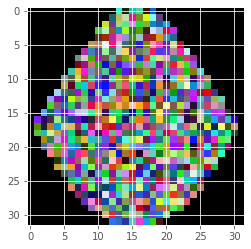

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow((images[0] * 255).astype(np.uint8))



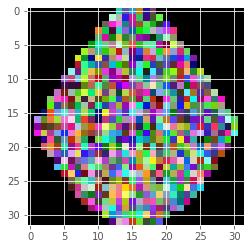

In [112]:
plt.imshow((images[1] * 255).astype(np.uint8))

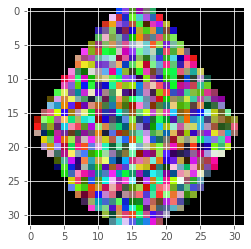

In [113]:
plt.imshow((images[2] * 255).astype(np.uint8))